# Version at 0.2AU and  1 Earth Mass
# Deposition version 2 with sharper smoothing
# To get to converge: load deposition profiles from 0.2AU 5 Earth Mass

In [1]:
load_dep = True

In [2]:
import numpy as np
import os 
from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits
import matplotlib.pyplot as plt
from scipy.special import erf 
import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools 

In [3]:
a_1 = 0.2
AU = 1.496e13
Mp = 1 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 670.820393249937
disk density: 2.0062209149292658e-07
hill radius: 4.0000e+10
bondi radius: 1.7889e+10


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
m_0 = 1e25
L_0 = 3.144546892817586e+27
Dep_0 = 5.972e27/3.154e7 

# r_outer = 1.496e13/r_0
r_outer = r_Hill /r_0 # 3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-6 #1e-2
tolerance = 1e-6 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr','m', 'L'], ncc_cutoff = ncc_cutoff)
R = np.log10(np.exp(domain.grid(0))*r_0)

In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 # unused
problem.parameters['M_0'] = M_0
problem.parameters['m_0'] = m_0
problem.parameters['Dep_0'] = Dep_0
problem.parameters['L_0'] = L_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
m = domain.new_field(name='m')
L = domain.new_field(name='L')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0
ones = np.ones(len(r['g']))

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 0.2*1e-5* 5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)
gm = G*Mc 

# rhodisk = 1e-11 #g/cm**3
# Tdisk = 150 # kelvin

# # rhodisk = 4e-9 #g/cm**3
# # Tdisk = 370 # kelvin

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

mdep = rho_o * 4/3 * pi *(1e4)**3
dMdisk = 5e-9 * 5.972e27/3.154e7/5000


problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass 
problem.parameters['mu'] = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = 1.38064852e-16 # g*cm**2/(K*s**2)
problem.parameters['G'] = 6.67408e-8 # cm**3/(g*s**2)
problem.parameters['dMtot'] = 0.2*1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = 1e-4 # cm
problem.parameters['rho_o'] = 3 #g cm^-3 grain internal density
problem.parameters['mdep'] = problem.parameters['rho_o']*4/3*np.pi*(1e-4)**(3)
problem.parameters['sigma_b'] = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
problem.parameters['grad_rad_cst'] = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])


# problem.parameters['rhodisk'] = 4e-9 # 1e-11 #g/cm**3
# problem.parameters['Tdisk'] = 370 # 150 # kelvin

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = '(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)' # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)


# Deposition Type (3 versions) 

-27.631021115928547


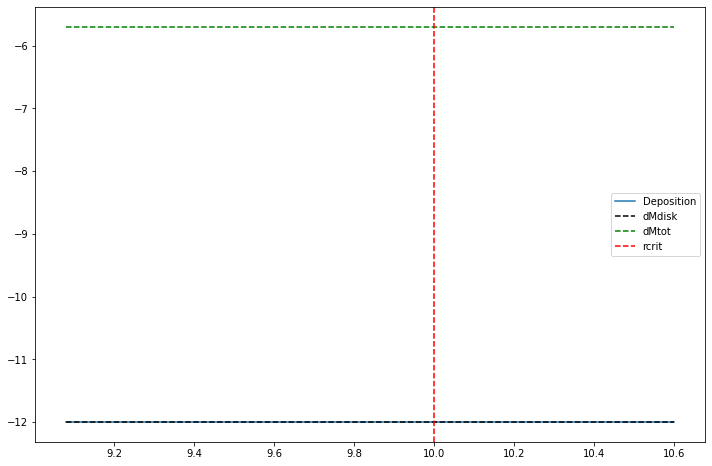

In [7]:
# # Mass deposition 
deposition_version = 'null'

if deposition_version == 0:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.loadtxt('M1dep.txt')

    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    Mdep_fixed = lgdM['g']
    dlgdM_fixed = dlgdM['g']
    n_roll = Mdep_fixed.shape[0]//4
    Mdep_fixed_rolled =np.roll(Mdep_fixed, n_roll)
    dlgdM_fixed_rolled = np.roll(dlgdM_fixed, n_roll)

    # Correct leftmost values too low from wrapping around
    Mdep_fixed_rolled[:n_roll] = Mdep_fixed[0]
    dlgdM_fixed_rolled[:n_roll] = 0. # Zero gradient for constant value correction

    ones = lgdM['g']/lgdM['g']

    constant = np.log(ones*1e-5)
    dconstant = 0.*ones

    lgdM['g'] = Mdep_fixed_rolled
    dlgdM['g'] = dlgdM_fixed_rolled

    

elif deposition_version == 1:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

# elif deposition_version=='None':
#     lgdM = domain.new_field(name='lgdM')
#     lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
#     d_r = log_basis.Differentiate(lgdM)
#     dlgdM = d_r.evaluate()

elif deposition_version=='null':
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = X*0
    lgdM['g'] = lgdM['g']+np.log(dMdisk/Dep_0)
    print(np.log(dMdisk/Dep_0))
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

else:
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log((dMdisk + (dMtot-dMdisk)*((-erf(smooth*X) + 1)/2))/Dep_0)    
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    
problem.parameters['lgDep'] = lgdM
problem.parameters['dlgDep'] = dlgdM

lgDep = domain.new_field(name='lgDep')
dlgDep = domain.new_field(name='dlgDep')
lgDep['g'] = lgdM['g']
dlgDep['g'] = dlgdM['g']

plt.figure(figsize=(12,8))
plt.plot(R, np.log10(np.exp(lgdM['g'])), label='Deposition')
plt.plot(R, np.log10(ones*dMdisk/Dep_0), 'k--', label='dMdisk')
plt.plot(R, np.log10(ones*dMtot/Dep_0), 'g--', label='dMtot')
if deposition_version != 1 and deposition_version !=0:
    plt.axvline(location, color = 'r', ls='--', label='rcrit')
plt.legend()
# plt.plot(R, np.log10(np.exp(dlgdM['g'])))

In [8]:
# Opacity

problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898

# min(2,ex*T*T_0) 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)" 
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3) # O(10^-14)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)" 
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [9]:
# Gradient  


# problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad


# problem.substitutions['grad_rad'] = '-3*kappa*exp(L)*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
problem.substitutions['grad_rad'] = '-3*kappa*L*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
grad_rad = -3*kappa*L*L_0/(64*pi*sigma_b*gm) * np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4


# min
k1 = -10. # -30.
problem.parameters['k1'] = k1
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 
grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)

In [10]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 30 #1 #15
problem.parameters['l'] = l

problem.substitutions['max'] = "(0.5*(1 + (s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)


problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [11]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [12]:
# Energy equation

# problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**2) * dlgDep * 1e5'
problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**3) * dlgDep * Dep_0 * exp(lgDep)'
drho_dep = -1/(4*pi*(np.exp(r)*r_0)**3) * dlgDep * Dep_0 * np.exp(lgDep)

Trelax = 1e30
problem.parameters['Trelax'] = Trelax

Lcore = problem.parameters['gm']*problem.parameters['dMtot']/(r_inner*r_0)
problem.parameters['Lcore'] = Lcore
print(problem.parameters['Lcore'])

1.2578187571270345e+26


In [13]:
# New equations

problem.add_equation('lgZgr = log(exp(lgDep)*Dep_0/(4*pi*gm*Tstop*rho_g))')
# problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop) + dlgDep*(mdep-exp(lgM)*M_0)/(exp(lgM)*M_0)')

In [14]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('dr(m) = 4*pi*(exp(r)*r_0)**3 * rho_g/m_0')
problem.add_equation('exp(r) * dr(lgP) = -G*(Mc+m*m_0)*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

# problem.add_equation('dr(L) = 4*pi*(exp(r)*r_0)* (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0))')
# problem.add_equation('dr(L)*L_0 = 4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax )')
problem.add_equation('dr(L)*L_0 = (4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax ))')


In [15]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3/30)")
problem.add_bc("left(m) = 0")
problem.add_bc("left(L) = Lcore/L_0")
# problem.add_bc("right(lgM) =log(1e-12*4*pi*rho_o/M_0/3)")

In [16]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2020-11-16 04:07:45,987 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+01/s


Text(0.5, 1.0, 'm')

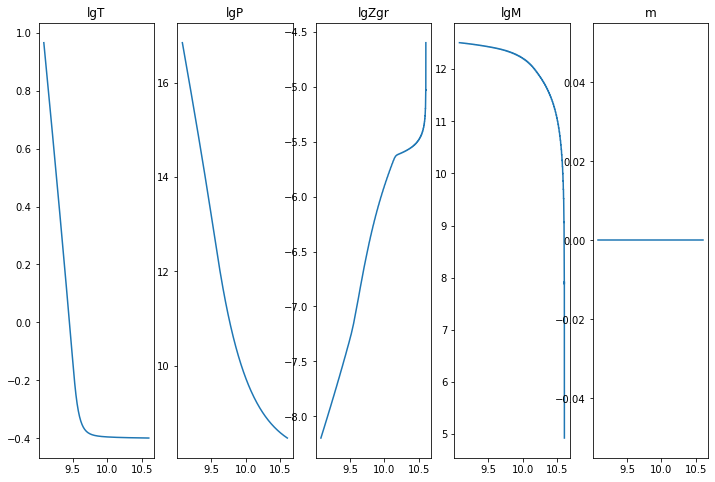

In [17]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
Rscale = np.log10(np.exp(domain.grid(0))*r_0)
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

L1 = solver.state['L']
m1= solver.state['m']

# Load from constant Mass and Zgr version

lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
Zi = np.loadtxt('Zgr.txt')
Mi = np.loadtxt('M.txt')

lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']

L1['g'] = ones*problem.parameters['Lcore']/L_0

lgZgr1['g'] = Zi 

lgM1['g'] = Mi
m1['g'] = ones*0


if load_dep: 
    lgP1['g'] = np.loadtxt("NPressure_dep.txt")
    lgT1['g'] = np.loadtxt("NTemperature_dep.txt")
    L1['g'] = np.loadtxt('NL_dep.txt')
    lgZgr1['g'] = np.loadtxt('NZgr_dep.txt') 
    lgM1['g'] = np.loadtxt('NM_dep.txt')
    m1['g'] = np.loadtxt('Nm_dep.txt')
    
    
plt.figure(figsize=(12,8))
plt.subplot(1,5,1)
plt.plot(Rscale,lgT1['g'])
plt.title("lgT")
plt.subplot(1,5,2)
plt.plot(Rscale, lgP1['g'])
plt.title("lgP")
plt.subplot(1,5,3)
plt.plot(Rscale, np.log10(np.exp(lgZgr1['g'])))
plt.title("lgZgr")
plt.subplot(1,5,4)
plt.plot(Rscale, lgM1['g'])
plt.title("lgM")
plt.subplot(1,5,5)
plt.plot(Rscale, m1['g'])
plt.title("m")

In [18]:

lgT_list = [np.copy(lgT1['g'])]
lgP_list = [np.copy(lgP1['g'])]
lgZgr_list = [np.copy(lgZgr1['g'])]
lgM_list = [np.copy(lgM1['g'])]
m_list = [np.copy(m1['g'])]
L_list = [np.copy(L1['g'])]

2020-11-16 04:07:51,339 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:07:52,590 __main__ 0/1 INFO :: Perturbation norm: 8.99186724424175
2020-11-16 04:07:52,591 __main__ 0/1 INFO :: lgT iterate: 0.9657092374389658
2020-11-16 04:07:52,592 __main__ 0/1 INFO :: lgP iterate: 16.84861703547577
2020-11-16 04:07:52,593 __main__ 0/1 INFO :: lgM iterate: 12.229396944167387
2020-11-16 04:07:52,594 __main__ 0/1 INFO :: lgZgr iterate: -18.910310529651426
2020-11-16 04:07:52,595 __main__ 0/1 INFO :: m iterate: 1.6063379376873854e-05
2020-11-16 04:07:52,596 __main__ 0/1 INFO :: L iterate: 0.03999999999999994


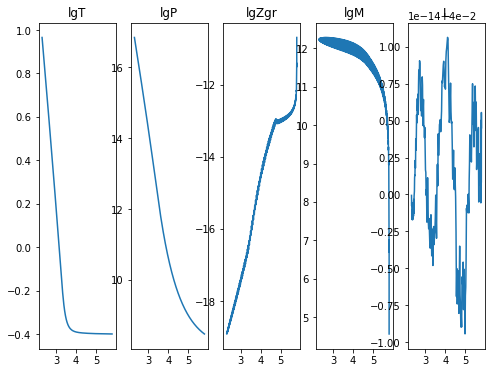

2020-11-16 04:07:56,879 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:07:58,359 __main__ 0/1 INFO :: Perturbation norm: 1.2595437218331107
2020-11-16 04:07:58,363 __main__ 0/1 INFO :: lgT iterate: 0.9656586952605746
2020-11-16 04:07:58,364 __main__ 0/1 INFO :: lgP iterate: 16.852096049792237
2020-11-16 04:07:58,365 __main__ 0/1 INFO :: lgM iterate: 12.314919714468646
2020-11-16 04:07:58,367 __main__ 0/1 INFO :: lgZgr iterate: -18.97085722197214
2020-11-16 04:07:58,369 __main__ 0/1 INFO :: m iterate: 1.6120870456770575e-05
2020-11-16 04:07:58,370 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


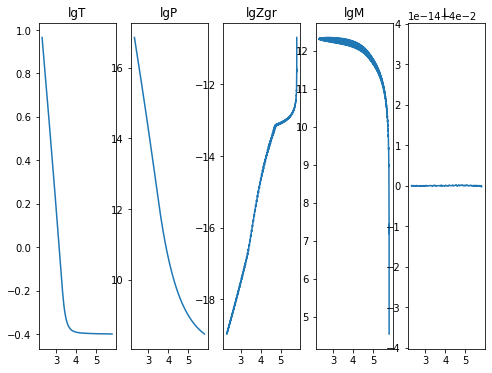

2020-11-16 04:08:03,341 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:08:04,811 __main__ 0/1 INFO :: Perturbation norm: 1.1436340480195635
2020-11-16 04:08:04,813 __main__ 0/1 INFO :: lgT iterate: 0.9656531511173883
2020-11-16 04:08:04,814 __main__ 0/1 INFO :: lgP iterate: 16.852344792503253
2020-11-16 04:08:04,815 __main__ 0/1 INFO :: lgM iterate: 12.347153667901068
2020-11-16 04:08:04,817 __main__ 0/1 INFO :: lgZgr iterate: -18.992629661389767
2020-11-16 04:08:04,819 __main__ 0/1 INFO :: m iterate: 1.6132011177560912e-05
2020-11-16 04:08:04,820 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


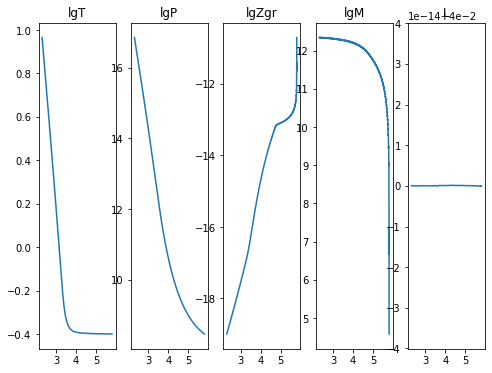

2020-11-16 04:08:09,083 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:08:10,712 __main__ 0/1 INFO :: Perturbation norm: 1.5886833601848271
2020-11-16 04:08:10,713 __main__ 0/1 INFO :: lgT iterate: 0.9656813821090526
2020-11-16 04:08:10,714 __main__ 0/1 INFO :: lgP iterate: 16.8506065375333
2020-11-16 04:08:10,715 __main__ 0/1 INFO :: lgM iterate: 12.282100297990485
2020-11-16 04:08:10,716 __main__ 0/1 INFO :: lgZgr iterate: -18.94749596136871
2020-11-16 04:08:10,718 __main__ 0/1 INFO :: m iterate: 1.6102632218295554e-05
2020-11-16 04:08:10,719 __main__ 0/1 INFO :: L iterate: 0.04


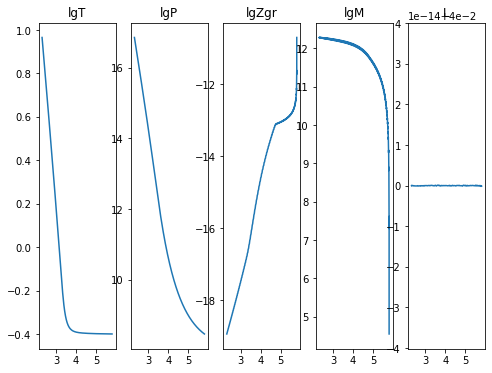

2020-11-16 04:08:15,967 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:08:17,146 __main__ 0/1 INFO :: Perturbation norm: 1.567152943585987
2020-11-16 04:08:17,147 __main__ 0/1 INFO :: lgT iterate: 0.965669410031632
2020-11-16 04:08:17,148 __main__ 0/1 INFO :: lgP iterate: 16.851469775307528
2020-11-16 04:08:17,149 __main__ 0/1 INFO :: lgM iterate: 12.312150996707521
2020-11-16 04:08:17,150 __main__ 0/1 INFO :: lgZgr iterate: -18.968413142513167
2020-11-16 04:08:17,151 __main__ 0/1 INFO :: m iterate: 1.6117148081917776e-05
2020-11-16 04:08:17,152 __main__ 0/1 INFO :: L iterate: 0.04


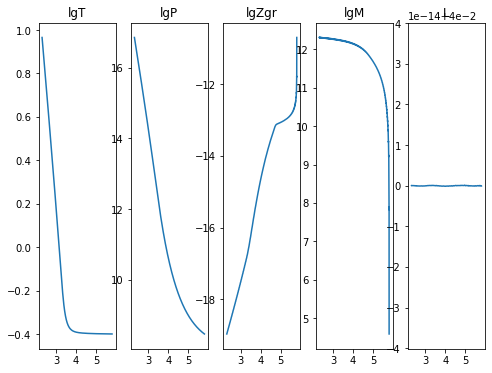

2020-11-16 04:08:20,901 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:08:22,089 __main__ 0/1 INFO :: Perturbation norm: 1.738580865510056
2020-11-16 04:08:22,091 __main__ 0/1 INFO :: lgT iterate: 0.9656843686785921
2020-11-16 04:08:22,092 __main__ 0/1 INFO :: lgP iterate: 16.850354581067847
2020-11-16 04:08:22,092 __main__ 0/1 INFO :: lgM iterate: 12.278616390550885
2020-11-16 04:08:22,093 __main__ 0/1 INFO :: lgZgr iterate: -18.944913439769252
2020-11-16 04:08:22,094 __main__ 0/1 INFO :: m iterate: 1.6098650377216472e-05
2020-11-16 04:08:22,095 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


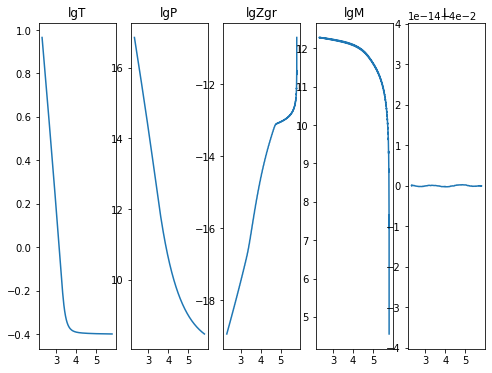

2020-11-16 04:08:26,017 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:08:27,211 __main__ 0/1 INFO :: Perturbation norm: 1.6640531467076318
2020-11-16 04:08:27,212 __main__ 0/1 INFO :: lgT iterate: 0.9656721334886293
2020-11-16 04:08:27,213 __main__ 0/1 INFO :: lgP iterate: 16.85127048347274
2020-11-16 04:08:27,214 __main__ 0/1 INFO :: lgM iterate: 12.30566184089339
2020-11-16 04:08:27,214 __main__ 0/1 INFO :: lgZgr iterate: -18.963884441240523
2020-11-16 04:08:27,216 __main__ 0/1 INFO :: m iterate: 1.6113522412375403e-05
2020-11-16 04:08:27,217 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


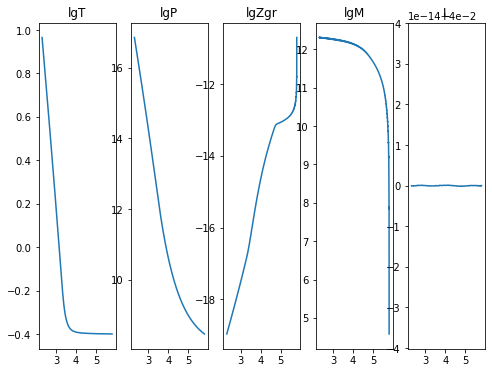

2020-11-16 04:08:31,023 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:08:32,131 __main__ 0/1 INFO :: Perturbation norm: 1.6596374565468675
2020-11-16 04:08:32,132 __main__ 0/1 INFO :: lgT iterate: 0.9656845733123893
2020-11-16 04:08:32,133 __main__ 0/1 INFO :: lgP iterate: 16.85035229422064
2020-11-16 04:08:32,134 __main__ 0/1 INFO :: lgM iterate: 12.279294951949447
2020-11-16 04:08:32,135 __main__ 0/1 INFO :: lgZgr iterate: -18.94536299238531
2020-11-16 04:08:32,136 __main__ 0/1 INFO :: m iterate: 1.609847690264843e-05
2020-11-16 04:08:32,136 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


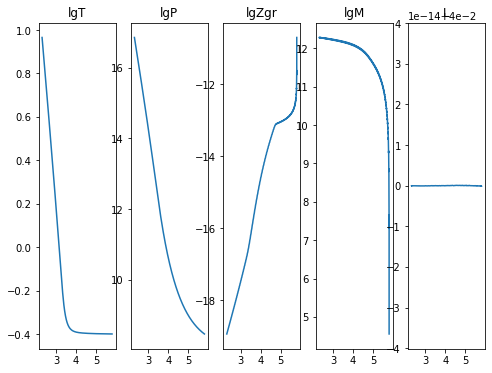

2020-11-16 04:08:35,883 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:08:37,021 __main__ 0/1 INFO :: Perturbation norm: 1.6479594576268461
2020-11-16 04:08:37,022 __main__ 0/1 INFO :: lgT iterate: 0.9656717786605096
2020-11-16 04:08:37,023 __main__ 0/1 INFO :: lgP iterate: 16.851288211950184
2020-11-16 04:08:37,023 __main__ 0/1 INFO :: lgM iterate: 12.306448613181953
2020-11-16 04:08:37,024 __main__ 0/1 INFO :: lgZgr iterate: -18.964427228581144
2020-11-16 04:08:37,025 __main__ 0/1 INFO :: m iterate: 1.6113822686847357e-05
2020-11-16 04:08:37,026 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


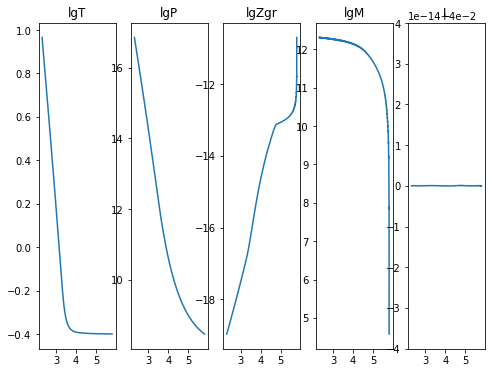

2020-11-16 04:08:40,868 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:08:41,988 __main__ 0/1 INFO :: Perturbation norm: 1.6459642555307579
2020-11-16 04:08:41,989 __main__ 0/1 INFO :: lgT iterate: 0.9656848035056231
2020-11-16 04:08:41,990 __main__ 0/1 INFO :: lgP iterate: 16.85034022994226
2020-11-16 04:08:41,991 __main__ 0/1 INFO :: lgM iterate: 12.278785736296205
2020-11-16 04:08:41,992 __main__ 0/1 INFO :: lgZgr iterate: -18.945010958372386
2020-11-16 04:08:41,994 __main__ 0/1 INFO :: m iterate: 1.6098267209496697e-05
2020-11-16 04:08:41,995 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


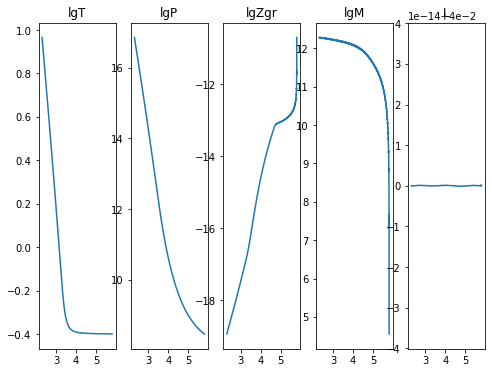

2020-11-16 04:08:45,677 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:08:46,768 __main__ 0/1 INFO :: Perturbation norm: 1.65672711740398
2020-11-16 04:08:46,769 __main__ 0/1 INFO :: lgT iterate: 0.9656716004564492
2020-11-16 04:08:46,770 __main__ 0/1 INFO :: lgP iterate: 16.851302070563477
2020-11-16 04:08:46,771 __main__ 0/1 INFO :: lgM iterate: 12.30680314599502
2020-11-16 04:08:46,772 __main__ 0/1 INFO :: lgZgr iterate: -18.964677734737865
2020-11-16 04:08:46,773 __main__ 0/1 INFO :: m iterate: 1.6114067098449425e-05
2020-11-16 04:08:46,774 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


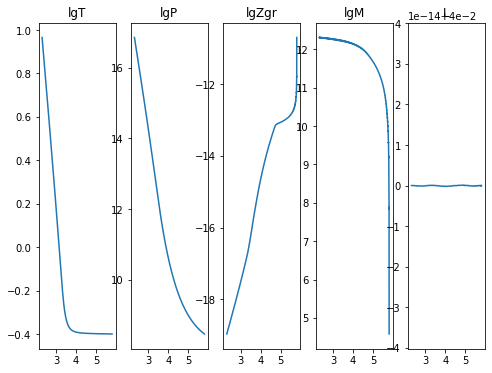

2020-11-16 04:08:50,969 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:08:52,400 __main__ 0/1 INFO :: Perturbation norm: 1.6645513300968924
2020-11-16 04:08:52,401 __main__ 0/1 INFO :: lgT iterate: 0.9656848882169144
2020-11-16 04:08:52,402 __main__ 0/1 INFO :: lgP iterate: 16.85033179395755
2020-11-16 04:08:52,403 __main__ 0/1 INFO :: lgM iterate: 12.278471714280297
2020-11-16 04:08:52,404 __main__ 0/1 INFO :: lgZgr iterate: -18.944792922281636
2020-11-16 04:08:52,405 __main__ 0/1 INFO :: m iterate: 1.609814793379627e-05
2020-11-16 04:08:52,406 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


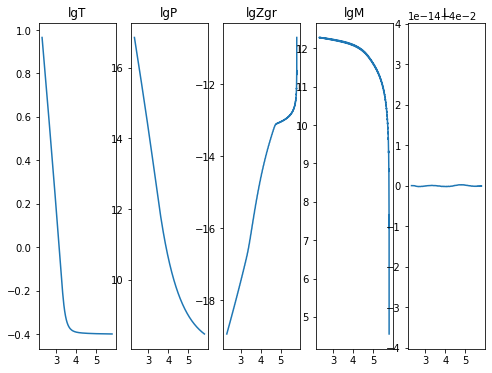

2020-11-16 04:08:57,183 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:08:58,747 __main__ 0/1 INFO :: Perturbation norm: 1.6670576931083363
2020-11-16 04:08:58,747 __main__ 0/1 INFO :: lgT iterate: 0.9656716418191759
2020-11-16 04:08:58,753 __main__ 0/1 INFO :: lgP iterate: 16.851299109378914
2020-11-16 04:08:58,756 __main__ 0/1 INFO :: lgM iterate: 12.306658492971524
2020-11-16 04:08:58,757 __main__ 0/1 INFO :: lgZgr iterate: -18.964578282740238
2020-11-16 04:08:58,758 __main__ 0/1 INFO :: m iterate: 1.611401127554757e-05
2020-11-16 04:08:58,759 __main__ 0/1 INFO :: L iterate: 0.04


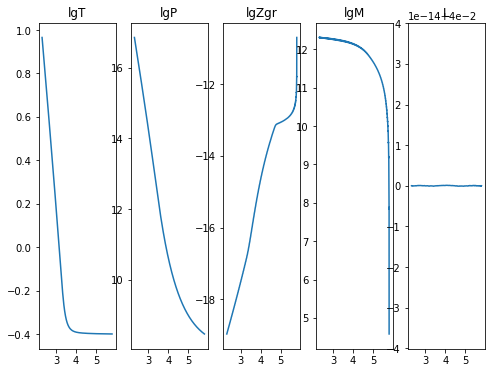

2020-11-16 04:09:02,954 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:04,154 __main__ 0/1 INFO :: Perturbation norm: 1.6699700776977742
2020-11-16 04:09:04,155 __main__ 0/1 INFO :: lgT iterate: 0.965684899430074
2020-11-16 04:09:04,156 __main__ 0/1 INFO :: lgP iterate: 16.850330198242496
2020-11-16 04:09:04,157 __main__ 0/1 INFO :: lgM iterate: 12.278438747585026
2020-11-16 04:09:04,158 __main__ 0/1 INFO :: lgZgr iterate: -18.944769319516254
2020-11-16 04:09:04,159 __main__ 0/1 INFO :: m iterate: 1.609812313185799e-05
2020-11-16 04:09:04,160 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


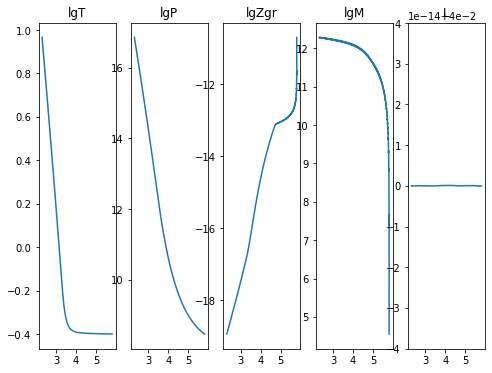

2020-11-16 04:09:07,943 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:09,025 __main__ 0/1 INFO :: Perturbation norm: 1.6701662697330564
2020-11-16 04:09:09,027 __main__ 0/1 INFO :: lgT iterate: 0.9656716408445446
2020-11-16 04:09:09,028 __main__ 0/1 INFO :: lgP iterate: 16.851298639241215
2020-11-16 04:09:09,029 __main__ 0/1 INFO :: lgM iterate: 12.306640134141489
2020-11-16 04:09:09,030 __main__ 0/1 INFO :: lgZgr iterate: -18.964565574199206
2020-11-16 04:09:09,032 __main__ 0/1 INFO :: m iterate: 1.6114000559230846e-05
2020-11-16 04:09:09,033 __main__ 0/1 INFO :: L iterate: 0.04


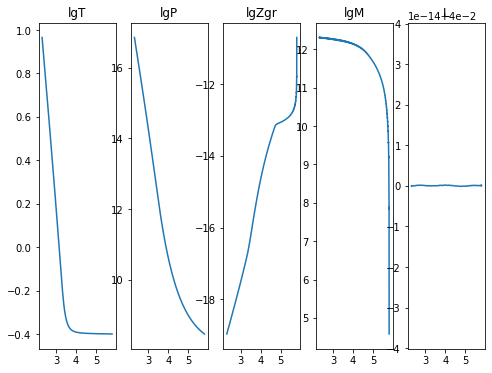

2020-11-16 04:09:12,880 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:09:13,977 __main__ 0/1 INFO :: Perturbation norm: 1.6707418545386497
2020-11-16 04:09:13,978 __main__ 0/1 INFO :: lgT iterate: 0.9656849031619295
2020-11-16 04:09:13,979 __main__ 0/1 INFO :: lgP iterate: 16.85032990962526
2020-11-16 04:09:13,980 __main__ 0/1 INFO :: lgM iterate: 12.278432034873724
2020-11-16 04:09:13,981 __main__ 0/1 INFO :: lgZgr iterate: -18.944764549625752
2020-11-16 04:09:13,982 __main__ 0/1 INFO :: m iterate: 1.6098117407548074e-05
2020-11-16 04:09:13,983 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


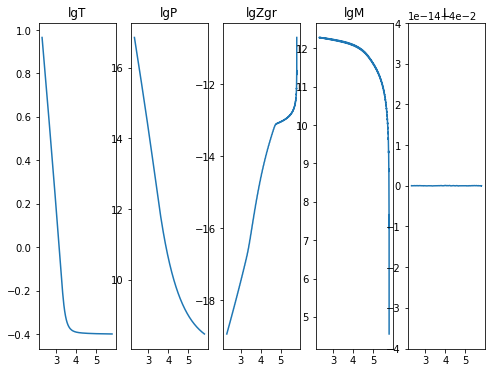

2020-11-16 04:09:17,705 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:18,800 __main__ 0/1 INFO :: Perturbation norm: 1.6711130508459902
2020-11-16 04:09:18,802 __main__ 0/1 INFO :: lgT iterate: 0.9656716294248708
2020-11-16 04:09:18,802 __main__ 0/1 INFO :: lgP iterate: 16.851299258734407
2020-11-16 04:09:18,803 __main__ 0/1 INFO :: lgM iterate: 12.306658836953893
2020-11-16 04:09:18,804 __main__ 0/1 INFO :: lgZgr iterate: -18.964578678638716
2020-11-16 04:09:18,805 __main__ 0/1 INFO :: m iterate: 1.6114010664036726e-05
2020-11-16 04:09:18,806 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


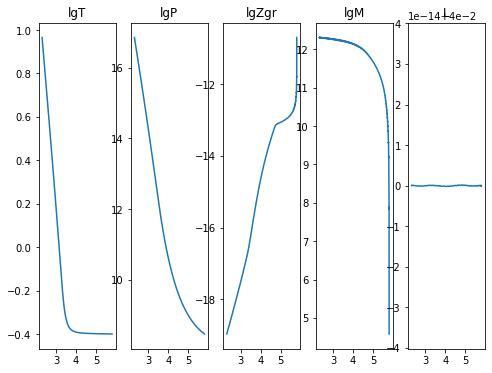

2020-11-16 04:09:22,635 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:23,745 __main__ 0/1 INFO :: Perturbation norm: 1.6714484822868951
2020-11-16 04:09:23,746 __main__ 0/1 INFO :: lgT iterate: 0.9656849062332844
2020-11-16 04:09:23,747 __main__ 0/1 INFO :: lgP iterate: 16.850329634935584
2020-11-16 04:09:23,748 __main__ 0/1 INFO :: lgM iterate: 12.278421171473859
2020-11-16 04:09:23,749 __main__ 0/1 INFO :: lgZgr iterate: -18.944757025889285
2020-11-16 04:09:23,750 __main__ 0/1 INFO :: m iterate: 1.6098113229556787e-05
2020-11-16 04:09:23,751 __main__ 0/1 INFO :: L iterate: 0.04


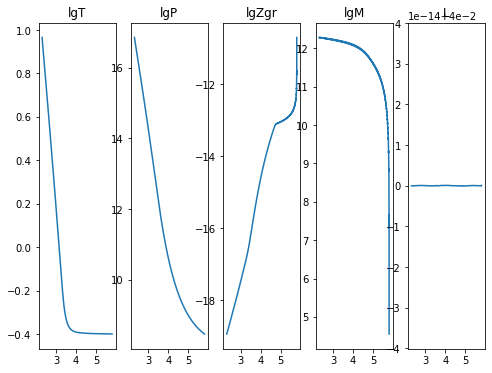

2020-11-16 04:09:27,536 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:28,941 __main__ 0/1 INFO :: Perturbation norm: 1.6716555573038603
2020-11-16 04:09:28,942 __main__ 0/1 INFO :: lgT iterate: 0.9656716266109856
2020-11-16 04:09:28,944 __main__ 0/1 INFO :: lgP iterate: 16.851299413909953
2020-11-16 04:09:28,945 __main__ 0/1 INFO :: lgM iterate: 12.30666188917809
2020-11-16 04:09:28,947 __main__ 0/1 INFO :: lgZgr iterate: -18.964580872966884
2020-11-16 04:09:28,949 __main__ 0/1 INFO :: m iterate: 1.6114013098533775e-05
2020-11-16 04:09:28,950 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


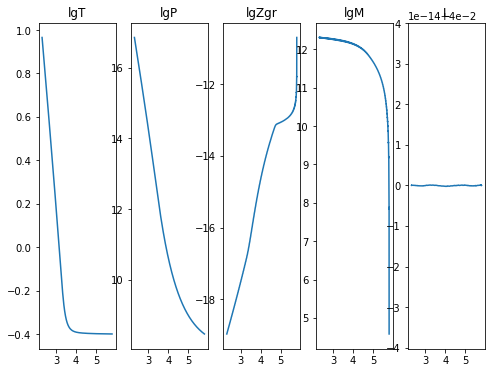

2020-11-16 04:09:32,805 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:09:33,936 __main__ 0/1 INFO :: Perturbation norm: 1.6718417767359672
2020-11-16 04:09:33,937 __main__ 0/1 INFO :: lgT iterate: 0.9656849073888076
2020-11-16 04:09:33,938 __main__ 0/1 INFO :: lgP iterate: 16.850329507624615
2020-11-16 04:09:33,939 __main__ 0/1 INFO :: lgM iterate: 12.278416817678831
2020-11-16 04:09:33,940 __main__ 0/1 INFO :: lgZgr iterate: -18.944753993180736
2020-11-16 04:09:33,941 __main__ 0/1 INFO :: m iterate: 1.6098111326634523e-05
2020-11-16 04:09:33,942 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


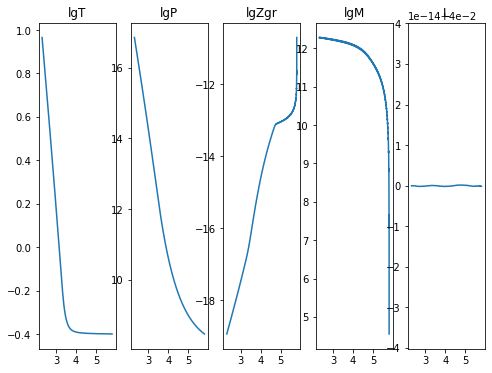

2020-11-16 04:09:37,735 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:09:38,836 __main__ 0/1 INFO :: Perturbation norm: 1.6719061137654525
2020-11-16 04:09:38,838 __main__ 0/1 INFO :: lgT iterate: 0.9656716259909068
2020-11-16 04:09:38,839 __main__ 0/1 INFO :: lgP iterate: 16.851299431950885
2020-11-16 04:09:38,839 __main__ 0/1 INFO :: lgM iterate: 12.306661754577279
2020-11-16 04:09:38,840 __main__ 0/1 INFO :: lgZgr iterate: -18.964580802225658
2020-11-16 04:09:38,841 __main__ 0/1 INFO :: m iterate: 1.6114013262846782e-05
2020-11-16 04:09:38,842 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


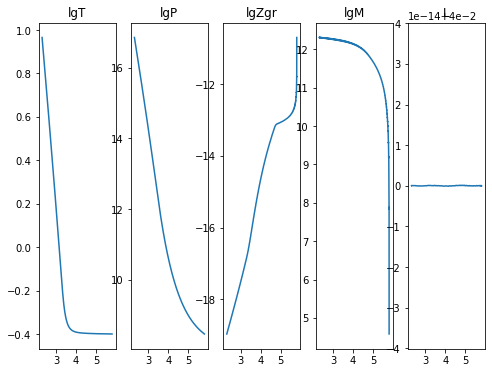

2020-11-16 04:09:42,689 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:43,866 __main__ 0/1 INFO :: Perturbation norm: 1.6719756362689977
2020-11-16 04:09:43,867 __main__ 0/1 INFO :: lgT iterate: 0.965684907767018
2020-11-16 04:09:43,868 __main__ 0/1 INFO :: lgP iterate: 16.85032946648022
2020-11-16 04:09:43,869 __main__ 0/1 INFO :: lgM iterate: 12.278415555195137
2020-11-16 04:09:43,870 __main__ 0/1 INFO :: lgZgr iterate: -18.944753109500837
2020-11-16 04:09:43,871 __main__ 0/1 INFO :: m iterate: 1.6098110672047028e-05
2020-11-16 04:09:43,872 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


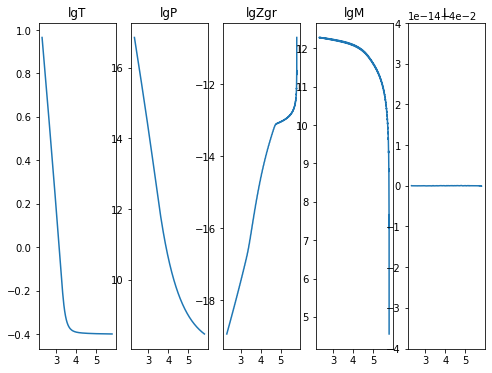

2020-11-16 04:09:47,667 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:09:48,800 __main__ 0/1 INFO :: Perturbation norm: 1.6720021566671752
2020-11-16 04:09:48,802 __main__ 0/1 INFO :: lgT iterate: 0.9656716255042932
2020-11-16 04:09:48,803 __main__ 0/1 INFO :: lgP iterate: 16.85129945299087
2020-11-16 04:09:48,804 __main__ 0/1 INFO :: lgM iterate: 12.306662221692786
2020-11-16 04:09:48,804 __main__ 0/1 INFO :: lgZgr iterate: -18.964581135380705
2020-11-16 04:09:48,805 __main__ 0/1 INFO :: m iterate: 1.6114013571488783e-05
2020-11-16 04:09:48,807 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


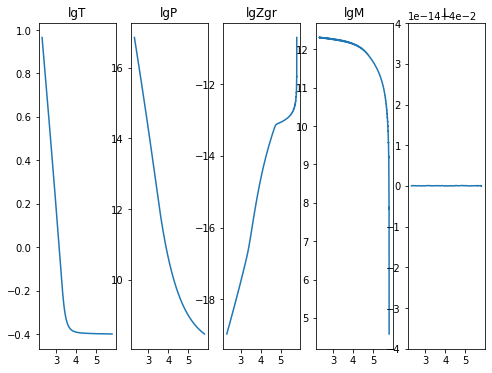

2020-11-16 04:09:52,635 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:09:53,726 __main__ 0/1 INFO :: Perturbation norm: 1.6720297792576784
2020-11-16 04:09:53,727 __main__ 0/1 INFO :: lgT iterate: 0.9656849079471945
2020-11-16 04:09:53,728 __main__ 0/1 INFO :: lgP iterate: 16.85032944861957
2020-11-16 04:09:53,729 __main__ 0/1 INFO :: lgM iterate: 12.278414943927086
2020-11-16 04:09:53,730 __main__ 0/1 INFO :: lgZgr iterate: -18.94475268372919
2020-11-16 04:09:53,731 __main__ 0/1 INFO :: m iterate: 1.6098110387829934e-05
2020-11-16 04:09:53,732 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


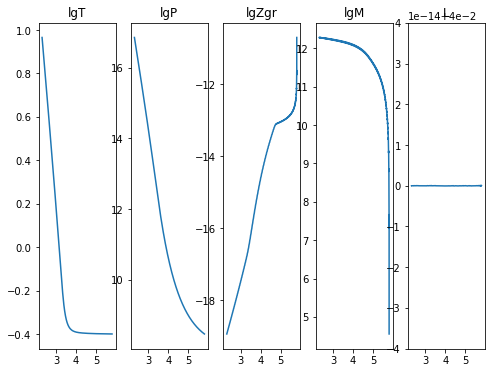

2020-11-16 04:09:57,472 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:09:58,633 __main__ 0/1 INFO :: Perturbation norm: 1.6720430868121452
2020-11-16 04:09:58,635 __main__ 0/1 INFO :: lgT iterate: 0.9656716252697228
2020-11-16 04:09:58,636 __main__ 0/1 INFO :: lgP iterate: 16.851299464533234
2020-11-16 04:09:58,639 __main__ 0/1 INFO :: lgM iterate: 12.306662486265967
2020-11-16 04:09:58,640 __main__ 0/1 INFO :: lgZgr iterate: -18.964581323650364
2020-11-16 04:09:58,642 __main__ 0/1 INFO :: m iterate: 1.611401374690402e-05
2020-11-16 04:09:58,643 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


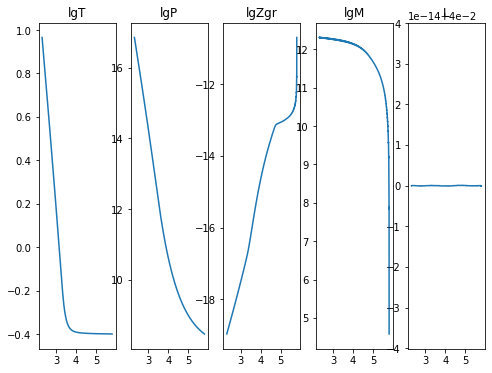

2020-11-16 04:10:02,515 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:10:03,640 __main__ 0/1 INFO :: Perturbation norm: 1.6720558826265606
2020-11-16 04:10:03,641 __main__ 0/1 INFO :: lgT iterate: 0.9656849080306296
2020-11-16 04:10:03,642 __main__ 0/1 INFO :: lgP iterate: 16.85032944004812
2020-11-16 04:10:03,643 __main__ 0/1 INFO :: lgM iterate: 12.278414644997861
2020-11-16 04:10:03,644 __main__ 0/1 INFO :: lgZgr iterate: -18.94475247567915
2020-11-16 04:10:03,645 __main__ 0/1 INFO :: m iterate: 1.6098110251050457e-05
2020-11-16 04:10:03,646 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


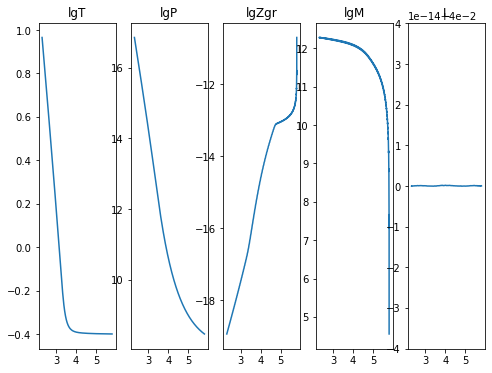

2020-11-16 04:10:07,520 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:10:08,626 __main__ 0/1 INFO :: Perturbation norm: 1.6720615020260943
2020-11-16 04:10:08,628 __main__ 0/1 INFO :: lgT iterate: 0.9656716251871456
2020-11-16 04:10:08,629 __main__ 0/1 INFO :: lgP iterate: 16.85129946831084
2020-11-16 04:10:08,629 __main__ 0/1 INFO :: lgM iterate: 12.306662556501259
2020-11-16 04:10:08,630 __main__ 0/1 INFO :: lgZgr iterate: -18.96458137437447
2020-11-16 04:10:08,631 __main__ 0/1 INFO :: m iterate: 1.611401380463562e-05
2020-11-16 04:10:08,632 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


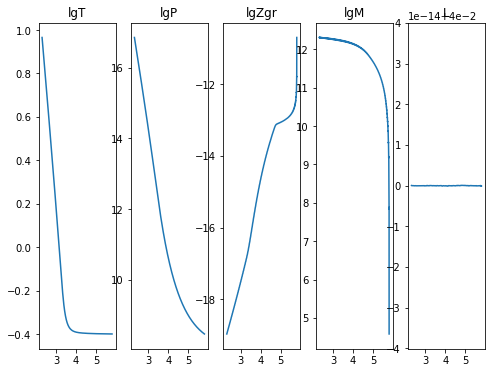

2020-11-16 04:10:12,448 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:10:13,617 __main__ 0/1 INFO :: Perturbation norm: 1.6720670635560952
2020-11-16 04:10:13,618 __main__ 0/1 INFO :: lgT iterate: 0.9656849080643869
2020-11-16 04:10:13,619 __main__ 0/1 INFO :: lgP iterate: 16.85032943648004
2020-11-16 04:10:13,620 __main__ 0/1 INFO :: lgM iterate: 12.278414525457649
2020-11-16 04:10:13,621 __main__ 0/1 INFO :: lgZgr iterate: -18.944752392339012
2020-11-16 04:10:13,622 __main__ 0/1 INFO :: m iterate: 1.609811019909202e-05
2020-11-16 04:10:13,623 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


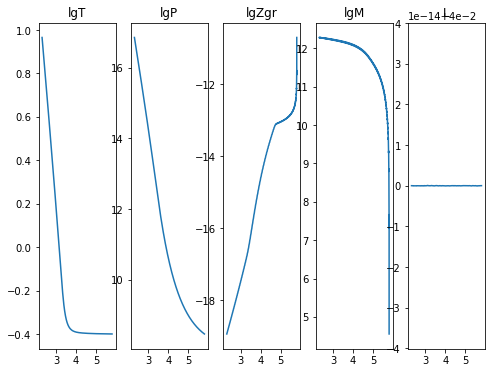

2020-11-16 04:10:17,387 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:10:18,599 __main__ 0/1 INFO :: Perturbation norm: 1.6720693416512877
2020-11-16 04:10:18,600 __main__ 0/1 INFO :: lgT iterate: 0.965671625151912
2020-11-16 04:10:18,601 __main__ 0/1 INFO :: lgP iterate: 16.851299469857437
2020-11-16 04:10:18,602 __main__ 0/1 INFO :: lgM iterate: 12.306662585996527
2020-11-16 04:10:18,603 __main__ 0/1 INFO :: lgZgr iterate: -18.96458139563652
2020-11-16 04:10:18,605 __main__ 0/1 INFO :: m iterate: 1.611401382106692e-05
2020-11-16 04:10:18,606 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


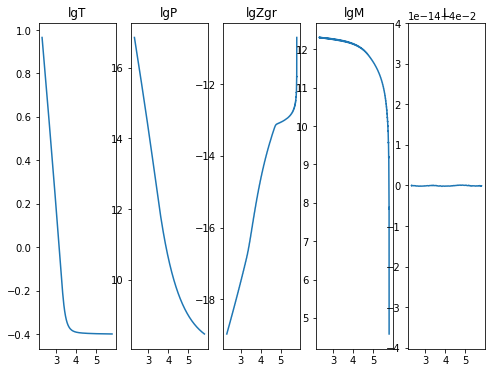

2020-11-16 04:10:23,204 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:10:24,473 __main__ 0/1 INFO :: Perturbation norm: 1.6720716505533981
2020-11-16 04:10:24,474 __main__ 0/1 INFO :: lgT iterate: 0.9656849080785658
2020-11-16 04:10:24,475 __main__ 0/1 INFO :: lgP iterate: 16.850329435008717
2020-11-16 04:10:24,476 __main__ 0/1 INFO :: lgM iterate: 12.278414476148159
2020-11-16 04:10:24,477 __main__ 0/1 INFO :: lgZgr iterate: -18.944752357962287
2020-11-16 04:10:24,478 __main__ 0/1 INFO :: m iterate: 1.6098110180440273e-05
2020-11-16 04:10:24,478 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


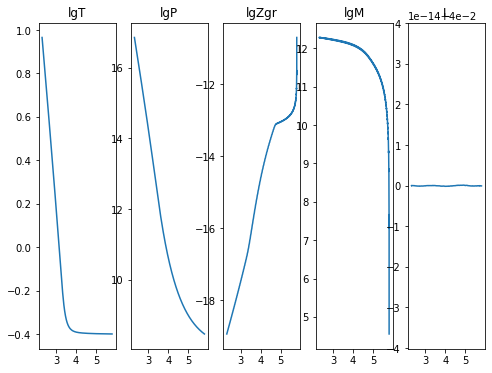

2020-11-16 04:10:28,857 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-11-16 04:10:30,004 __main__ 0/1 INFO :: Perturbation norm: 1.6720726460158475
2020-11-16 04:10:30,008 __main__ 0/1 INFO :: lgT iterate: 0.9656716251354556
2020-11-16 04:10:30,011 __main__ 0/1 INFO :: lgP iterate: 16.851299470613814
2020-11-16 04:10:30,014 __main__ 0/1 INFO :: lgM iterate: 12.306662601890817
2020-11-16 04:10:30,017 __main__ 0/1 INFO :: lgZgr iterate: -18.964581407013284
2020-11-16 04:10:30,020 __main__ 0/1 INFO :: m iterate: 1.611401383661004e-05
2020-11-16 04:10:30,023 __main__ 0/1 INFO :: L iterate: 0.04


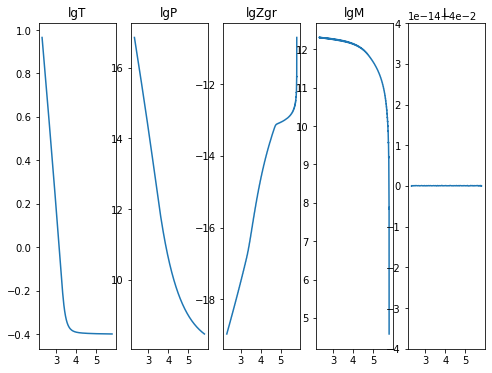

2020-11-16 04:10:34,125 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:10:35,781 __main__ 0/1 INFO :: Perturbation norm: 1.67207363756755
2020-11-16 04:10:35,782 __main__ 0/1 INFO :: lgT iterate: 0.9656849080848149
2020-11-16 04:10:35,783 __main__ 0/1 INFO :: lgP iterate: 16.85032943436498
2020-11-16 04:10:35,784 __main__ 0/1 INFO :: lgM iterate: 12.278414454204142
2020-11-16 04:10:35,785 __main__ 0/1 INFO :: lgZgr iterate: -18.944752342674917
2020-11-16 04:10:35,786 __main__ 0/1 INFO :: m iterate: 1.609811016534124e-05
2020-11-16 04:10:35,787 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


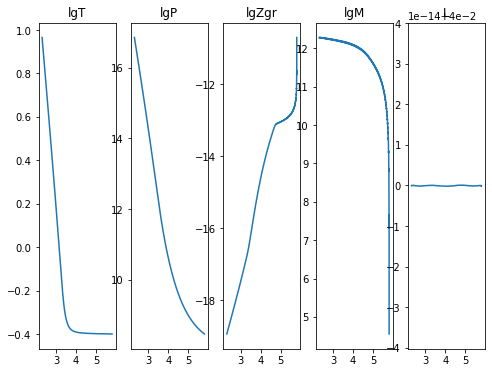

2020-11-16 04:10:40,420 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:10:41,880 __main__ 0/1 INFO :: Perturbation norm: 1.672074072455507
2020-11-16 04:10:41,882 __main__ 0/1 INFO :: lgT iterate: 0.9656716251285038
2020-11-16 04:10:41,883 __main__ 0/1 INFO :: lgP iterate: 16.851299470935338
2020-11-16 04:10:41,884 __main__ 0/1 INFO :: lgM iterate: 12.306662608466953
2020-11-16 04:10:41,885 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141172917
2020-11-16 04:10:41,887 __main__ 0/1 INFO :: m iterate: 1.6114013835277774e-05
2020-11-16 04:10:41,888 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


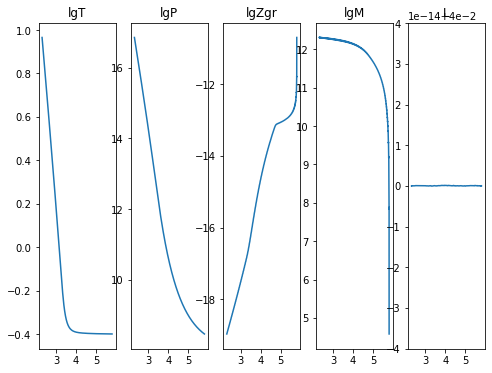

2020-11-16 04:10:46,370 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:10:47,670 __main__ 0/1 INFO :: Perturbation norm: 1.6720745030869901
2020-11-16 04:10:47,672 __main__ 0/1 INFO :: lgT iterate: 0.9656849080874989
2020-11-16 04:10:47,673 __main__ 0/1 INFO :: lgP iterate: 16.85032943408585
2020-11-16 04:10:47,674 __main__ 0/1 INFO :: lgM iterate: 12.278414444724636
2020-11-16 04:10:47,675 __main__ 0/1 INFO :: lgZgr iterate: -18.944752336069932
2020-11-16 04:10:47,676 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-11-16 04:10:47,677 __main__ 0/1 INFO :: L iterate: 0.04


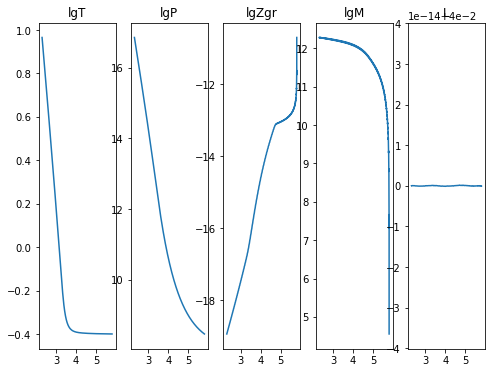

2020-11-16 04:10:51,681 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:10:52,859 __main__ 0/1 INFO :: Perturbation norm: 1.6720746875214174
2020-11-16 04:10:52,864 __main__ 0/1 INFO :: lgT iterate: 0.9656716251256083
2020-11-16 04:10:52,867 __main__ 0/1 INFO :: lgP iterate: 16.851299471066717
2020-11-16 04:10:52,871 __main__ 0/1 INFO :: lgM iterate: 12.306662611073241
2020-11-16 04:10:52,872 __main__ 0/1 INFO :: lgZgr iterate: -18.964581413602346
2020-11-16 04:10:52,873 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:10:52,880 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


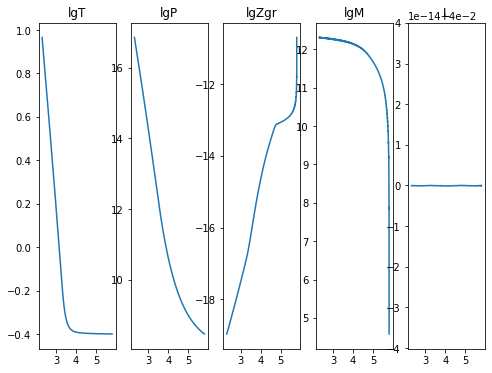

2020-11-16 04:10:57,015 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:10:58,399 __main__ 0/1 INFO :: Perturbation norm: 1.6720748715997982
2020-11-16 04:10:58,400 __main__ 0/1 INFO :: lgT iterate: 0.9656849080886378
2020-11-16 04:10:58,401 __main__ 0/1 INFO :: lgP iterate: 16.850329433967378
2020-11-16 04:10:58,402 __main__ 0/1 INFO :: lgM iterate: 12.27841444072428
2020-11-16 04:10:58,403 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233328194
2020-11-16 04:10:58,404 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-11-16 04:10:58,405 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


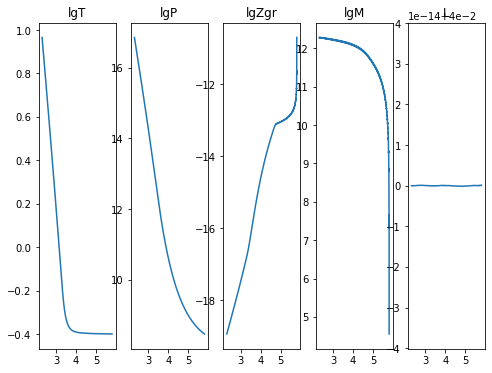

2020-11-16 04:11:02,359 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:11:03,519 __main__ 0/1 INFO :: Perturbation norm: 1.6720749502958114
2020-11-16 04:11:03,520 __main__ 0/1 INFO :: lgT iterate: 0.9656716251243544
2020-11-16 04:11:03,521 __main__ 0/1 INFO :: lgP iterate: 16.851299471123852
2020-11-16 04:11:03,522 __main__ 0/1 INFO :: lgM iterate: 12.306662612227697
2020-11-16 04:11:03,523 __main__ 0/1 INFO :: lgZgr iterate: -18.964581414430974
2020-11-16 04:11:03,524 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-11-16 04:11:03,525 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


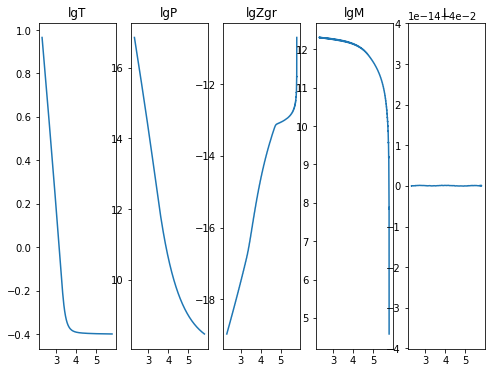

2020-11-16 04:11:07,499 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:11:08,628 __main__ 0/1 INFO :: Perturbation norm: 1.6720750288930404
2020-11-16 04:11:08,630 __main__ 0/1 INFO :: lgT iterate: 0.9656849080891261
2020-11-16 04:11:08,631 __main__ 0/1 INFO :: lgP iterate: 16.850329433916677
2020-11-16 04:11:08,632 __main__ 0/1 INFO :: lgM iterate: 12.27841443900814
2020-11-16 04:11:08,632 __main__ 0/1 INFO :: lgZgr iterate: -18.944752332086033
2020-11-16 04:11:08,633 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-11-16 04:11:08,634 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


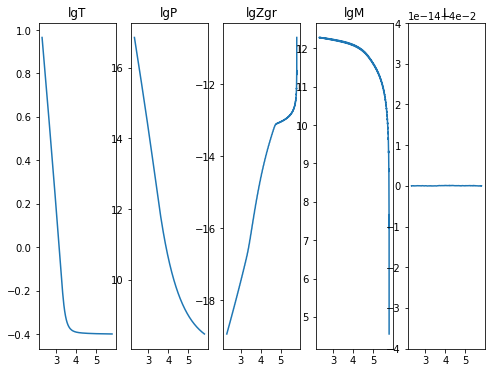

2020-11-16 04:11:12,552 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:11:13,731 __main__ 0/1 INFO :: Perturbation norm: 1.6720750628269978
2020-11-16 04:11:13,732 __main__ 0/1 INFO :: lgT iterate: 0.9656716251238107
2020-11-16 04:11:13,734 __main__ 0/1 INFO :: lgP iterate: 16.851299471148764
2020-11-16 04:11:13,735 __main__ 0/1 INFO :: lgM iterate: 12.306662612735211
2020-11-16 04:11:13,736 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141479502
2020-11-16 04:11:13,738 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:11:13,739 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


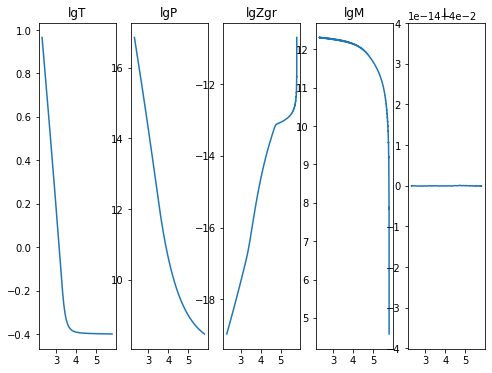

2020-11-16 04:11:17,609 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:11:19,028 __main__ 0/1 INFO :: Perturbation norm: 1.6720750966061646
2020-11-16 04:11:19,030 __main__ 0/1 INFO :: lgT iterate: 0.9656849080893382
2020-11-16 04:11:19,031 __main__ 0/1 INFO :: lgP iterate: 16.85032943389485
2020-11-16 04:11:19,032 __main__ 0/1 INFO :: lgM iterate: 12.278414438267454
2020-11-16 04:11:19,033 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331569923
2020-11-16 04:11:19,034 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:11:19,035 __main__ 0/1 INFO :: L iterate: 0.04


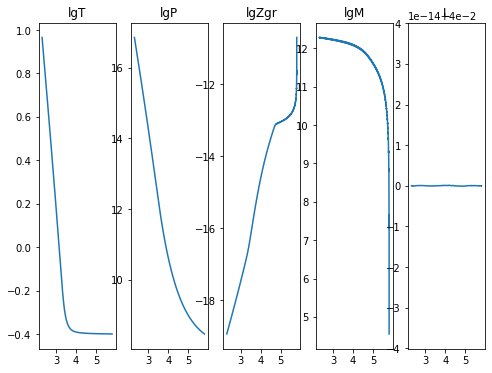

2020-11-16 04:11:23,499 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:11:24,655 __main__ 0/1 INFO :: Perturbation norm: 1.6720751111701497
2020-11-16 04:11:24,656 __main__ 0/1 INFO :: lgT iterate: 0.965671625123578
2020-11-16 04:11:24,657 __main__ 0/1 INFO :: lgP iterate: 16.85129947115935
2020-11-16 04:11:24,658 __main__ 0/1 INFO :: lgM iterate: 12.306662612949106
2020-11-16 04:11:24,659 __main__ 0/1 INFO :: lgZgr iterate: -18.964581414948547
2020-11-16 04:11:24,660 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-11-16 04:11:24,661 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


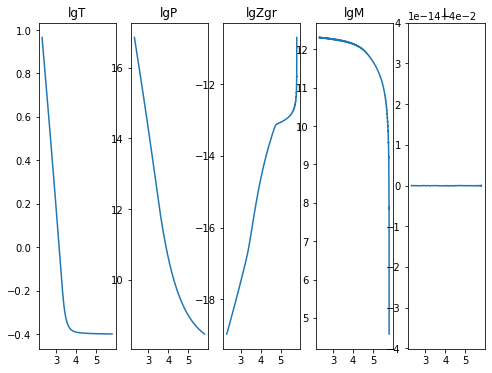

2020-11-16 04:11:29,079 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:11:30,660 __main__ 0/1 INFO :: Perturbation norm: 1.672075125673791
2020-11-16 04:11:30,664 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894275
2020-11-16 04:11:30,665 __main__ 0/1 INFO :: lgP iterate: 16.850329433885488
2020-11-16 04:11:30,666 __main__ 0/1 INFO :: lgM iterate: 12.2784144379503
2020-11-16 04:11:30,666 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331348916
2020-11-16 04:11:30,667 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:11:30,668 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


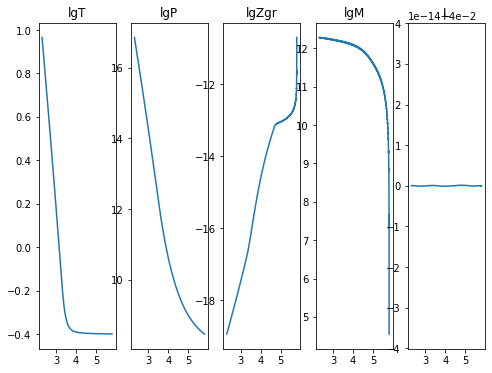

2020-11-16 04:11:35,098 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:11:36,196 __main__ 0/1 INFO :: Perturbation norm: 1.6720751319043723
2020-11-16 04:11:36,197 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234782
2020-11-16 04:11:36,198 __main__ 0/1 INFO :: lgP iterate: 16.851299471163856
2020-11-16 04:11:36,199 __main__ 0/1 INFO :: lgM iterate: 12.306662613040128
2020-11-16 04:11:36,200 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141501389
2020-11-16 04:11:36,201 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:11:36,202 __main__ 0/1 INFO :: L iterate: 0.04


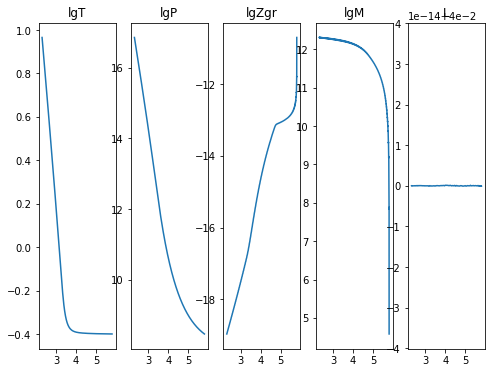

2020-11-16 04:11:40,661 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:11:41,819 __main__ 0/1 INFO :: Perturbation norm: 1.6720751381169316
2020-11-16 04:11:41,829 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894658
2020-11-16 04:11:41,829 __main__ 0/1 INFO :: lgP iterate: 16.850329433881477
2020-11-16 04:11:41,830 __main__ 0/1 INFO :: lgM iterate: 12.278414437814739
2020-11-16 04:11:41,831 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331254442
2020-11-16 04:11:41,832 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:11:41,833 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


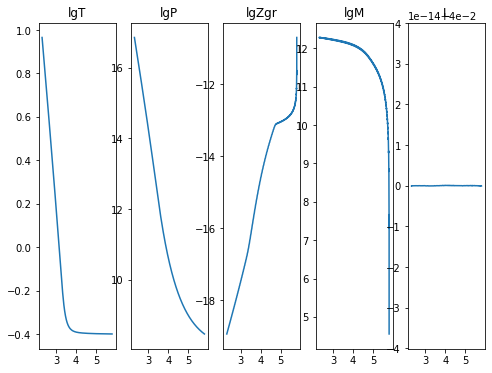

2020-11-16 04:11:46,190 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:11:47,409 __main__ 0/1 INFO :: Perturbation norm: 1.672075140789496
2020-11-16 04:11:47,410 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234365
2020-11-16 04:11:47,411 __main__ 0/1 INFO :: lgP iterate: 16.851299471165813
2020-11-16 04:11:47,412 __main__ 0/1 INFO :: lgM iterate: 12.306662613079538
2020-11-16 04:11:47,413 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415042176
2020-11-16 04:11:47,414 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-11-16 04:11:47,415 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


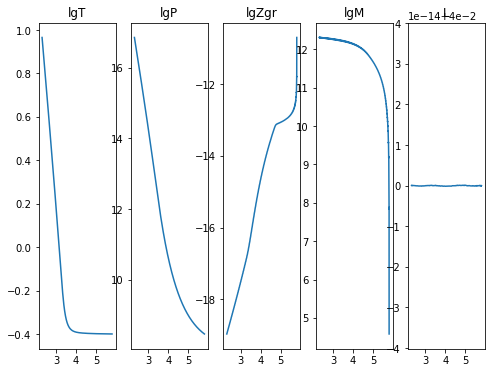

2020-11-16 04:11:51,357 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:11:52,601 __main__ 0/1 INFO :: Perturbation norm: 1.6720751434530299
2020-11-16 04:11:52,602 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894815
2020-11-16 04:11:52,603 __main__ 0/1 INFO :: lgP iterate: 16.850329433879754
2020-11-16 04:11:52,604 __main__ 0/1 INFO :: lgM iterate: 12.278414437756398
2020-11-16 04:11:52,605 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233121379
2020-11-16 04:11:52,606 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-11-16 04:11:52,607 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


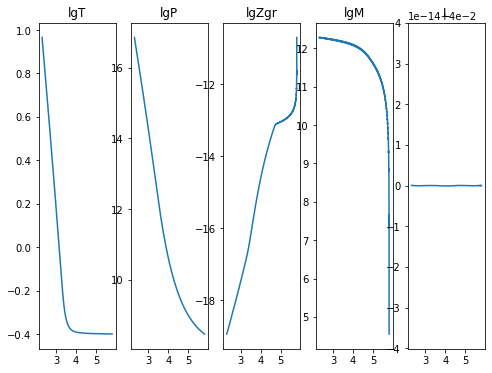

2020-11-16 04:11:56,741 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:11:58,102 __main__ 0/1 INFO :: Perturbation norm: 1.6720751445998483
2020-11-16 04:11:58,103 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234179
2020-11-16 04:11:58,104 __main__ 0/1 INFO :: lgP iterate: 16.85129947116665
2020-11-16 04:11:58,105 __main__ 0/1 INFO :: lgM iterate: 12.306662613096538
2020-11-16 04:11:58,106 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415054376
2020-11-16 04:11:58,107 __main__ 0/1 INFO :: m iterate: 1.6114013835721863e-05
2020-11-16 04:11:58,108 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


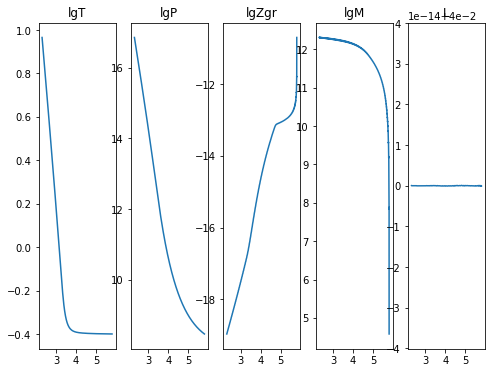

2020-11-16 04:12:02,523 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:12:04,197 __main__ 0/1 INFO :: Perturbation norm: 1.6720751457423997
2020-11-16 04:12:04,198 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894891
2020-11-16 04:12:04,199 __main__ 0/1 INFO :: lgP iterate: 16.85032943387902
2020-11-16 04:12:04,200 __main__ 0/1 INFO :: lgM iterate: 12.27841443773145
2020-11-16 04:12:04,201 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331196405
2020-11-16 04:12:04,202 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-11-16 04:12:04,203 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


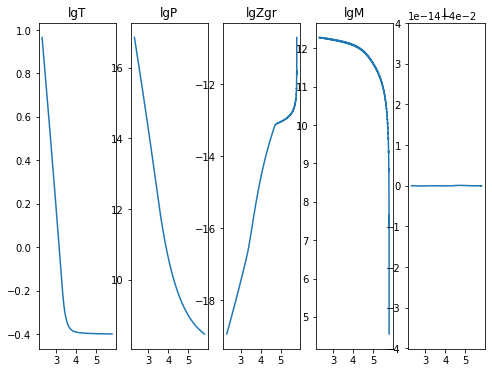

2020-11-16 04:12:08,715 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:12:10,034 __main__ 0/1 INFO :: Perturbation norm: 1.672075146234151
2020-11-16 04:12:10,036 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234094
2020-11-16 04:12:10,037 __main__ 0/1 INFO :: lgP iterate: 16.85129947116701
2020-11-16 04:12:10,038 __main__ 0/1 INFO :: lgM iterate: 12.306662613103827
2020-11-16 04:12:10,039 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150596
2020-11-16 04:12:10,040 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:12:10,042 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


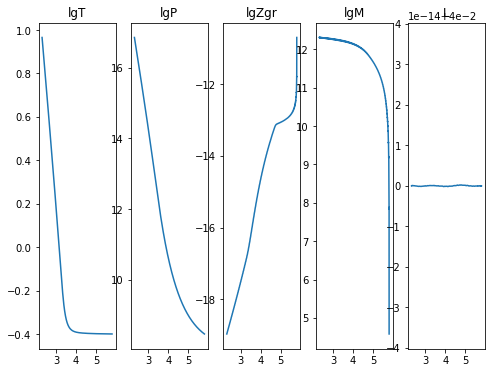

2020-11-16 04:12:14,384 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:12:15,356 __main__ 0/1 INFO :: Perturbation norm: 1.6720751467240498
2020-11-16 04:12:15,358 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894923
2020-11-16 04:12:15,359 __main__ 0/1 INFO :: lgP iterate: 16.8503294338787
2020-11-16 04:12:15,360 __main__ 0/1 INFO :: lgM iterate: 12.278414437720727
2020-11-16 04:12:15,361 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331188937
2020-11-16 04:12:15,362 __main__ 0/1 INFO :: m iterate: 1.6098110155571277e-05
2020-11-16 04:12:15,363 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


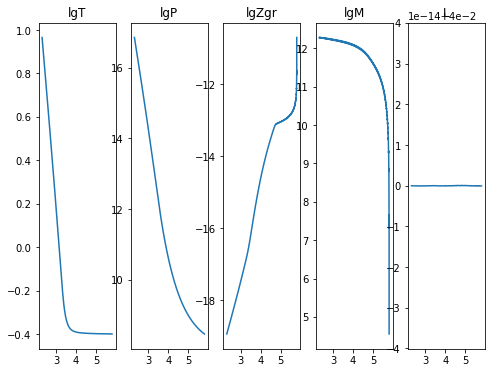

2020-11-16 04:12:19,212 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:12:20,330 __main__ 0/1 INFO :: Perturbation norm: 1.6720751469355222
2020-11-16 04:12:20,332 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234068
2020-11-16 04:12:20,333 __main__ 0/1 INFO :: lgP iterate: 16.851299471167167
2020-11-16 04:12:20,333 __main__ 0/1 INFO :: lgM iterate: 12.306662613106852
2020-11-16 04:12:20,334 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506178
2020-11-16 04:12:20,335 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-11-16 04:12:20,336 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


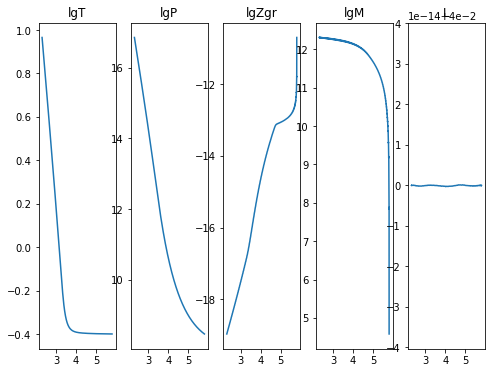

2020-11-16 04:12:24,270 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:12:25,469 __main__ 0/1 INFO :: Perturbation norm: 1.6720751471462592
2020-11-16 04:12:25,471 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894948
2020-11-16 04:12:25,472 __main__ 0/1 INFO :: lgP iterate: 16.850329433878557
2020-11-16 04:12:25,473 __main__ 0/1 INFO :: lgM iterate: 12.278414437715998
2020-11-16 04:12:25,473 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118564
2020-11-16 04:12:25,475 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:12:25,476 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


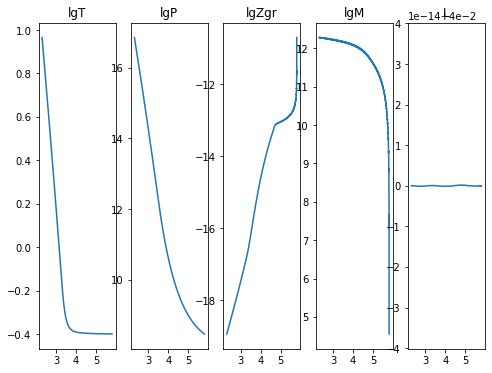

2020-11-16 04:12:29,340 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:12:30,503 __main__ 0/1 INFO :: Perturbation norm: 1.6720751472364317
2020-11-16 04:12:30,504 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234065
2020-11-16 04:12:30,505 __main__ 0/1 INFO :: lgP iterate: 16.851299471167227
2020-11-16 04:12:30,506 __main__ 0/1 INFO :: lgM iterate: 12.306662613108067
2020-11-16 04:12:30,507 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415062657
2020-11-16 04:12:30,508 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:12:30,509 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


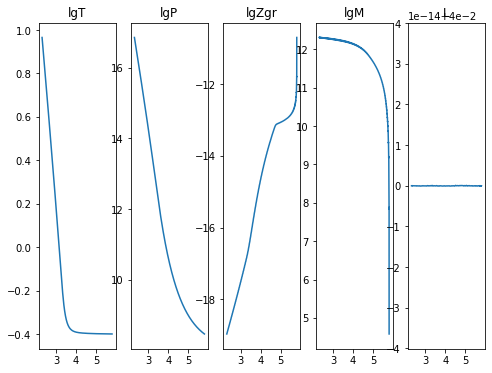

2020-11-16 04:12:34,483 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:12:35,607 __main__ 0/1 INFO :: Perturbation norm: 1.6720751473262518
2020-11-16 04:12:35,609 __main__ 0/1 INFO :: lgT iterate: 0.965684908089494
2020-11-16 04:12:35,609 __main__ 0/1 INFO :: lgP iterate: 16.85032943387851
2020-11-16 04:12:35,610 __main__ 0/1 INFO :: lgM iterate: 12.278414437714192
2020-11-16 04:12:35,611 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331184386
2020-11-16 04:12:35,612 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:12:35,613 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


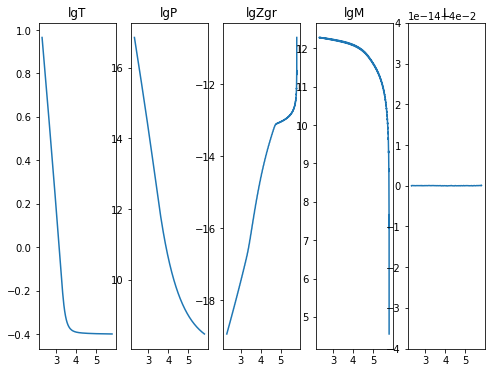

2020-11-16 04:12:39,486 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:12:40,763 __main__ 0/1 INFO :: Perturbation norm: 1.6720751473649047
2020-11-16 04:12:40,765 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:12:40,766 __main__ 0/1 INFO :: lgP iterate: 16.85129947116726
2020-11-16 04:12:40,767 __main__ 0/1 INFO :: lgM iterate: 12.306662613108815
2020-11-16 04:12:40,767 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506318
2020-11-16 04:12:40,768 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:12:40,769 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


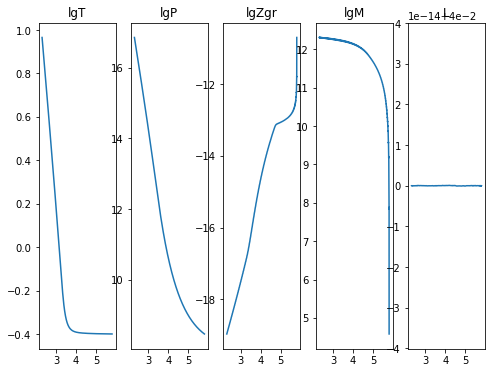

2020-11-16 04:12:45,218 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:12:46,399 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474035247
2020-11-16 04:12:46,401 __main__ 0/1 INFO :: lgT iterate: 0.965684908089494
2020-11-16 04:12:46,402 __main__ 0/1 INFO :: lgP iterate: 16.850329433878482
2020-11-16 04:12:46,402 __main__ 0/1 INFO :: lgM iterate: 12.278414437713309
2020-11-16 04:12:46,403 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183764
2020-11-16 04:12:46,404 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-11-16 04:12:46,406 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


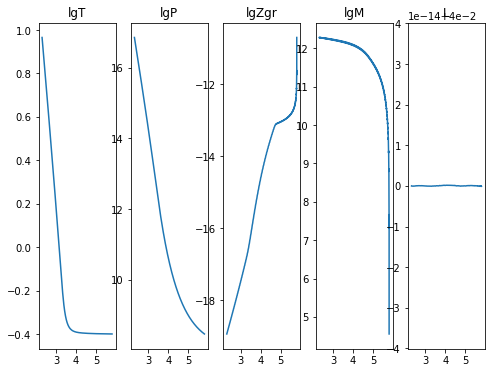

2020-11-16 04:12:50,475 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:12:51,666 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474204696
2020-11-16 04:12:51,667 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-11-16 04:12:51,668 __main__ 0/1 INFO :: lgP iterate: 16.851299471167263
2020-11-16 04:12:51,669 __main__ 0/1 INFO :: lgM iterate: 12.306662613108886
2020-11-16 04:12:51,670 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063236
2020-11-16 04:12:51,671 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-11-16 04:12:51,672 __main__ 0/1 INFO :: L iterate: 0.04


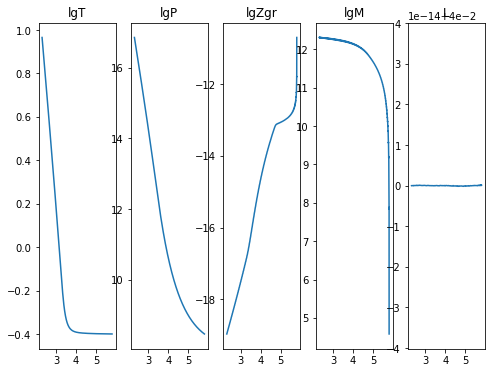

2020-11-16 04:12:55,734 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:12:56,914 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474371958
2020-11-16 04:12:56,915 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894934
2020-11-16 04:12:56,916 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-11-16 04:12:56,918 __main__ 0/1 INFO :: lgM iterate: 12.278414437712964
2020-11-16 04:12:56,919 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183523
2020-11-16 04:12:56,920 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:12:56,921 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


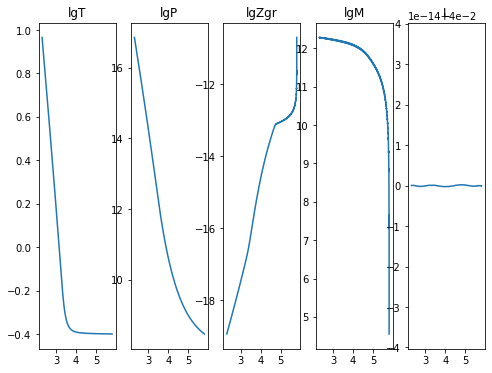

2020-11-16 04:13:00,963 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:13:02,253 __main__ 0/1 INFO :: Perturbation norm: 1.672075147444406
2020-11-16 04:13:02,254 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234045
2020-11-16 04:13:02,255 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:13:02,258 __main__ 0/1 INFO :: lgM iterate: 12.306662613109179
2020-11-16 04:13:02,259 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063446
2020-11-16 04:13:02,260 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:13:02,261 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


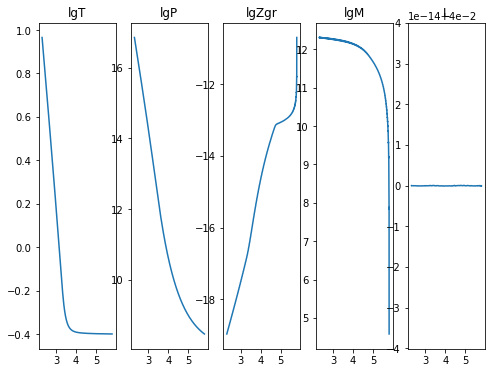

2020-11-16 04:13:06,785 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:13:08,289 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474517659
2020-11-16 04:13:08,290 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-11-16 04:13:08,291 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:13:08,292 __main__ 0/1 INFO :: lgM iterate: 12.278414437712769
2020-11-16 04:13:08,293 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183388
2020-11-16 04:13:08,294 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:13:08,295 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


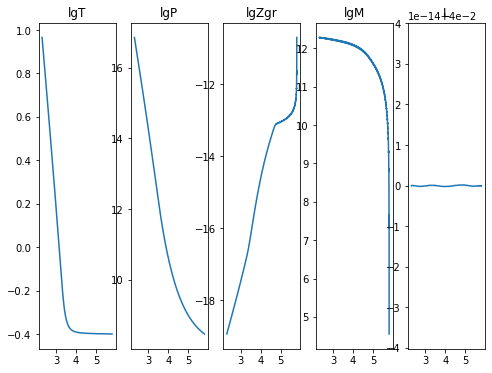

2020-11-16 04:13:12,915 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:13:14,308 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474545918
2020-11-16 04:13:14,309 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:13:14,310 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:13:14,311 __main__ 0/1 INFO :: lgM iterate: 12.306662613109296
2020-11-16 04:13:14,312 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506352
2020-11-16 04:13:14,313 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-11-16 04:13:14,314 __main__ 0/1 INFO :: L iterate: 0.04


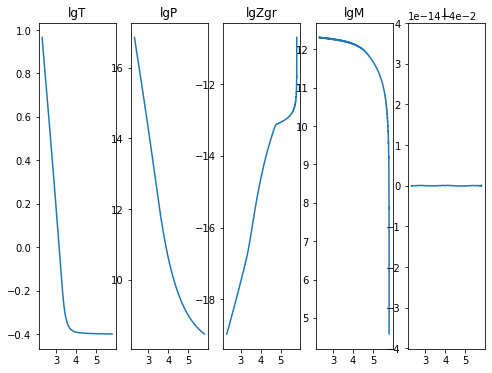

2020-11-16 04:13:18,684 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 04:13:20,076 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474572357
2020-11-16 04:13:20,077 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894976
2020-11-16 04:13:20,078 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:13:20,079 __main__ 0/1 INFO :: lgM iterate: 12.278414437712627
2020-11-16 04:13:20,080 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118329
2020-11-16 04:13:20,081 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:13:20,082 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


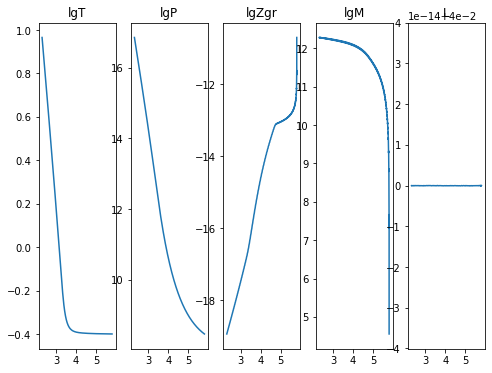

2020-11-16 04:13:23,979 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:13:25,364 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474588242
2020-11-16 04:13:25,365 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234033
2020-11-16 04:13:25,366 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:13:25,367 __main__ 0/1 INFO :: lgM iterate: 12.306662613109157
2020-11-16 04:13:25,368 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506343
2020-11-16 04:13:25,370 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-11-16 04:13:25,371 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


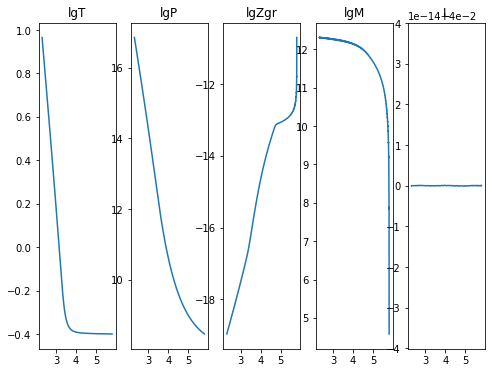

2020-11-16 04:13:29,351 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:13:30,473 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474603395
2020-11-16 04:13:30,475 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894964
2020-11-16 04:13:30,475 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:13:30,476 __main__ 0/1 INFO :: lgM iterate: 12.278414437712676
2020-11-16 04:13:30,477 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-11-16 04:13:30,478 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:13:30,479 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


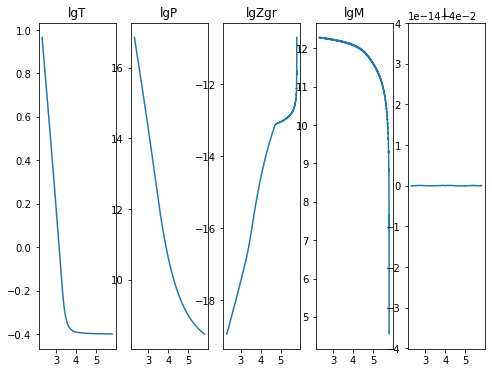

2020-11-16 04:13:34,545 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:13:35,967 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474608393
2020-11-16 04:13:35,968 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-11-16 04:13:35,970 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:13:35,971 __main__ 0/1 INFO :: lgM iterate: 12.306662613109069
2020-11-16 04:13:35,972 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063368
2020-11-16 04:13:35,973 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:13:35,974 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


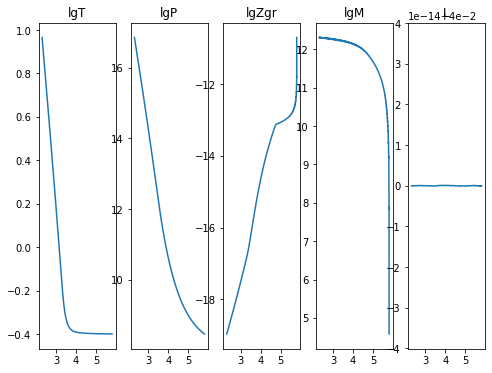

2020-11-16 04:13:39,979 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:13:41,100 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461345
2020-11-16 04:13:41,101 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894951
2020-11-16 04:13:41,102 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:13:41,103 __main__ 0/1 INFO :: lgM iterate: 12.278414437712645
2020-11-16 04:13:41,104 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-11-16 04:13:41,105 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-11-16 04:13:41,106 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


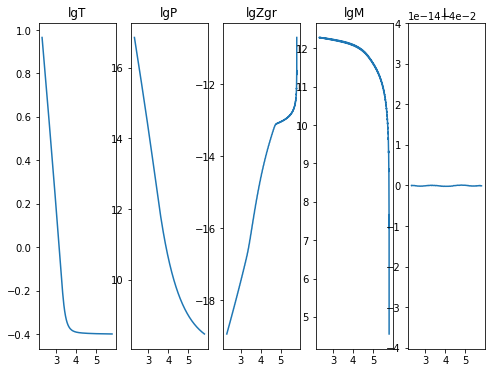

2020-11-16 04:13:44,926 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:13:46,233 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746106
2020-11-16 04:13:46,234 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:13:46,235 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:13:46,236 __main__ 0/1 INFO :: lgM iterate: 12.306662613109161
2020-11-16 04:13:46,236 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506344
2020-11-16 04:13:46,237 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-11-16 04:13:46,238 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


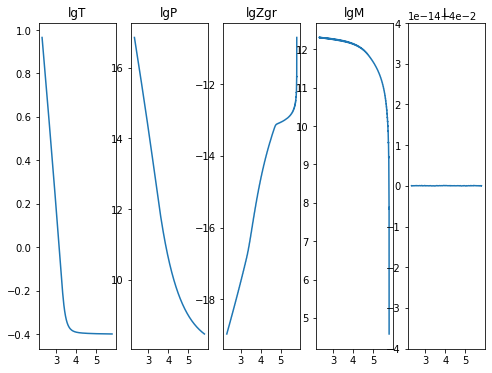

2020-11-16 04:13:50,263 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:13:51,391 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474609106
2020-11-16 04:13:51,392 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-11-16 04:13:51,393 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:13:51,394 __main__ 0/1 INFO :: lgM iterate: 12.278414437712634
2020-11-16 04:13:51,395 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-11-16 04:13:51,396 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-11-16 04:13:51,397 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


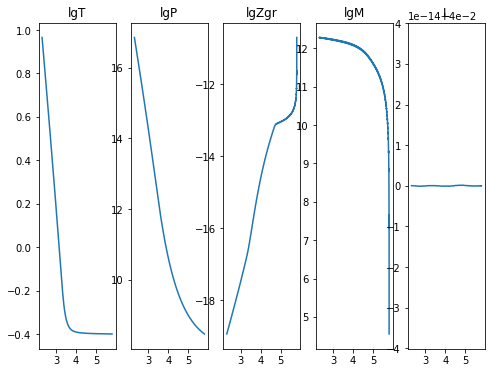

2020-11-16 04:13:55,467 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:13:56,630 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474608442
2020-11-16 04:13:56,631 __main__ 0/1 INFO :: lgT iterate: 0.965671625123404
2020-11-16 04:13:56,632 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-11-16 04:13:56,633 __main__ 0/1 INFO :: lgM iterate: 12.306662613109138
2020-11-16 04:13:56,634 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506342
2020-11-16 04:13:56,635 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-11-16 04:13:56,636 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


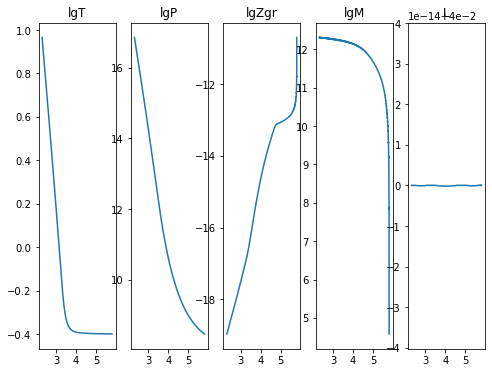

2020-11-16 04:14:00,735 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:14:01,962 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474609172
2020-11-16 04:14:01,963 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-11-16 04:14:01,964 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:14:01,965 __main__ 0/1 INFO :: lgM iterate: 12.278414437712673
2020-11-16 04:14:01,966 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118332
2020-11-16 04:14:01,967 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-11-16 04:14:01,968 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


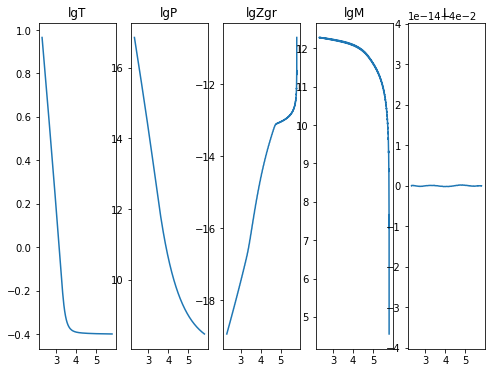

2020-11-16 04:14:05,987 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:14:07,163 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613142
2020-11-16 04:14:07,164 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:14:07,165 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:14:07,166 __main__ 0/1 INFO :: lgM iterate: 12.30666261310925
2020-11-16 04:14:07,168 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063492
2020-11-16 04:14:07,169 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-11-16 04:14:07,170 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


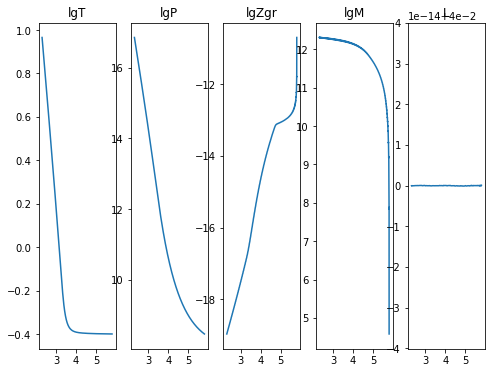

2020-11-16 04:14:11,220 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:14:12,448 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615874
2020-11-16 04:14:12,449 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894955
2020-11-16 04:14:12,450 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-11-16 04:14:12,451 __main__ 0/1 INFO :: lgM iterate: 12.278414437712621
2020-11-16 04:14:12,453 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183285
2020-11-16 04:14:12,454 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:14:12,455 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


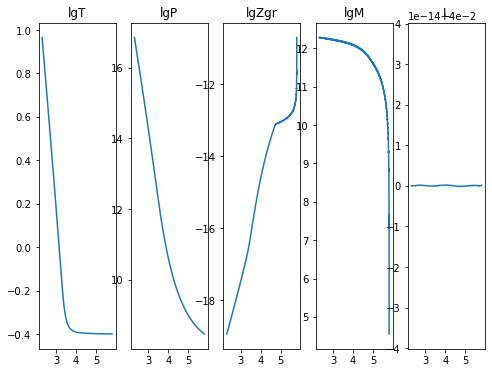

2020-11-16 04:14:16,505 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:14:17,693 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461486
2020-11-16 04:14:17,694 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-11-16 04:14:17,695 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-11-16 04:14:17,696 __main__ 0/1 INFO :: lgM iterate: 12.30666261310914
2020-11-16 04:14:17,697 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506342
2020-11-16 04:14:17,698 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-11-16 04:14:17,699 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


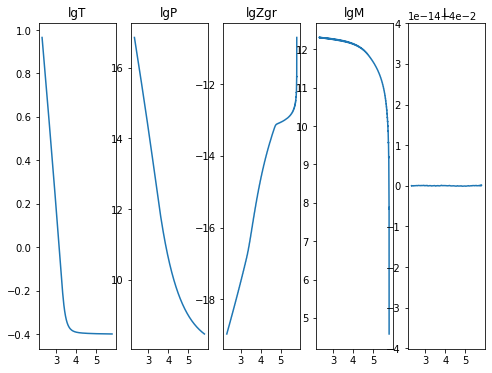

2020-11-16 04:14:21,815 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:14:23,062 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614426
2020-11-16 04:14:23,064 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-11-16 04:14:23,065 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:14:23,065 __main__ 0/1 INFO :: lgM iterate: 12.278414437712708
2020-11-16 04:14:23,066 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183345
2020-11-16 04:14:23,067 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-11-16 04:14:23,068 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


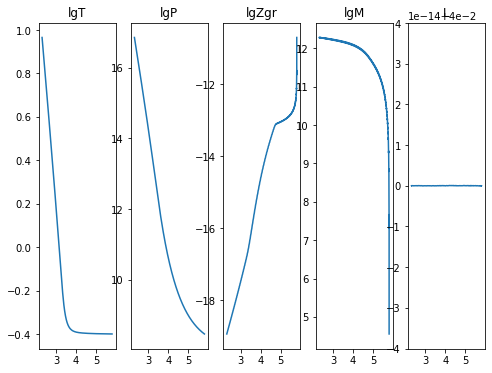

2020-11-16 04:14:27,590 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-11-16 04:14:28,929 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620976
2020-11-16 04:14:28,930 __main__ 0/1 INFO :: lgT iterate: 0.965671625123407
2020-11-16 04:14:28,931 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:14:28,932 __main__ 0/1 INFO :: lgM iterate: 12.306662613109289
2020-11-16 04:14:28,932 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063524
2020-11-16 04:14:28,934 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:14:28,934 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


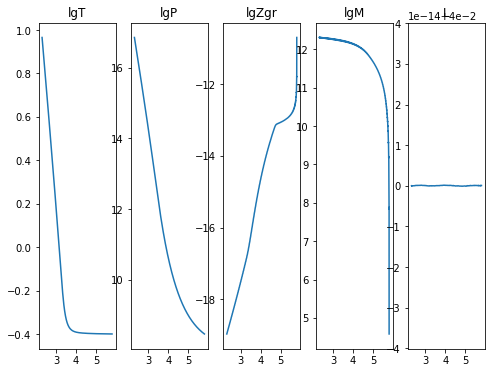

2020-11-16 04:14:33,071 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:14:34,252 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474626085
2020-11-16 04:14:34,254 __main__ 0/1 INFO :: lgT iterate: 0.965684908089494
2020-11-16 04:14:34,255 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:14:34,256 __main__ 0/1 INFO :: lgM iterate: 12.278414437712666
2020-11-16 04:14:34,257 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118332
2020-11-16 04:14:34,259 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-11-16 04:14:34,260 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


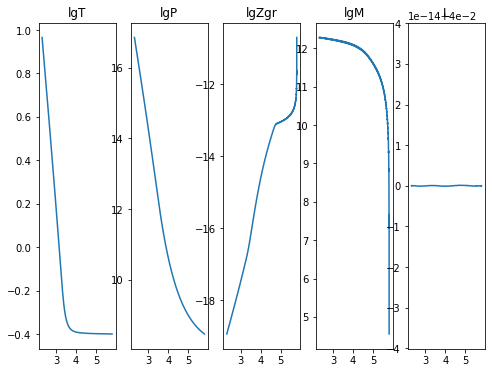

2020-11-16 04:14:38,882 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:14:40,491 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624873
2020-11-16 04:14:40,492 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234035
2020-11-16 04:14:40,493 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:14:40,494 __main__ 0/1 INFO :: lgM iterate: 12.306662613109147
2020-11-16 04:14:40,495 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-11-16 04:14:40,496 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:14:40,497 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


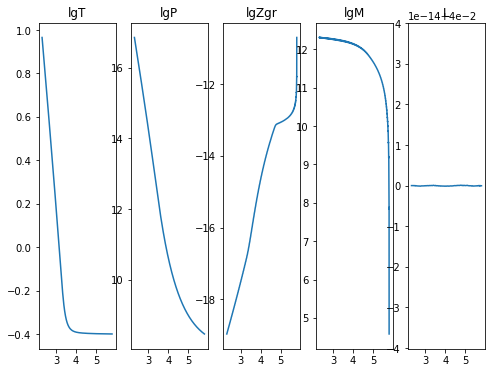

2020-11-16 04:14:45,055 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:14:46,487 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462189
2020-11-16 04:14:46,489 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-11-16 04:14:46,490 __main__ 0/1 INFO :: lgP iterate: 16.85032943387847
2020-11-16 04:14:46,491 __main__ 0/1 INFO :: lgM iterate: 12.278414437712728
2020-11-16 04:14:46,492 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183363
2020-11-16 04:14:46,493 __main__ 0/1 INFO :: m iterate: 1.6098110161788526e-05
2020-11-16 04:14:46,495 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


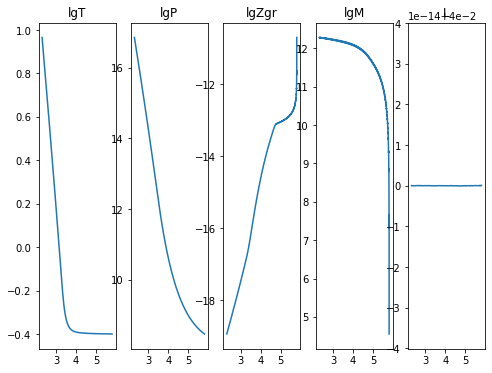

2020-11-16 04:14:50,887 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:14:52,043 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622348
2020-11-16 04:14:52,045 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:14:52,046 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:14:52,047 __main__ 0/1 INFO :: lgM iterate: 12.30666261310921
2020-11-16 04:14:52,048 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-11-16 04:14:52,049 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:14:52,050 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


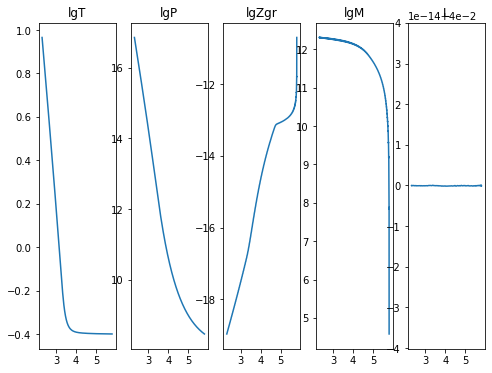

2020-11-16 04:14:55,904 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:14:57,067 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462396
2020-11-16 04:14:57,068 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894961
2020-11-16 04:14:57,069 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:14:57,070 __main__ 0/1 INFO :: lgM iterate: 12.278414437712623
2020-11-16 04:14:57,071 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-11-16 04:14:57,072 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-11-16 04:14:57,073 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


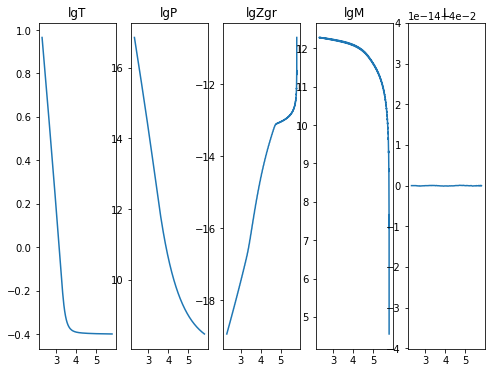

2020-11-16 04:15:00,975 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:15:02,236 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620763
2020-11-16 04:15:02,237 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-11-16 04:15:02,238 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:15:02,239 __main__ 0/1 INFO :: lgM iterate: 12.30666261310919
2020-11-16 04:15:02,240 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-11-16 04:15:02,241 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:15:02,241 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


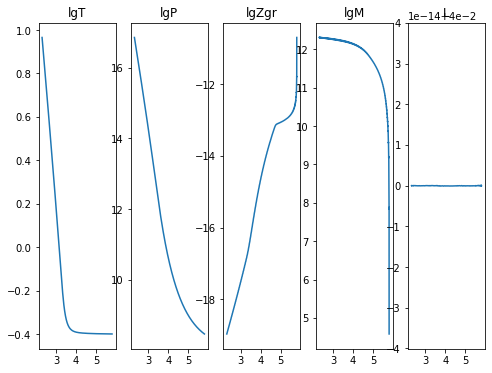

2020-11-16 04:15:06,481 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:15:07,901 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618378
2020-11-16 04:15:07,902 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894945
2020-11-16 04:15:07,903 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:15:07,904 __main__ 0/1 INFO :: lgM iterate: 12.278414437712762
2020-11-16 04:15:07,905 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118338
2020-11-16 04:15:07,906 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:15:07,907 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


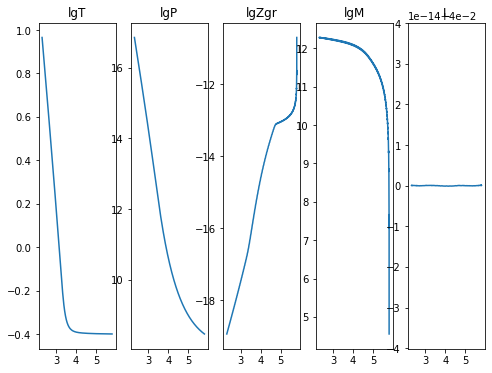

2020-11-16 04:15:12,367 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:15:13,677 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616504
2020-11-16 04:15:13,678 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234029
2020-11-16 04:15:13,679 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:15:13,680 __main__ 0/1 INFO :: lgM iterate: 12.306662613109264
2020-11-16 04:15:13,681 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063503
2020-11-16 04:15:13,682 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:15:13,683 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


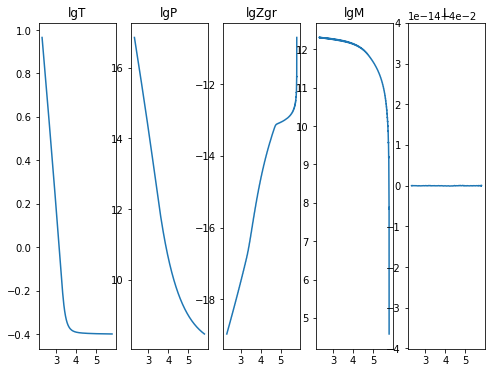

2020-11-16 04:15:17,945 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:15:19,207 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615307
2020-11-16 04:15:19,208 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-11-16 04:15:19,209 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:15:19,210 __main__ 0/1 INFO :: lgM iterate: 12.278414437712687
2020-11-16 04:15:19,211 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183327
2020-11-16 04:15:19,212 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:15:19,213 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


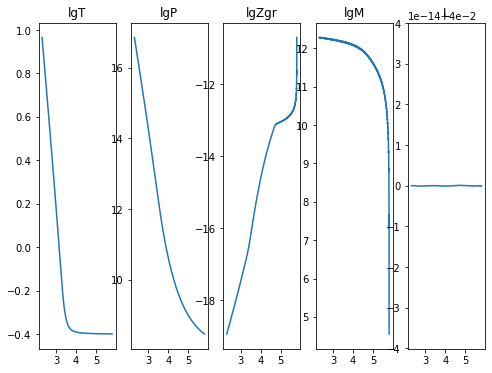

2020-11-16 04:15:23,290 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:15:24,433 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618052
2020-11-16 04:15:24,435 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:15:24,436 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:15:24,436 __main__ 0/1 INFO :: lgM iterate: 12.306662613109246
2020-11-16 04:15:24,437 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063485
2020-11-16 04:15:24,438 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:15:24,439 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


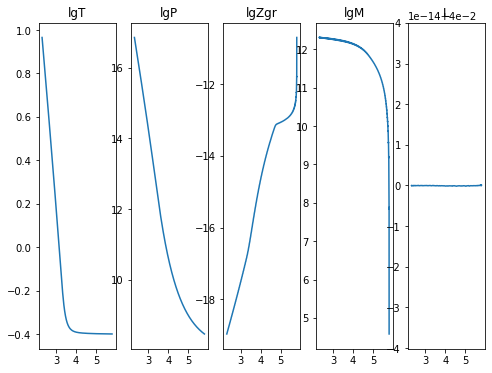

2020-11-16 04:15:28,569 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:15:30,123 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619835
2020-11-16 04:15:30,124 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-11-16 04:15:30,125 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:15:30,126 __main__ 0/1 INFO :: lgM iterate: 12.278414437712653
2020-11-16 04:15:30,131 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-11-16 04:15:30,135 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:15:30,136 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


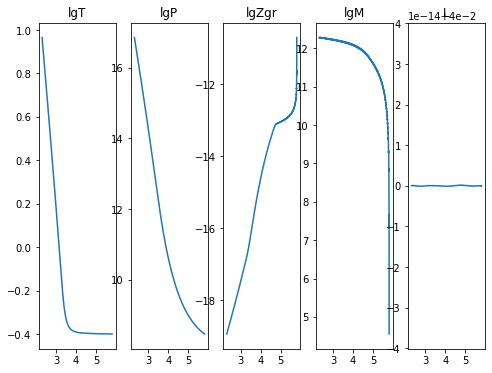

2020-11-16 04:15:35,321 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:15:36,644 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621869
2020-11-16 04:15:36,647 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:15:36,650 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:15:36,655 __main__ 0/1 INFO :: lgM iterate: 12.306662613109136
2020-11-16 04:15:36,660 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-11-16 04:15:36,664 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:15:36,668 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


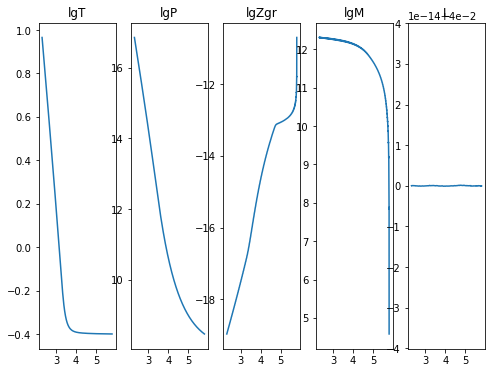

2020-11-16 04:15:40,670 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:15:42,092 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622664
2020-11-16 04:15:42,093 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-11-16 04:15:42,095 __main__ 0/1 INFO :: lgP iterate: 16.850329433878454
2020-11-16 04:15:42,096 __main__ 0/1 INFO :: lgM iterate: 12.278414437712607
2020-11-16 04:15:42,097 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-11-16 04:15:42,098 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-11-16 04:15:42,099 __main__ 0/1 INFO :: L iterate: 0.04


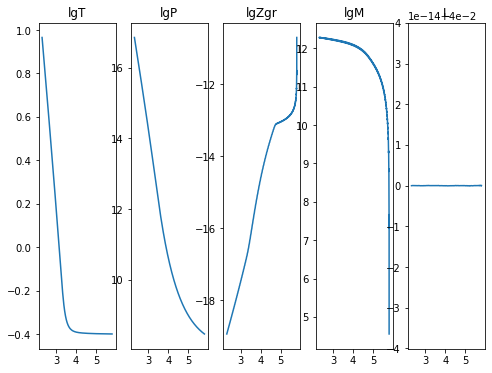

2020-11-16 04:15:47,243 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:15:48,691 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621962
2020-11-16 04:15:48,694 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-11-16 04:15:48,697 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:15:48,700 __main__ 0/1 INFO :: lgM iterate: 12.306662613109193
2020-11-16 04:15:48,702 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-11-16 04:15:48,705 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:15:48,708 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


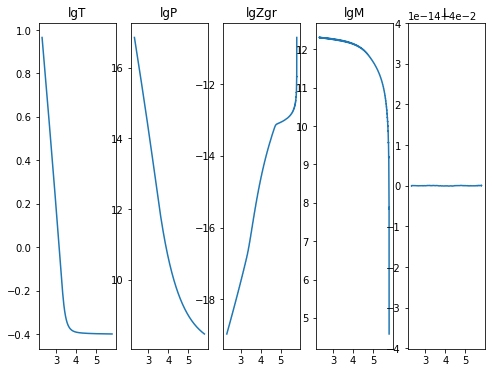

2020-11-16 04:15:53,944 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:15:55,352 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622424
2020-11-16 04:15:55,354 __main__ 0/1 INFO :: lgT iterate: 0.965684908089493
2020-11-16 04:15:55,355 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:15:55,356 __main__ 0/1 INFO :: lgM iterate: 12.278414437712769
2020-11-16 04:15:55,357 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183388
2020-11-16 04:15:55,359 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-11-16 04:15:55,360 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


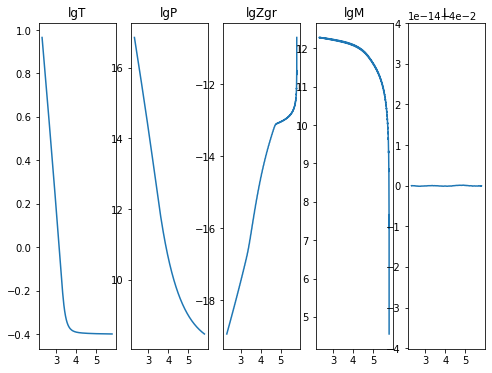

2020-11-16 04:16:00,773 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:16:02,012 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474626157
2020-11-16 04:16:02,014 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234042
2020-11-16 04:16:02,015 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:16:02,016 __main__ 0/1 INFO :: lgM iterate: 12.306662613109232
2020-11-16 04:16:02,017 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063485
2020-11-16 04:16:02,018 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:16:02,019 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


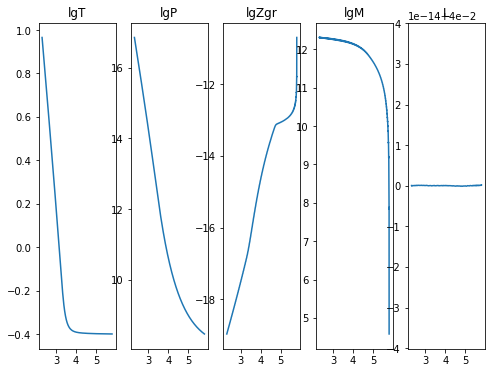

2020-11-16 04:16:06,833 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:16:08,070 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474626856
2020-11-16 04:16:08,072 __main__ 0/1 INFO :: lgT iterate: 0.965684908089496
2020-11-16 04:16:08,073 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:16:08,074 __main__ 0/1 INFO :: lgM iterate: 12.278414437712605
2020-11-16 04:16:08,074 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183274
2020-11-16 04:16:08,076 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:16:08,078 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


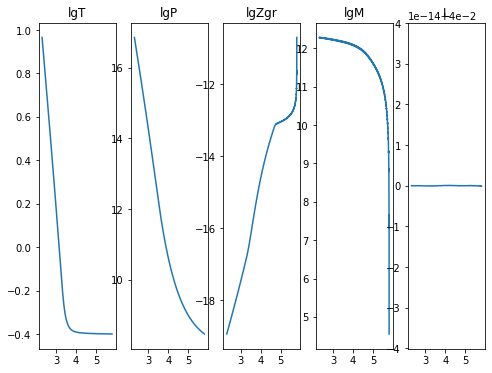

2020-11-16 04:16:13,390 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:16:14,676 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623199
2020-11-16 04:16:14,678 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:16:14,679 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:16:14,680 __main__ 0/1 INFO :: lgM iterate: 12.306662613109133
2020-11-16 04:16:14,681 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-11-16 04:16:14,682 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-11-16 04:16:14,683 __main__ 0/1 INFO :: L iterate: 0.04


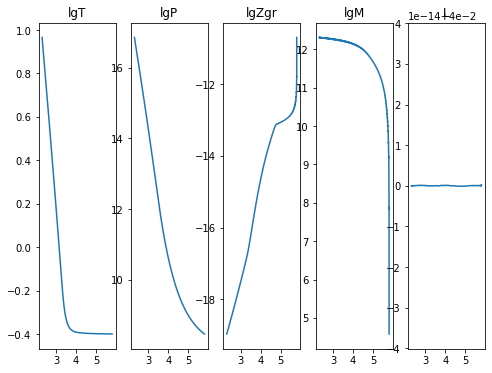

2020-11-16 04:16:18,646 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:16:19,839 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462204
2020-11-16 04:16:19,840 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894969
2020-11-16 04:16:19,841 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:16:19,843 __main__ 0/1 INFO :: lgM iterate: 12.278414437712652
2020-11-16 04:16:19,844 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-11-16 04:16:19,845 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-11-16 04:16:19,846 __main__ 0/1 INFO :: L iterate: 0.04


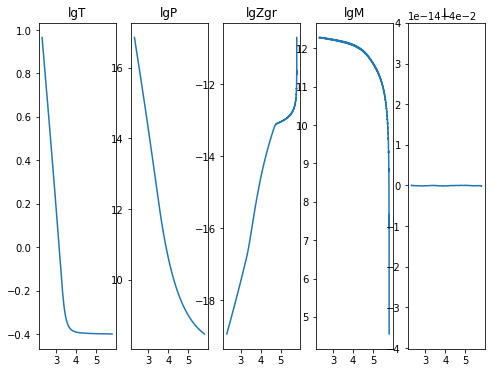

2020-11-16 04:16:23,925 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:16:25,429 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623043
2020-11-16 04:16:25,430 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:16:25,431 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:16:25,432 __main__ 0/1 INFO :: lgM iterate: 12.306662613109252
2020-11-16 04:16:25,433 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150635
2020-11-16 04:16:25,435 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:16:25,436 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


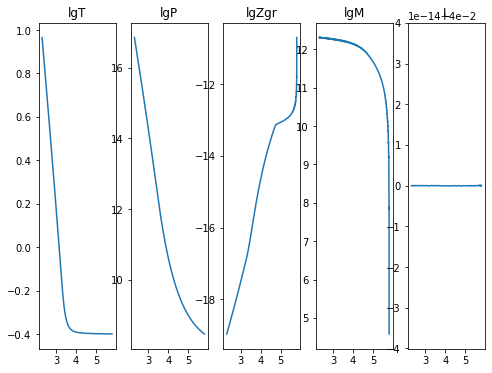

2020-11-16 04:16:29,844 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:16:31,169 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624456
2020-11-16 04:16:31,173 __main__ 0/1 INFO :: lgT iterate: 0.965684908089496
2020-11-16 04:16:31,175 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:16:31,178 __main__ 0/1 INFO :: lgM iterate: 12.278414437712685
2020-11-16 04:16:31,180 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183338
2020-11-16 04:16:31,183 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:16:31,186 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


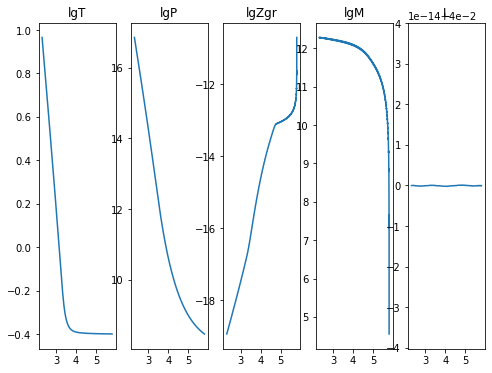

2020-11-16 04:16:34,843 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:16:36,080 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619397
2020-11-16 04:16:36,081 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-11-16 04:16:36,082 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:16:36,083 __main__ 0/1 INFO :: lgM iterate: 12.306662613109184
2020-11-16 04:16:36,084 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506345
2020-11-16 04:16:36,085 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:16:36,086 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


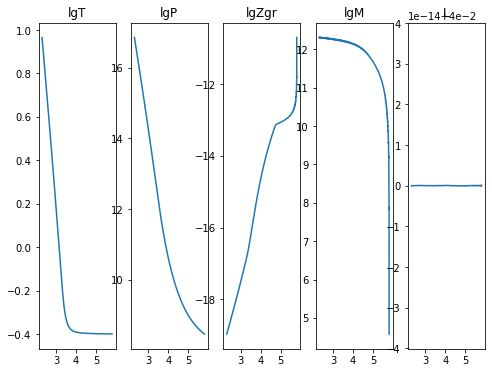

2020-11-16 04:16:39,820 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:16:41,368 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614841
2020-11-16 04:16:41,369 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-11-16 04:16:41,370 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:16:41,371 __main__ 0/1 INFO :: lgM iterate: 12.27841443771269
2020-11-16 04:16:41,372 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183334
2020-11-16 04:16:41,373 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:16:41,374 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


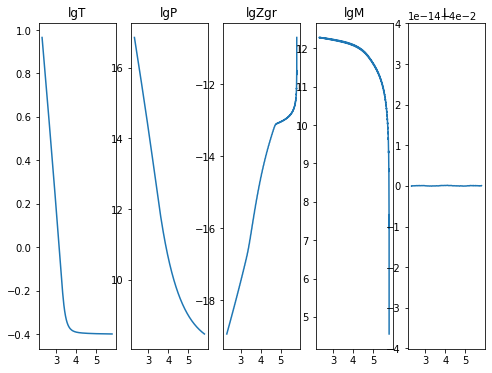

2020-11-16 04:16:45,813 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:16:46,912 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619475
2020-11-16 04:16:46,913 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234015
2020-11-16 04:16:46,914 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:16:46,915 __main__ 0/1 INFO :: lgM iterate: 12.30666261310914
2020-11-16 04:16:46,916 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506342
2020-11-16 04:16:46,917 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-11-16 04:16:46,918 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


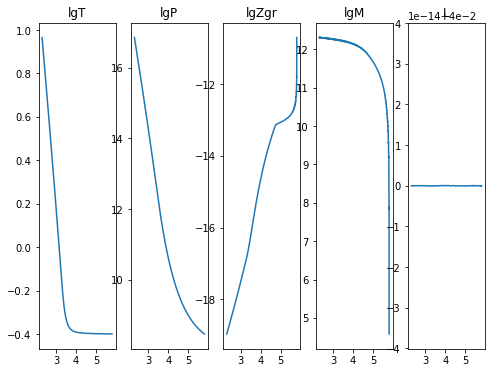

2020-11-16 04:16:50,809 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:16:52,008 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624742
2020-11-16 04:16:52,009 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894953
2020-11-16 04:16:52,010 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:16:52,011 __main__ 0/1 INFO :: lgM iterate: 12.278414437712694
2020-11-16 04:16:52,012 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183338
2020-11-16 04:16:52,013 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-11-16 04:16:52,014 __main__ 0/1 INFO :: L iterate: 0.04


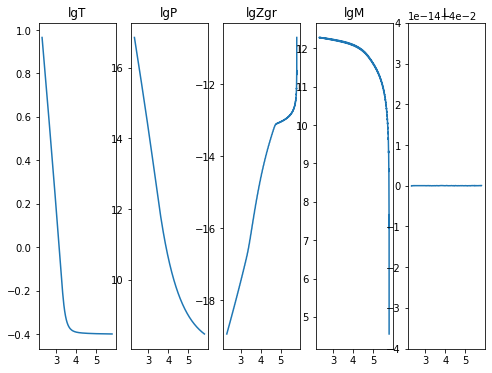

2020-11-16 04:16:55,902 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:16:57,106 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624258
2020-11-16 04:16:57,107 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234047
2020-11-16 04:16:57,108 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:16:57,109 __main__ 0/1 INFO :: lgM iterate: 12.306662613109117
2020-11-16 04:16:57,110 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063407
2020-11-16 04:16:57,111 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:16:57,112 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


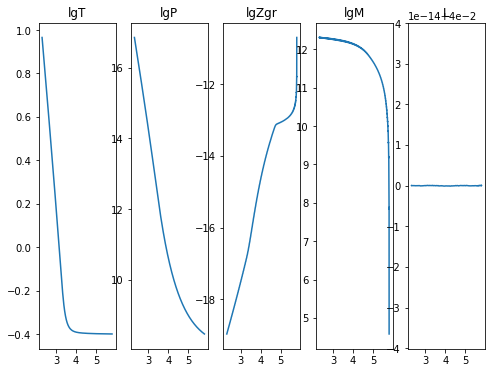

2020-11-16 04:17:01,275 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:17:02,481 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621858
2020-11-16 04:17:02,483 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894953
2020-11-16 04:17:02,484 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:17:02,485 __main__ 0/1 INFO :: lgM iterate: 12.27841443771267
2020-11-16 04:17:02,485 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118332
2020-11-16 04:17:02,487 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-11-16 04:17:02,488 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


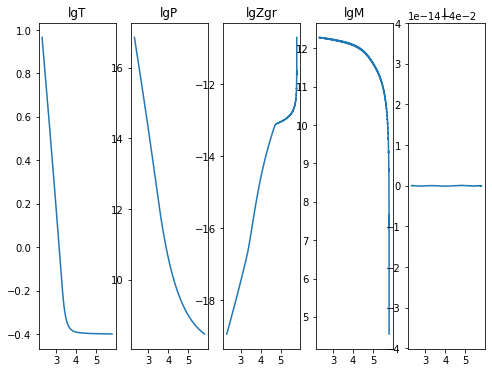

2020-11-16 04:17:06,577 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:17:07,926 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622353
2020-11-16 04:17:07,927 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-11-16 04:17:07,929 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:17:07,930 __main__ 0/1 INFO :: lgM iterate: 12.30666261310925
2020-11-16 04:17:07,931 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150635
2020-11-16 04:17:07,932 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:17:07,933 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


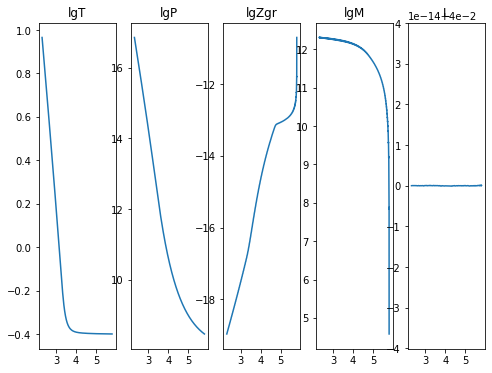

2020-11-16 04:17:13,287 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:17:14,906 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622815
2020-11-16 04:17:14,907 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894945
2020-11-16 04:17:14,908 __main__ 0/1 INFO :: lgP iterate: 16.850329433878454
2020-11-16 04:17:14,909 __main__ 0/1 INFO :: lgM iterate: 12.278414437712602
2020-11-16 04:17:14,911 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118327
2020-11-16 04:17:14,913 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:17:14,915 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


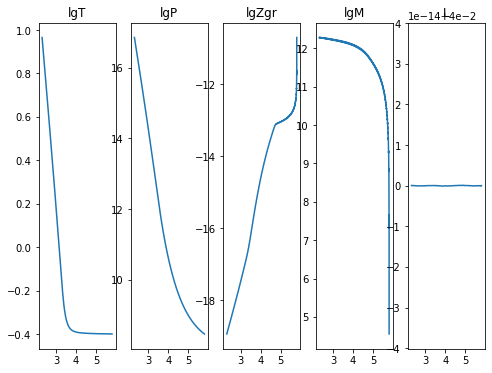

2020-11-16 04:17:19,581 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:17:20,805 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623354
2020-11-16 04:17:20,807 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234027
2020-11-16 04:17:20,808 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:17:20,808 __main__ 0/1 INFO :: lgM iterate: 12.306662613109118
2020-11-16 04:17:20,809 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-11-16 04:17:20,810 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:17:20,811 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


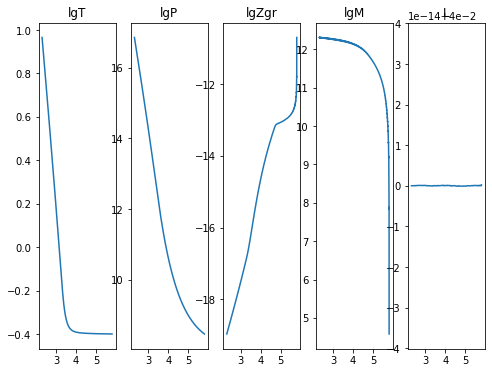

2020-11-16 04:17:25,460 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:17:26,746 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623325
2020-11-16 04:17:26,748 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894939
2020-11-16 04:17:26,749 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:17:26,749 __main__ 0/1 INFO :: lgM iterate: 12.278414437712614
2020-11-16 04:17:26,750 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-11-16 04:17:26,752 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-11-16 04:17:26,752 __main__ 0/1 INFO :: L iterate: 0.04


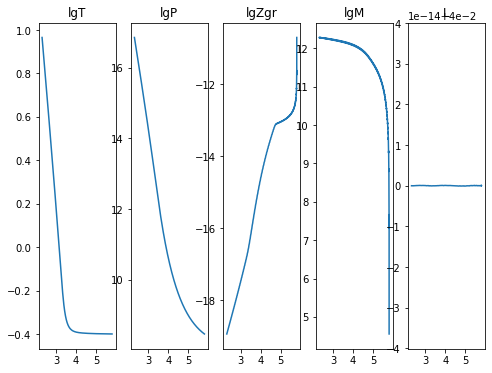

2020-11-16 04:17:31,014 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:17:32,324 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618452
2020-11-16 04:17:32,326 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-11-16 04:17:32,327 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:17:32,328 __main__ 0/1 INFO :: lgM iterate: 12.306662613109193
2020-11-16 04:17:32,329 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-11-16 04:17:32,330 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-11-16 04:17:32,331 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


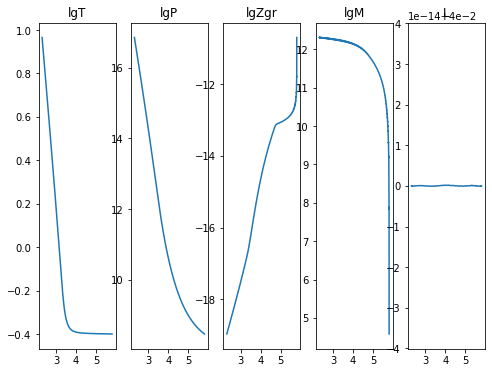

2020-11-16 04:17:36,298 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:17:37,639 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615279
2020-11-16 04:17:37,641 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-11-16 04:17:37,642 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:17:37,643 __main__ 0/1 INFO :: lgM iterate: 12.278414437712673
2020-11-16 04:17:37,644 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-11-16 04:17:37,645 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:17:37,646 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


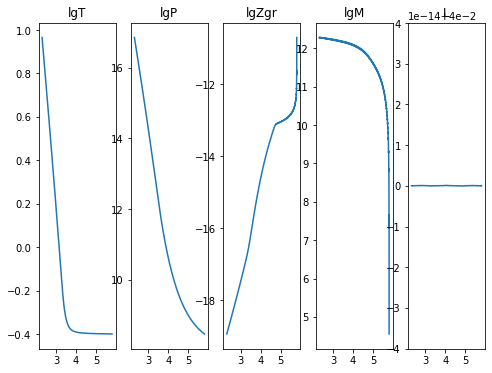

2020-11-16 04:17:42,781 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-11-16 04:17:44,253 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615887
2020-11-16 04:17:44,255 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234047
2020-11-16 04:17:44,255 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:17:44,256 __main__ 0/1 INFO :: lgM iterate: 12.306662613109133
2020-11-16 04:17:44,257 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-11-16 04:17:44,258 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:17:44,259 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


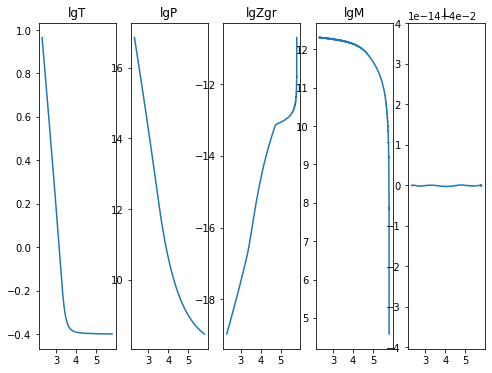

2020-11-16 04:17:49,109 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:17:50,667 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614917
2020-11-16 04:17:50,672 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-11-16 04:17:50,676 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-11-16 04:17:50,679 __main__ 0/1 INFO :: lgM iterate: 12.278414437712653
2020-11-16 04:17:50,682 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-11-16 04:17:50,684 __main__ 0/1 INFO :: m iterate: 1.6098110160900347e-05
2020-11-16 04:17:50,684 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


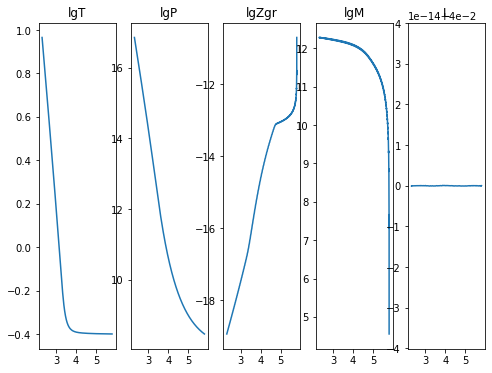

2020-11-16 04:17:55,038 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:17:56,462 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474611109
2020-11-16 04:17:56,464 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234027
2020-11-16 04:17:56,465 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-11-16 04:17:56,466 __main__ 0/1 INFO :: lgM iterate: 12.3066626131091
2020-11-16 04:17:56,467 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506339
2020-11-16 04:17:56,468 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-11-16 04:17:56,469 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


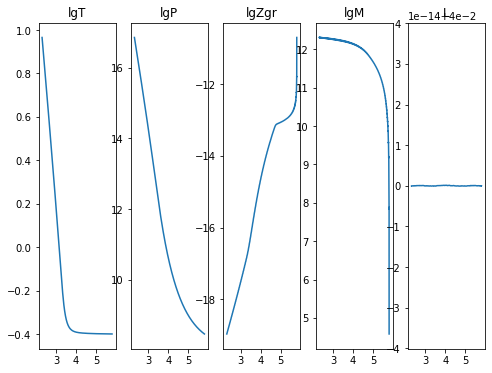

2020-11-16 04:18:00,785 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:18:01,943 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474609175
2020-11-16 04:18:01,944 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894978
2020-11-16 04:18:01,945 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-11-16 04:18:01,946 __main__ 0/1 INFO :: lgM iterate: 12.278414437712717
2020-11-16 04:18:01,947 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183352
2020-11-16 04:18:01,948 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:18:01,949 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


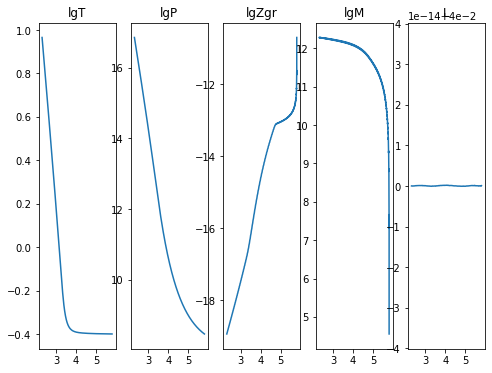

2020-11-16 04:18:05,755 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:18:06,884 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474610631
2020-11-16 04:18:06,885 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234049
2020-11-16 04:18:06,886 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:18:06,887 __main__ 0/1 INFO :: lgM iterate: 12.306662613109143
2020-11-16 04:18:06,888 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506343
2020-11-16 04:18:06,889 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:18:06,890 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


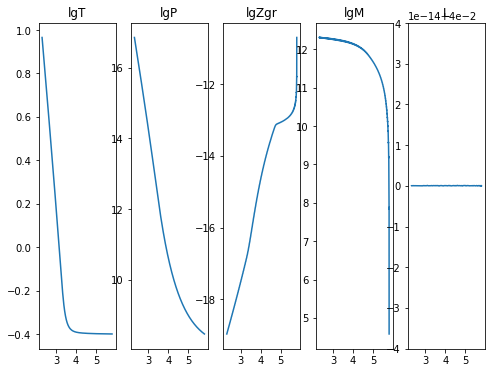

2020-11-16 04:18:10,752 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:18:11,922 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474609663
2020-11-16 04:18:11,924 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894957
2020-11-16 04:18:11,924 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:18:11,925 __main__ 0/1 INFO :: lgM iterate: 12.278414437712616
2020-11-16 04:18:11,926 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183285
2020-11-16 04:18:11,927 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:18:11,928 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


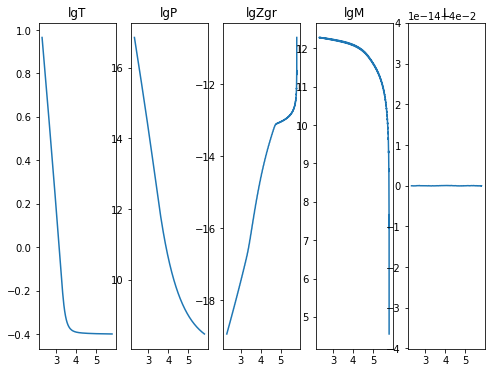

2020-11-16 04:18:15,667 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:18:16,737 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613977
2020-11-16 04:18:16,738 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234052
2020-11-16 04:18:16,739 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:18:16,740 __main__ 0/1 INFO :: lgM iterate: 12.306662613109149
2020-11-16 04:18:16,740 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-11-16 04:18:16,742 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-11-16 04:18:16,742 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


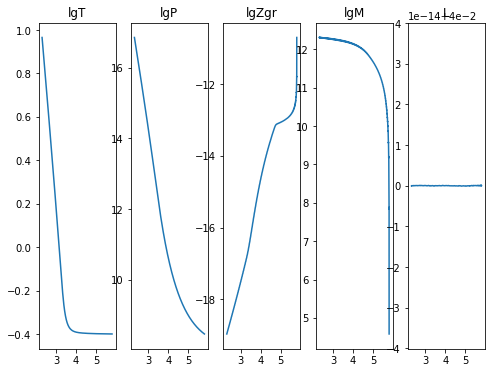

2020-11-16 04:18:20,501 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:18:21,532 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461951
2020-11-16 04:18:21,533 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894931
2020-11-16 04:18:21,534 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:18:21,535 __main__ 0/1 INFO :: lgM iterate: 12.278414437712645
2020-11-16 04:18:21,536 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-11-16 04:18:21,537 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-11-16 04:18:21,538 __main__ 0/1 INFO :: L iterate: 0.04


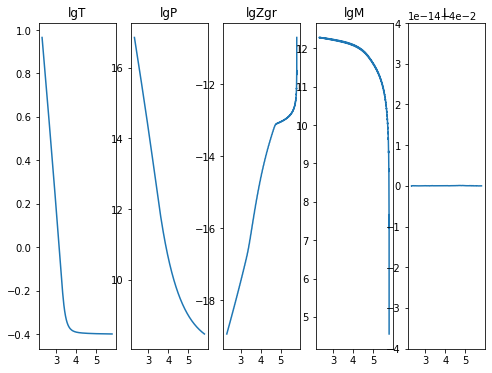

2020-11-16 04:18:25,251 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 04:18:26,476 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616282
2020-11-16 04:18:26,478 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234035
2020-11-16 04:18:26,479 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-11-16 04:18:26,479 __main__ 0/1 INFO :: lgM iterate: 12.306662613109083
2020-11-16 04:18:26,480 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506337
2020-11-16 04:18:26,481 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-11-16 04:18:26,482 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


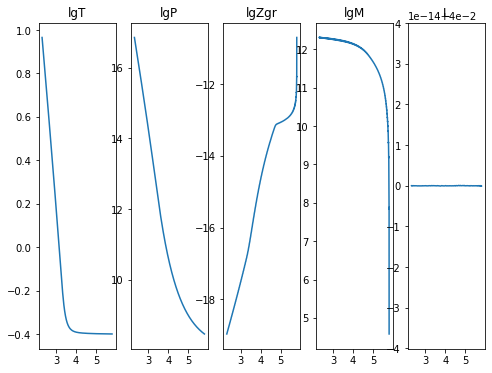

2020-11-16 04:18:31,302 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:18:32,662 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474612405
2020-11-16 04:18:32,663 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894964
2020-11-16 04:18:32,664 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:18:32,665 __main__ 0/1 INFO :: lgM iterate: 12.278414437712637
2020-11-16 04:18:32,666 __main__ 0/1 INFO :: lgZgr iterate: -18.9447523311833
2020-11-16 04:18:32,667 __main__ 0/1 INFO :: m iterate: 1.6098110156015366e-05
2020-11-16 04:18:32,668 __main__ 0/1 INFO :: L iterate: 0.04


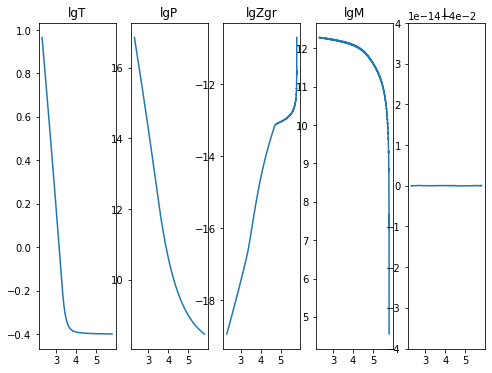

2020-11-16 04:18:36,997 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:18:38,163 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474609286
2020-11-16 04:18:38,164 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-11-16 04:18:38,165 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:18:38,166 __main__ 0/1 INFO :: lgM iterate: 12.306662613109195
2020-11-16 04:18:38,167 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063453
2020-11-16 04:18:38,168 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:18:38,169 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


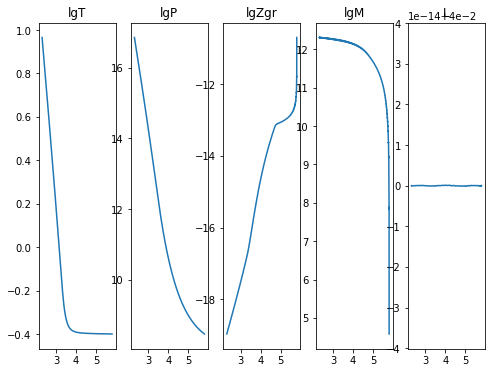

2020-11-16 04:18:42,840 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:18:44,641 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474605957
2020-11-16 04:18:44,642 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894944
2020-11-16 04:18:44,643 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:18:44,644 __main__ 0/1 INFO :: lgM iterate: 12.278414437712676
2020-11-16 04:18:44,645 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183327
2020-11-16 04:18:44,646 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-11-16 04:18:44,647 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


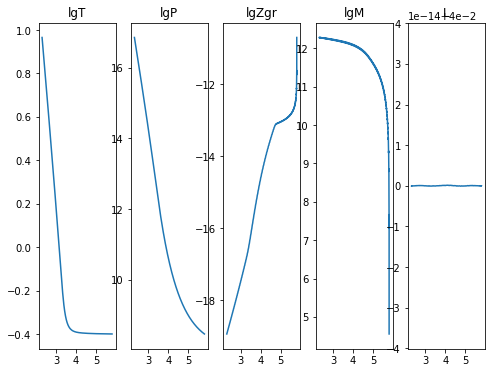

2020-11-16 04:18:48,840 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:18:50,050 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474609878
2020-11-16 04:18:50,051 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234021
2020-11-16 04:18:50,052 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:18:50,053 __main__ 0/1 INFO :: lgM iterate: 12.306662613109149
2020-11-16 04:18:50,055 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-11-16 04:18:50,057 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:18:50,058 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


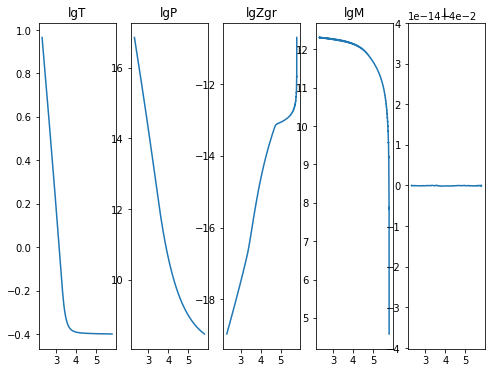

2020-11-16 04:18:56,969 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:18:58,752 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461297
2020-11-16 04:18:58,753 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894946
2020-11-16 04:18:58,754 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:18:58,756 __main__ 0/1 INFO :: lgM iterate: 12.278414437712632
2020-11-16 04:18:58,757 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-11-16 04:18:58,759 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:18:58,761 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


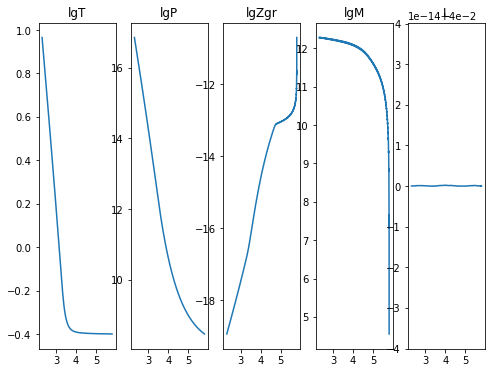

2020-11-16 04:19:03,890 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:19:05,233 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619335
2020-11-16 04:19:05,235 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-11-16 04:19:05,236 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:19:05,237 __main__ 0/1 INFO :: lgM iterate: 12.306662613109214
2020-11-16 04:19:05,238 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-11-16 04:19:05,239 __main__ 0/1 INFO :: m iterate: 1.61140138423832e-05
2020-11-16 04:19:05,240 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


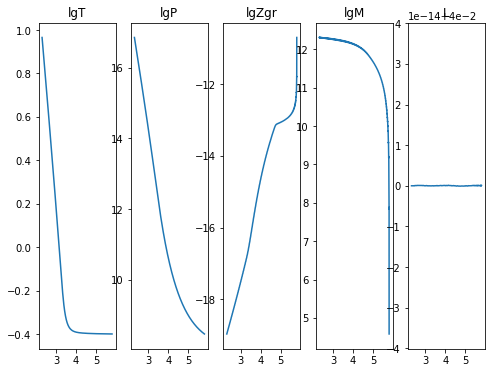

2020-11-16 04:19:10,264 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:19:11,605 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623738
2020-11-16 04:19:11,606 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894948
2020-11-16 04:19:11,607 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:19:11,608 __main__ 0/1 INFO :: lgM iterate: 12.278414437712609
2020-11-16 04:19:11,609 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183274
2020-11-16 04:19:11,610 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-11-16 04:19:11,611 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


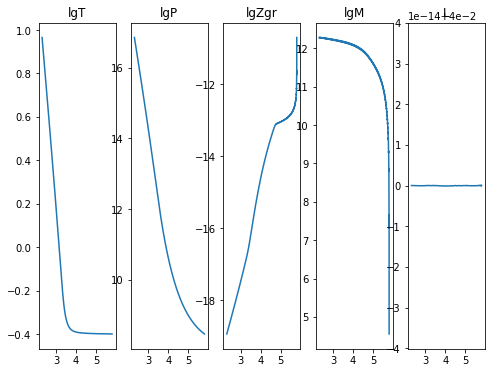

2020-11-16 04:19:16,466 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:19:17,933 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618696
2020-11-16 04:19:17,934 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-11-16 04:19:17,935 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:19:17,936 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-11-16 04:19:17,937 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506346
2020-11-16 04:19:17,938 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-11-16 04:19:17,939 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


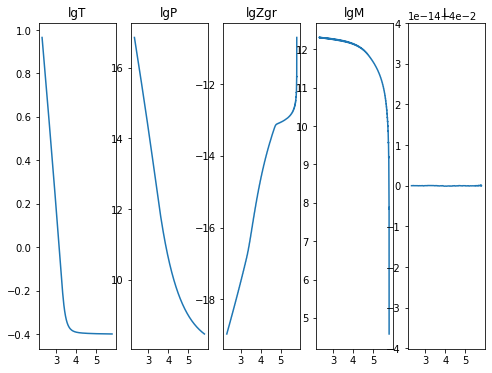

2020-11-16 04:19:22,887 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:19:24,609 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615212
2020-11-16 04:19:24,610 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894977
2020-11-16 04:19:24,611 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:19:24,612 __main__ 0/1 INFO :: lgM iterate: 12.278414437712595
2020-11-16 04:19:24,613 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118326
2020-11-16 04:19:24,614 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:19:24,615 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


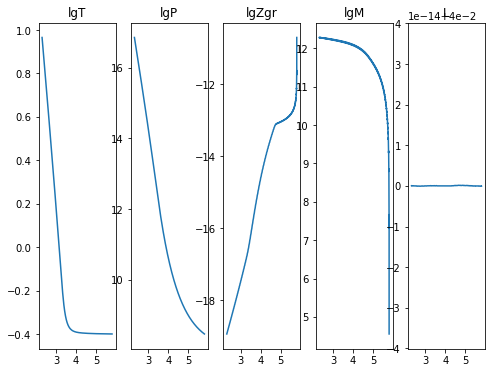

2020-11-16 04:19:29,490 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:19:30,830 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461503
2020-11-16 04:19:30,831 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-11-16 04:19:30,833 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:19:30,834 __main__ 0/1 INFO :: lgM iterate: 12.30666261310909
2020-11-16 04:19:30,835 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506339
2020-11-16 04:19:30,836 __main__ 0/1 INFO :: m iterate: 1.61140138423832e-05
2020-11-16 04:19:30,837 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


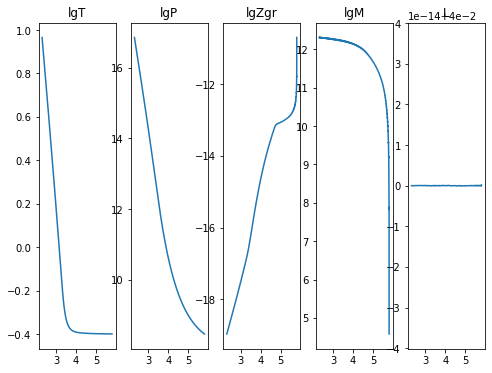

2020-11-16 04:19:35,636 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:19:37,126 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614464
2020-11-16 04:19:37,128 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-11-16 04:19:37,129 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-11-16 04:19:37,130 __main__ 0/1 INFO :: lgM iterate: 12.278414437712723
2020-11-16 04:19:37,131 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183352
2020-11-16 04:19:37,132 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-11-16 04:19:37,134 __main__ 0/1 INFO :: L iterate: 0.04


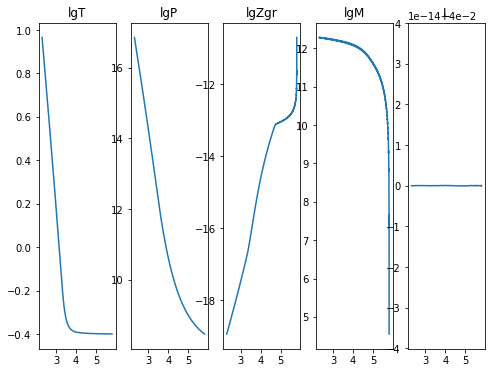

2020-11-16 04:19:41,329 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:19:42,417 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613893
2020-11-16 04:19:42,418 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-11-16 04:19:42,419 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:19:42,420 __main__ 0/1 INFO :: lgM iterate: 12.306662613109218
2020-11-16 04:19:42,421 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063474
2020-11-16 04:19:42,422 __main__ 0/1 INFO :: m iterate: 1.6114013836165952e-05
2020-11-16 04:19:42,422 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


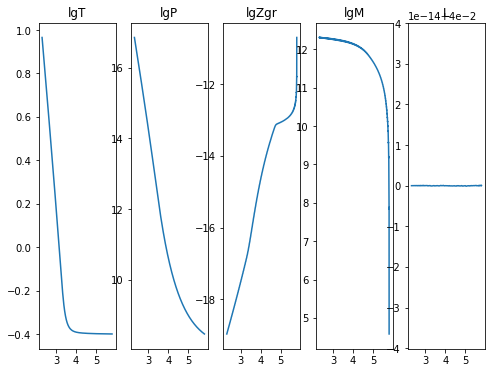

2020-11-16 04:19:46,116 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:19:47,398 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615567
2020-11-16 04:19:47,399 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-11-16 04:19:47,400 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-11-16 04:19:47,401 __main__ 0/1 INFO :: lgM iterate: 12.27841443771268
2020-11-16 04:19:47,401 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183327
2020-11-16 04:19:47,402 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:19:47,403 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


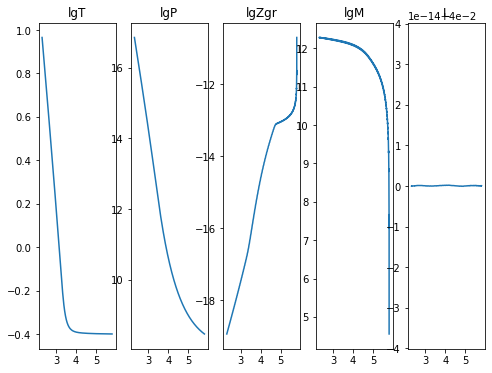

2020-11-16 04:19:51,982 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:19:53,153 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746151
2020-11-16 04:19:53,154 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-11-16 04:19:53,156 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:19:53,157 __main__ 0/1 INFO :: lgM iterate: 12.306662613109262
2020-11-16 04:19:53,159 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063506
2020-11-16 04:19:53,160 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:19:53,162 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


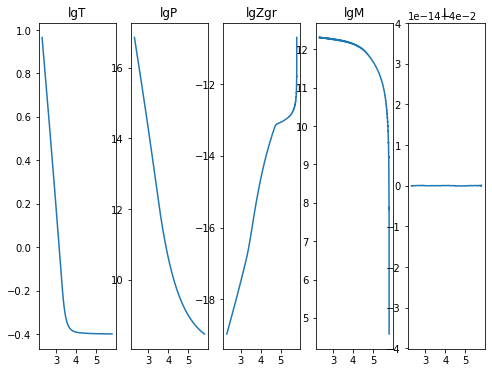

2020-11-16 04:19:57,807 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:19:59,299 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614184
2020-11-16 04:19:59,300 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894945
2020-11-16 04:19:59,307 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:19:59,310 __main__ 0/1 INFO :: lgM iterate: 12.278414437712746
2020-11-16 04:19:59,314 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183366
2020-11-16 04:19:59,315 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-11-16 04:19:59,324 __main__ 0/1 INFO :: L iterate: 0.04


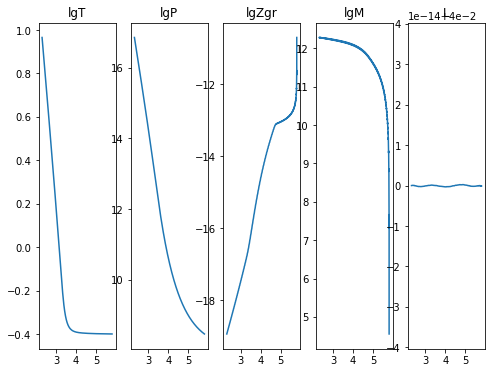

2020-11-16 04:20:03,700 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:20:04,928 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461978
2020-11-16 04:20:04,934 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234049
2020-11-16 04:20:04,935 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:20:04,936 __main__ 0/1 INFO :: lgM iterate: 12.306662613109118
2020-11-16 04:20:04,937 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063407
2020-11-16 04:20:04,938 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-11-16 04:20:04,939 __main__ 0/1 INFO :: L iterate: 0.04


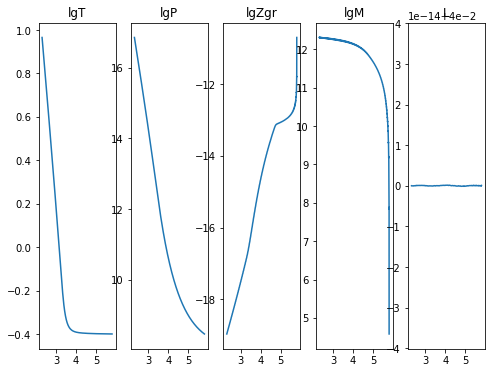

2020-11-16 04:20:09,046 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:20:10,258 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462459
2020-11-16 04:20:10,259 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-11-16 04:20:10,260 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:20:10,262 __main__ 0/1 INFO :: lgM iterate: 12.278414437712659
2020-11-16 04:20:10,263 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-11-16 04:20:10,264 __main__ 0/1 INFO :: m iterate: 1.6098110161788526e-05
2020-11-16 04:20:10,265 __main__ 0/1 INFO :: L iterate: 0.04


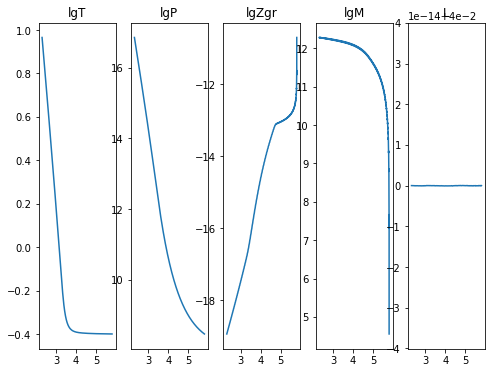

2020-11-16 04:20:14,261 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:20:15,440 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623103
2020-11-16 04:20:15,442 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-11-16 04:20:15,443 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:20:15,444 __main__ 0/1 INFO :: lgM iterate: 12.306662613109062
2020-11-16 04:20:15,445 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063364
2020-11-16 04:20:15,447 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:20:15,448 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


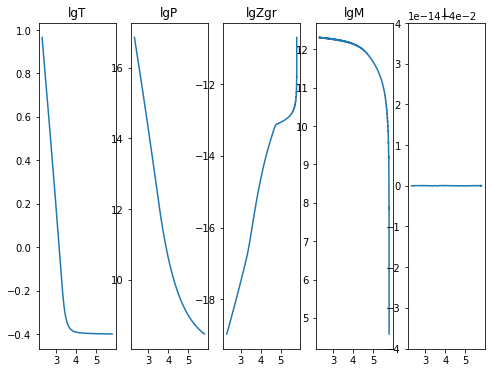

2020-11-16 04:20:19,638 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:20:20,837 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622684
2020-11-16 04:20:20,838 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-11-16 04:20:20,839 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:20:20,840 __main__ 0/1 INFO :: lgM iterate: 12.27841443771265
2020-11-16 04:20:20,841 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-11-16 04:20:20,842 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:20:20,843 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


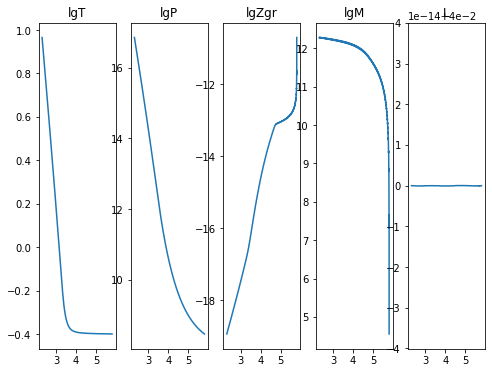

2020-11-16 04:20:25,070 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:20:26,365 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621385
2020-11-16 04:20:26,366 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:20:26,367 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:20:26,368 __main__ 0/1 INFO :: lgM iterate: 12.306662613109122
2020-11-16 04:20:26,369 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-11-16 04:20:26,370 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-11-16 04:20:26,370 __main__ 0/1 INFO :: L iterate: 0.04


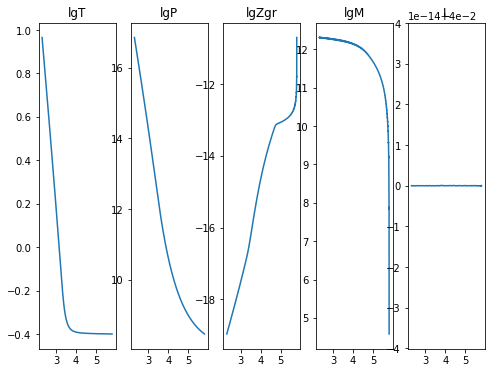

2020-11-16 04:20:30,600 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:20:32,004 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619622
2020-11-16 04:20:32,006 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894946
2020-11-16 04:20:32,007 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:20:32,008 __main__ 0/1 INFO :: lgM iterate: 12.278414437712733
2020-11-16 04:20:32,009 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118336
2020-11-16 04:20:32,010 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:20:32,011 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


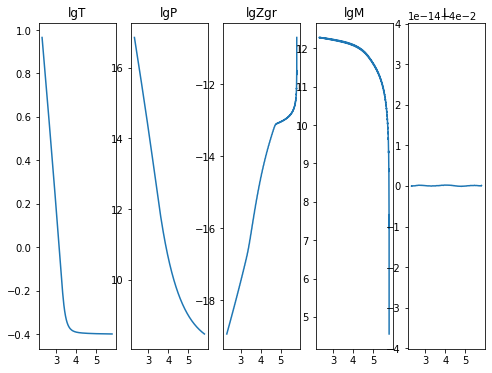

2020-11-16 04:20:36,708 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:20:38,117 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624473
2020-11-16 04:20:38,118 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-11-16 04:20:38,119 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:20:38,120 __main__ 0/1 INFO :: lgM iterate: 12.306662613109244
2020-11-16 04:20:38,121 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506349
2020-11-16 04:20:38,122 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:20:38,123 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


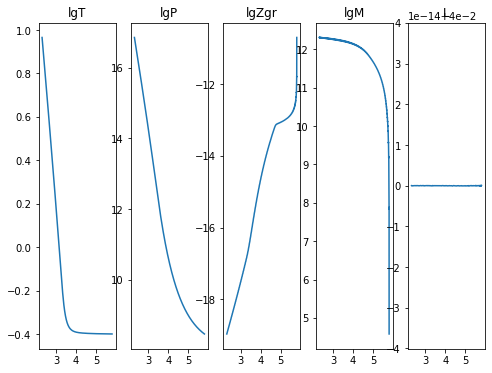

2020-11-16 04:20:42,988 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:20:44,685 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474628381
2020-11-16 04:20:44,689 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894951
2020-11-16 04:20:44,692 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:20:44,695 __main__ 0/1 INFO :: lgM iterate: 12.278414437712637
2020-11-16 04:20:44,699 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-11-16 04:20:44,703 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:20:44,707 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


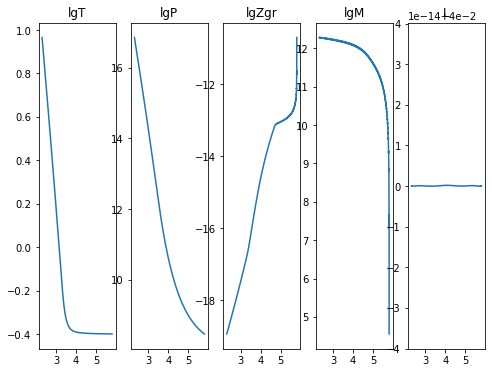

2020-11-16 04:20:49,139 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:20:50,342 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474626527
2020-11-16 04:20:50,343 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234049
2020-11-16 04:20:50,344 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:20:50,345 __main__ 0/1 INFO :: lgM iterate: 12.3066626131091
2020-11-16 04:20:50,346 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063392
2020-11-16 04:20:50,347 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:20:50,348 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


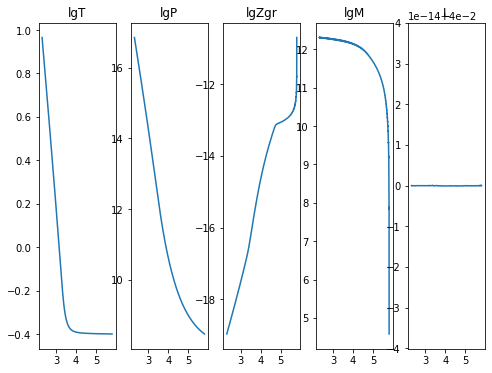

2020-11-16 04:20:54,936 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:20:56,443 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746253
2020-11-16 04:20:56,444 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-11-16 04:20:56,445 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:20:56,446 __main__ 0/1 INFO :: lgM iterate: 12.27841443771265
2020-11-16 04:20:56,447 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-11-16 04:20:56,449 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:20:56,450 __main__ 0/1 INFO :: L iterate: 0.04


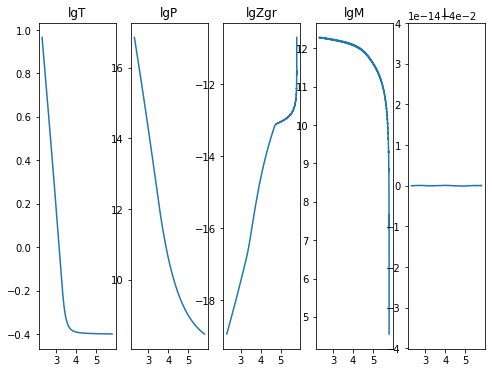

2020-11-16 04:21:00,899 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:21:02,220 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621478
2020-11-16 04:21:02,221 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234034
2020-11-16 04:21:02,222 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:21:02,223 __main__ 0/1 INFO :: lgM iterate: 12.306662613109072
2020-11-16 04:21:02,224 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506337
2020-11-16 04:21:02,225 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:21:02,226 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


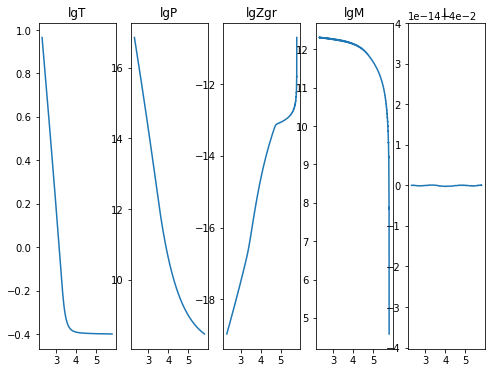

2020-11-16 04:21:06,494 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:21:07,701 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618736
2020-11-16 04:21:07,703 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894971
2020-11-16 04:21:07,704 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:21:07,705 __main__ 0/1 INFO :: lgM iterate: 12.278414437712662
2020-11-16 04:21:07,706 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-11-16 04:21:07,707 __main__ 0/1 INFO :: m iterate: 1.609811015423901e-05
2020-11-16 04:21:07,708 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


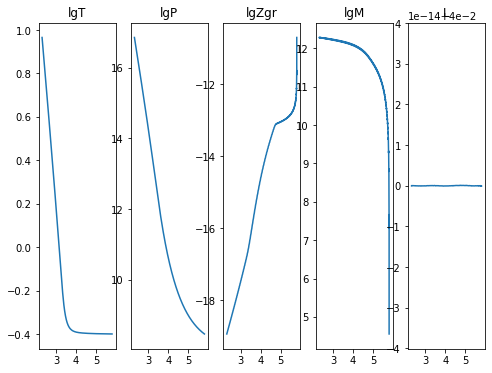

2020-11-16 04:21:12,335 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-11-16 04:21:13,804 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461824
2020-11-16 04:21:13,805 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:21:13,806 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:21:13,807 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-11-16 04:21:13,810 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-11-16 04:21:13,811 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:21:13,812 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


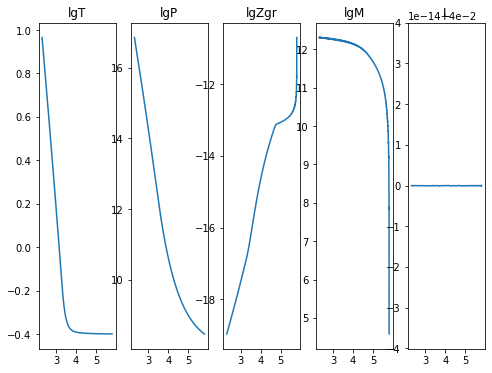

2020-11-16 04:21:18,153 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:21:19,575 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617703
2020-11-16 04:21:19,577 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894939
2020-11-16 04:21:19,579 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-11-16 04:21:19,580 __main__ 0/1 INFO :: lgM iterate: 12.278414437712673
2020-11-16 04:21:19,581 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183324
2020-11-16 04:21:19,582 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:21:19,583 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


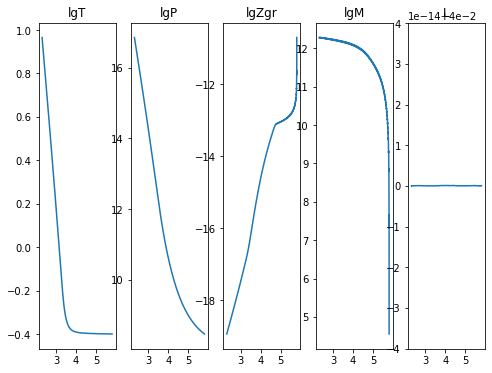

2020-11-16 04:21:24,608 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:21:25,959 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618147
2020-11-16 04:21:25,960 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:21:25,961 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:21:25,962 __main__ 0/1 INFO :: lgM iterate: 12.306662613109186
2020-11-16 04:21:25,963 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-11-16 04:21:25,965 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-11-16 04:21:25,966 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


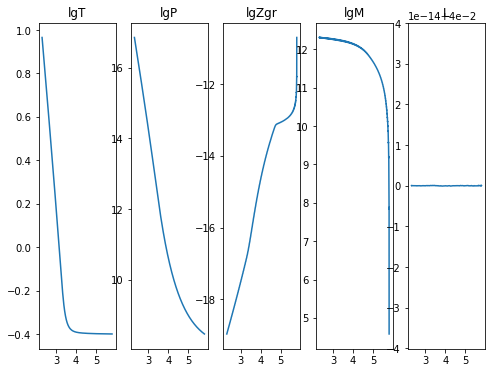

2020-11-16 04:21:30,245 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:21:31,375 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616733
2020-11-16 04:21:31,376 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894959
2020-11-16 04:21:31,377 __main__ 0/1 INFO :: lgP iterate: 16.85032943387847
2020-11-16 04:21:31,378 __main__ 0/1 INFO :: lgM iterate: 12.278414437712634
2020-11-16 04:21:31,379 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-11-16 04:21:31,380 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-11-16 04:21:31,381 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


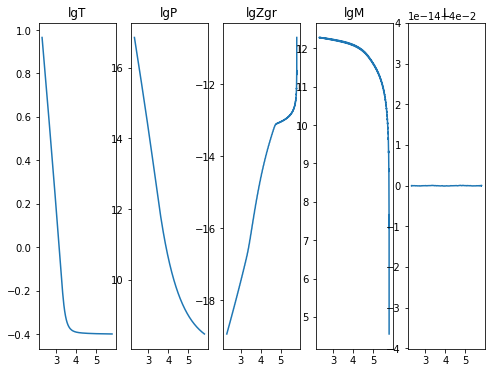

2020-11-16 04:21:35,222 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:21:36,358 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617974
2020-11-16 04:21:36,359 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:21:36,360 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:21:36,360 __main__ 0/1 INFO :: lgM iterate: 12.306662613109154
2020-11-16 04:21:36,361 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063435
2020-11-16 04:21:36,362 __main__ 0/1 INFO :: m iterate: 1.611401384327138e-05
2020-11-16 04:21:36,363 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


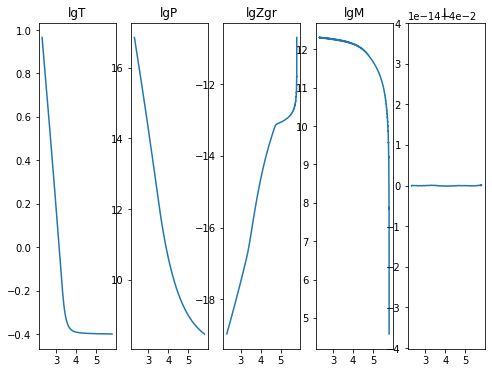

2020-11-16 04:21:40,529 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:21:42,324 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461889
2020-11-16 04:21:42,325 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-11-16 04:21:42,326 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:21:42,327 __main__ 0/1 INFO :: lgM iterate: 12.278414437712708
2020-11-16 04:21:42,327 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183352
2020-11-16 04:21:42,328 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:21:42,329 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


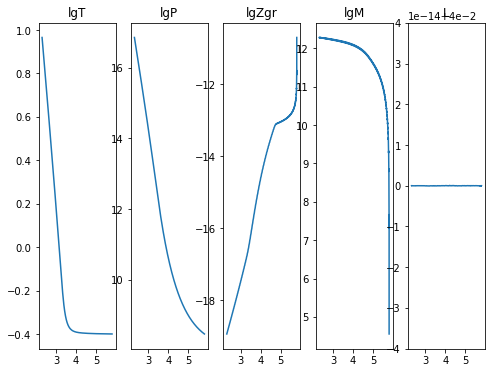

2020-11-16 04:21:46,771 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:21:48,172 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622528
2020-11-16 04:21:48,173 __main__ 0/1 INFO :: lgT iterate: 0.965671625123404
2020-11-16 04:21:48,174 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:21:48,175 __main__ 0/1 INFO :: lgM iterate: 12.306662613109154
2020-11-16 04:21:48,176 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063435
2020-11-16 04:21:48,177 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-11-16 04:21:48,177 __main__ 0/1 INFO :: L iterate: 0.04


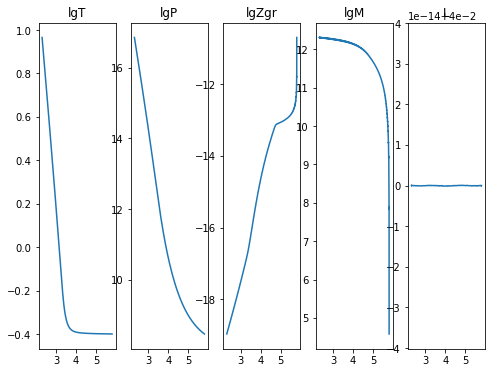

2020-11-16 04:21:53,101 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:21:54,597 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474627402
2020-11-16 04:21:54,599 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-11-16 04:21:54,599 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:21:54,600 __main__ 0/1 INFO :: lgM iterate: 12.278414437712698
2020-11-16 04:21:54,601 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183334
2020-11-16 04:21:54,602 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:21:54,603 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


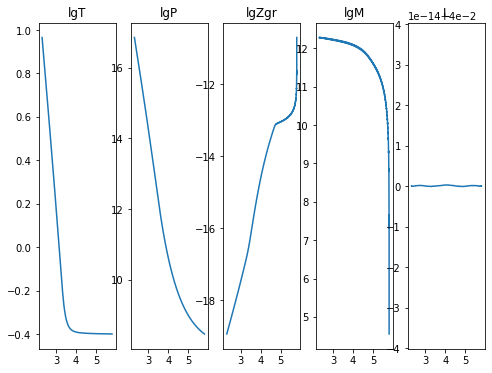

2020-11-16 04:21:58,685 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:22:00,035 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625903
2020-11-16 04:22:00,036 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-11-16 04:22:00,037 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:22:00,038 __main__ 0/1 INFO :: lgM iterate: 12.306662613109168
2020-11-16 04:22:00,039 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-11-16 04:22:00,040 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:22:00,041 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


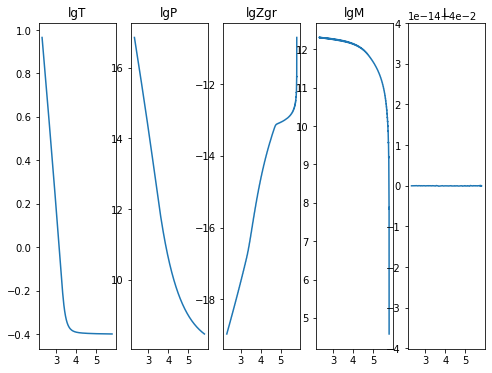

2020-11-16 04:22:04,442 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:22:05,653 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746231
2020-11-16 04:22:05,654 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894961
2020-11-16 04:22:05,655 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:22:05,656 __main__ 0/1 INFO :: lgM iterate: 12.278414437712655
2020-11-16 04:22:05,657 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-11-16 04:22:05,659 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-11-16 04:22:05,660 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


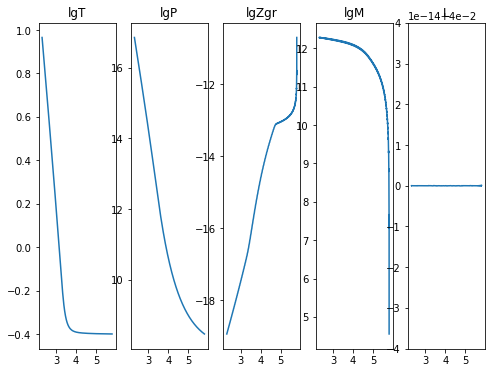

2020-11-16 04:22:10,740 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:22:12,103 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619253
2020-11-16 04:22:12,103 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-11-16 04:22:12,107 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:22:12,107 __main__ 0/1 INFO :: lgM iterate: 12.306662613109122
2020-11-16 04:22:12,113 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063407
2020-11-16 04:22:12,114 __main__ 0/1 INFO :: m iterate: 1.6114013833945506e-05
2020-11-16 04:22:12,114 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


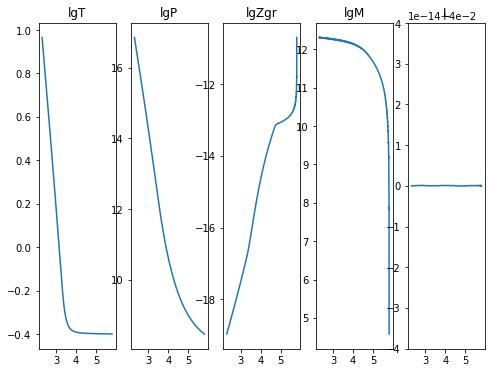

2020-11-16 04:22:16,051 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:22:17,157 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617068
2020-11-16 04:22:17,158 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894976
2020-11-16 04:22:17,159 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:22:17,159 __main__ 0/1 INFO :: lgM iterate: 12.278414437712627
2020-11-16 04:22:17,160 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118329
2020-11-16 04:22:17,161 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:22:17,162 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


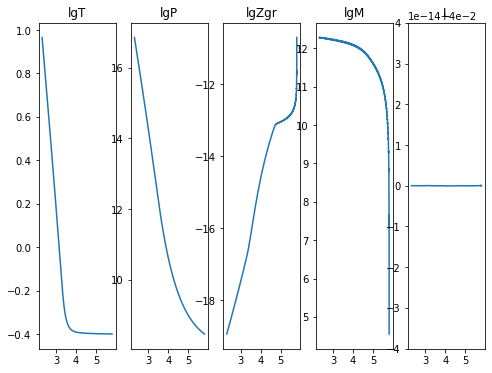

2020-11-16 04:22:20,826 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:22:21,995 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618591
2020-11-16 04:22:21,997 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-11-16 04:22:21,998 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:22:21,998 __main__ 0/1 INFO :: lgM iterate: 12.306662613109175
2020-11-16 04:22:21,999 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-11-16 04:22:22,000 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:22:22,001 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


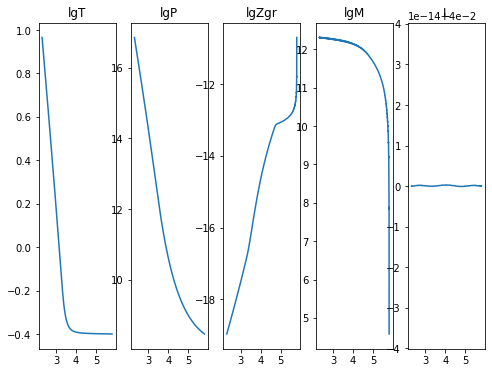

2020-11-16 04:22:25,713 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:22:26,779 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620719
2020-11-16 04:22:26,780 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894929
2020-11-16 04:22:26,781 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:22:26,782 __main__ 0/1 INFO :: lgM iterate: 12.278414437712707
2020-11-16 04:22:26,782 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183345
2020-11-16 04:22:26,784 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-11-16 04:22:26,784 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


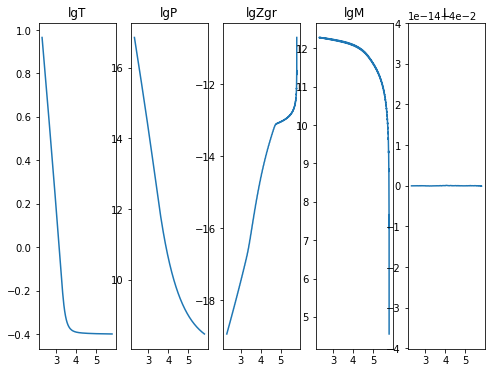

2020-11-16 04:22:30,404 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 04:22:31,466 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618563
2020-11-16 04:22:31,467 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234038
2020-11-16 04:22:31,468 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:22:31,469 __main__ 0/1 INFO :: lgM iterate: 12.306662613109115
2020-11-16 04:22:31,469 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-11-16 04:22:31,470 __main__ 0/1 INFO :: m iterate: 1.61140138423832e-05
2020-11-16 04:22:31,471 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


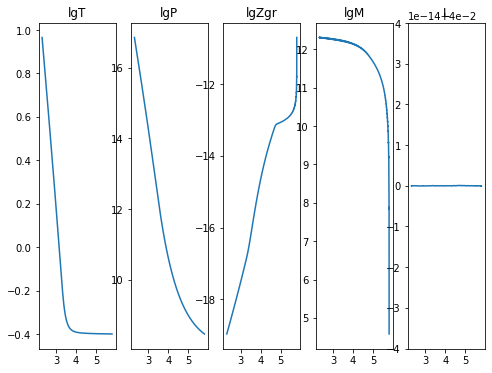

2020-11-16 04:22:35,101 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:22:36,279 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617086
2020-11-16 04:22:36,280 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894964
2020-11-16 04:22:36,281 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:22:36,281 __main__ 0/1 INFO :: lgM iterate: 12.27841443771268
2020-11-16 04:22:36,282 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183324
2020-11-16 04:22:36,283 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:22:36,284 __main__ 0/1 INFO :: L iterate: 0.04


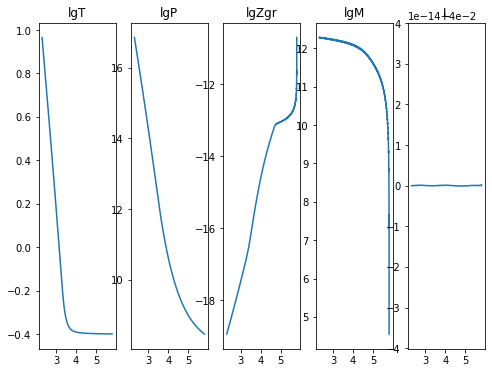

2020-11-16 04:22:39,910 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-11-16 04:22:40,980 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614626
2020-11-16 04:22:40,981 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-11-16 04:22:40,982 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:22:40,983 __main__ 0/1 INFO :: lgM iterate: 12.306662613109047
2020-11-16 04:22:40,984 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063357
2020-11-16 04:22:40,985 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:22:40,985 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


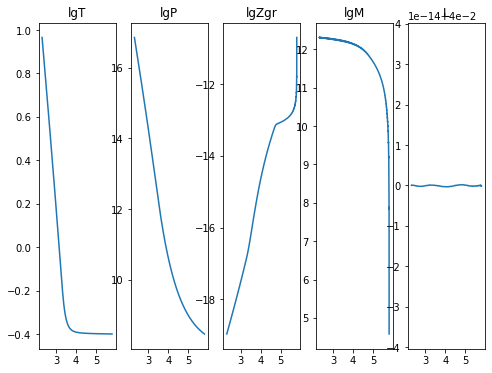

2020-11-16 04:22:45,160 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:22:46,278 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474610247
2020-11-16 04:22:46,279 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-11-16 04:22:46,282 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:22:46,283 __main__ 0/1 INFO :: lgM iterate: 12.27841443771273
2020-11-16 04:22:46,284 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118336
2020-11-16 04:22:46,285 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:22:46,286 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


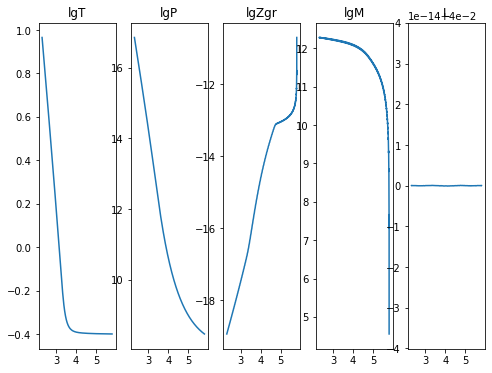

2020-11-16 04:22:49,745 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-11-16 04:22:51,185 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616862
2020-11-16 04:22:51,186 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234034
2020-11-16 04:22:51,187 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:22:51,189 __main__ 0/1 INFO :: lgM iterate: 12.306662613109108
2020-11-16 04:22:51,190 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-11-16 04:22:51,191 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:22:51,192 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


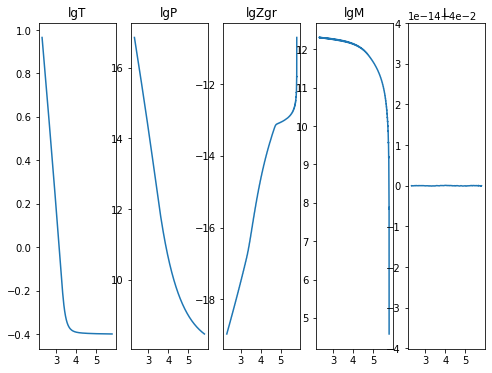

2020-11-16 04:22:55,587 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:22:56,712 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623703
2020-11-16 04:22:56,713 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-11-16 04:22:56,714 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:22:56,715 __main__ 0/1 INFO :: lgM iterate: 12.27841443771262
2020-11-16 04:22:56,716 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-11-16 04:22:56,717 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:22:56,718 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


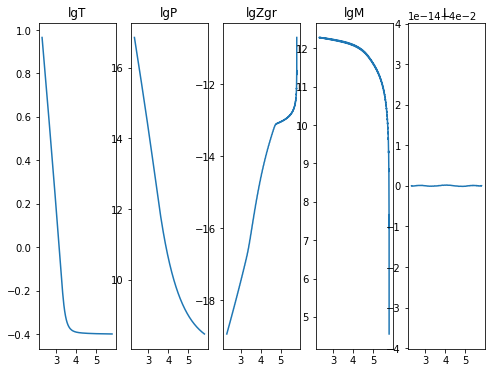

2020-11-16 04:23:01,131 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:23:02,338 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618742
2020-11-16 04:23:02,339 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234045
2020-11-16 04:23:02,340 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:23:02,341 __main__ 0/1 INFO :: lgM iterate: 12.306662613109136
2020-11-16 04:23:02,342 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063417
2020-11-16 04:23:02,343 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:23:02,344 __main__ 0/1 INFO :: L iterate: 0.04000000000000004


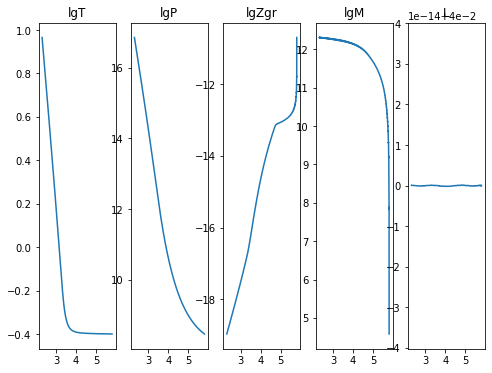

2020-11-16 04:23:06,872 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:23:08,275 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615578
2020-11-16 04:23:08,276 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894945
2020-11-16 04:23:08,277 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:23:08,278 __main__ 0/1 INFO :: lgM iterate: 12.278414437712678
2020-11-16 04:23:08,279 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-11-16 04:23:08,280 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:23:08,281 __main__ 0/1 INFO :: L iterate: 0.04


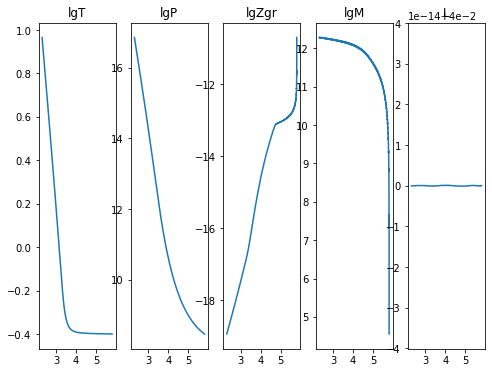

2020-11-16 04:23:12,930 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:23:14,167 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616804
2020-11-16 04:23:14,168 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234045
2020-11-16 04:23:14,169 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:23:14,170 __main__ 0/1 INFO :: lgM iterate: 12.30666261310922
2020-11-16 04:23:14,171 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-11-16 04:23:14,173 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:23:14,174 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


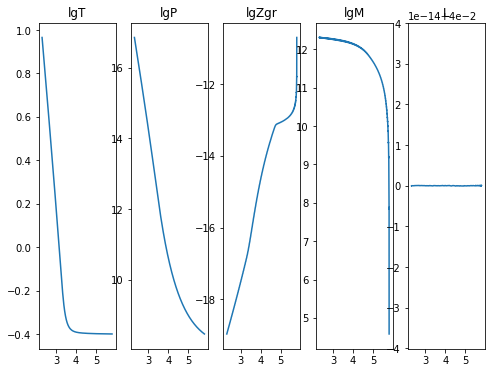

2020-11-16 04:23:18,346 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:23:19,532 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616864
2020-11-16 04:23:19,533 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-11-16 04:23:19,534 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:23:19,535 __main__ 0/1 INFO :: lgM iterate: 12.278414437712641
2020-11-16 04:23:19,536 __main__ 0/1 INFO :: lgZgr iterate: -18.9447523311833
2020-11-16 04:23:19,537 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-11-16 04:23:19,538 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


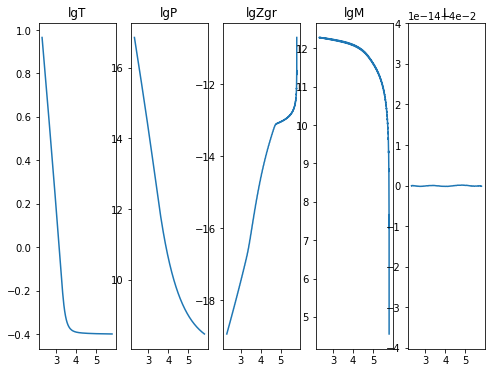

2020-11-16 04:23:24,497 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:23:26,238 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617501
2020-11-16 04:23:26,239 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234018
2020-11-16 04:23:26,241 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:23:26,242 __main__ 0/1 INFO :: lgM iterate: 12.306662613109202
2020-11-16 04:23:26,243 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-11-16 04:23:26,244 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:23:26,245 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


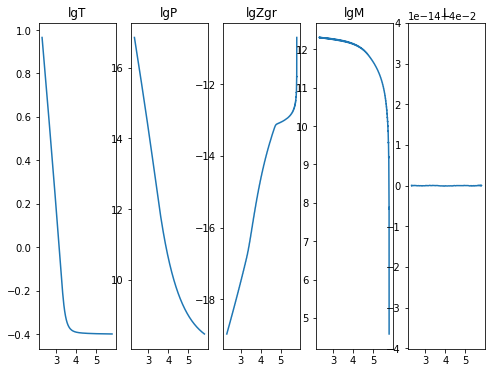

2020-11-16 04:23:30,988 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:23:32,523 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746183
2020-11-16 04:23:32,525 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894967
2020-11-16 04:23:32,526 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:23:32,527 __main__ 0/1 INFO :: lgM iterate: 12.278414437712659
2020-11-16 04:23:32,528 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183313
2020-11-16 04:23:32,529 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-11-16 04:23:32,530 __main__ 0/1 INFO :: L iterate: 0.04


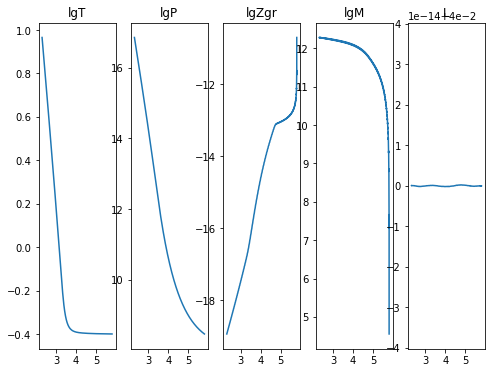

2020-11-16 04:23:37,262 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:23:38,760 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461793
2020-11-16 04:23:38,762 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234042
2020-11-16 04:23:38,763 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:23:38,763 __main__ 0/1 INFO :: lgM iterate: 12.306662613109147
2020-11-16 04:23:38,764 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063424
2020-11-16 04:23:38,766 __main__ 0/1 INFO :: m iterate: 1.6114013836165952e-05
2020-11-16 04:23:38,767 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


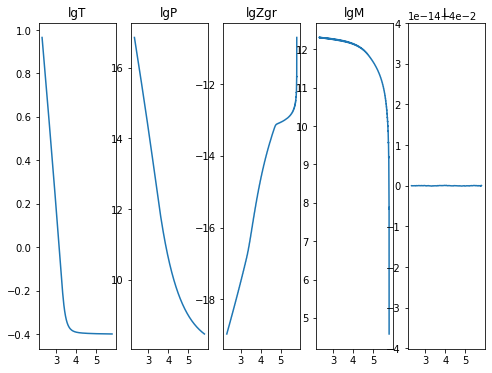

2020-11-16 04:23:43,594 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:23:44,717 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461784
2020-11-16 04:23:44,718 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-11-16 04:23:44,719 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:23:44,720 __main__ 0/1 INFO :: lgM iterate: 12.27841443771274
2020-11-16 04:23:44,721 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183366
2020-11-16 04:23:44,723 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-11-16 04:23:44,724 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


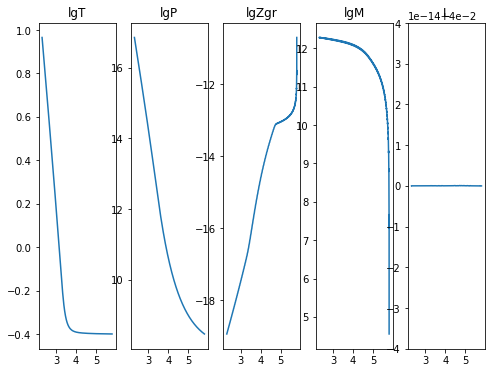

2020-11-16 04:23:50,671 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:23:52,148 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613897
2020-11-16 04:23:52,149 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234053
2020-11-16 04:23:52,150 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:23:52,151 __main__ 0/1 INFO :: lgM iterate: 12.306662613109166
2020-11-16 04:23:52,152 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-11-16 04:23:52,153 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:23:52,154 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


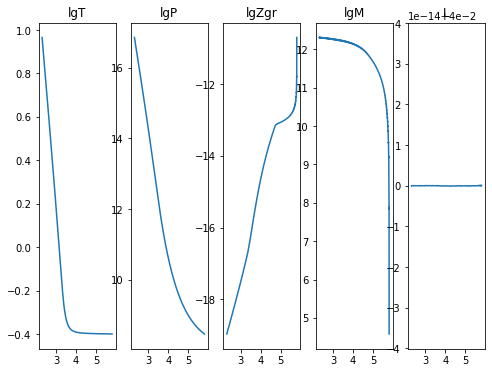

2020-11-16 04:23:56,422 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:23:57,524 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461019
2020-11-16 04:23:57,525 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894967
2020-11-16 04:23:57,526 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-11-16 04:23:57,527 __main__ 0/1 INFO :: lgM iterate: 12.278414437712623
2020-11-16 04:23:57,528 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-11-16 04:23:57,529 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:23:57,530 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


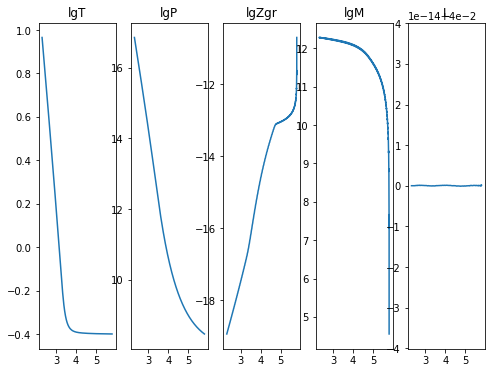

2020-11-16 04:24:02,346 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:24:03,888 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615612
2020-11-16 04:24:03,889 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234051
2020-11-16 04:24:03,890 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:24:03,892 __main__ 0/1 INFO :: lgM iterate: 12.306662613109257
2020-11-16 04:24:03,893 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150635
2020-11-16 04:24:03,894 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-11-16 04:24:03,895 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


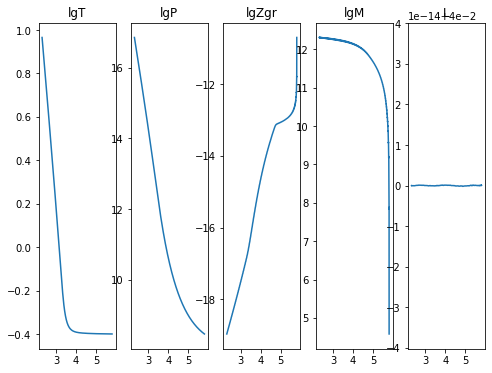

2020-11-16 04:24:08,932 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-11-16 04:24:10,696 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619824
2020-11-16 04:24:10,697 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894943
2020-11-16 04:24:10,698 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:24:10,699 __main__ 0/1 INFO :: lgM iterate: 12.278414437712602
2020-11-16 04:24:10,700 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183274
2020-11-16 04:24:10,701 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:24:10,702 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


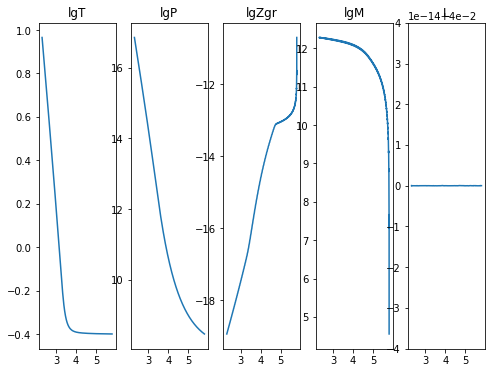

2020-11-16 04:24:15,273 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:24:16,602 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619018
2020-11-16 04:24:16,603 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234023
2020-11-16 04:24:16,605 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:24:16,606 __main__ 0/1 INFO :: lgM iterate: 12.306662613109076
2020-11-16 04:24:16,607 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506337
2020-11-16 04:24:16,608 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-11-16 04:24:16,609 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


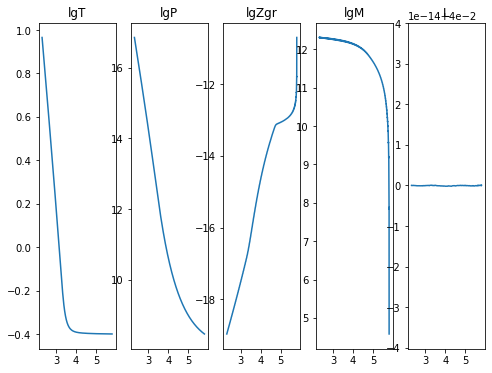

2020-11-16 04:24:21,104 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:24:22,562 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461923
2020-11-16 04:24:22,564 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894948
2020-11-16 04:24:22,565 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:24:22,566 __main__ 0/1 INFO :: lgM iterate: 12.278414437712634
2020-11-16 04:24:22,567 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-11-16 04:24:22,568 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-11-16 04:24:22,569 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


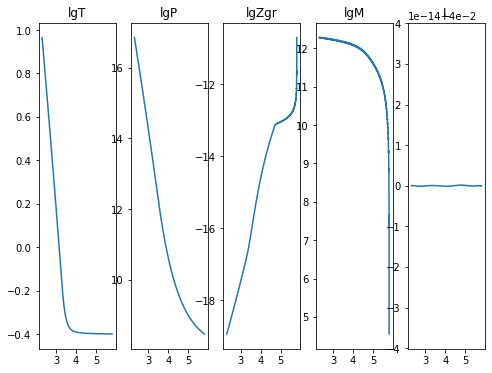

2020-11-16 04:24:28,131 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-11-16 04:24:29,763 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615714
2020-11-16 04:24:29,764 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234047
2020-11-16 04:24:29,765 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:24:29,766 __main__ 0/1 INFO :: lgM iterate: 12.306662613109216
2020-11-16 04:24:29,767 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063478
2020-11-16 04:24:29,768 __main__ 0/1 INFO :: m iterate: 1.611401384282729e-05
2020-11-16 04:24:29,769 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


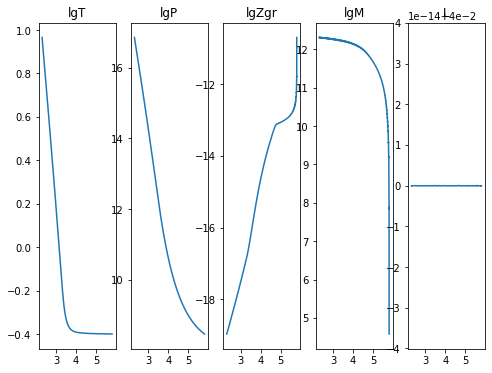

2020-11-16 04:24:34,079 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-11-16 04:24:35,525 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474612099
2020-11-16 04:24:35,526 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894944
2020-11-16 04:24:35,527 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:24:35,528 __main__ 0/1 INFO :: lgM iterate: 12.278414437712783
2020-11-16 04:24:35,529 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183395
2020-11-16 04:24:35,530 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-11-16 04:24:35,531 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


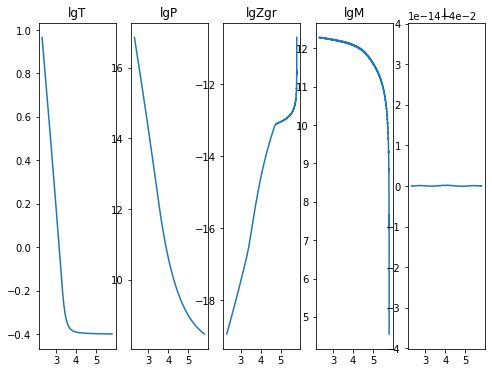

2020-11-16 04:24:40,819 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:24:42,356 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614726
2020-11-16 04:24:42,357 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-11-16 04:24:42,358 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:24:42,359 __main__ 0/1 INFO :: lgM iterate: 12.30666261310915
2020-11-16 04:24:42,360 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-11-16 04:24:42,361 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-11-16 04:24:42,362 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


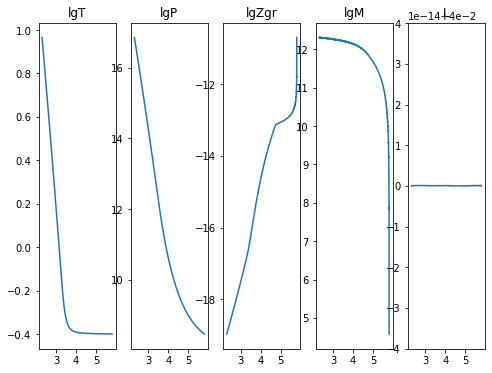

2020-11-16 04:24:47,186 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:24:48,474 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615858
2020-11-16 04:24:48,475 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894957
2020-11-16 04:24:48,476 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:24:48,477 __main__ 0/1 INFO :: lgM iterate: 12.278414437712609
2020-11-16 04:24:48,478 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183278
2020-11-16 04:24:48,480 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-11-16 04:24:48,481 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


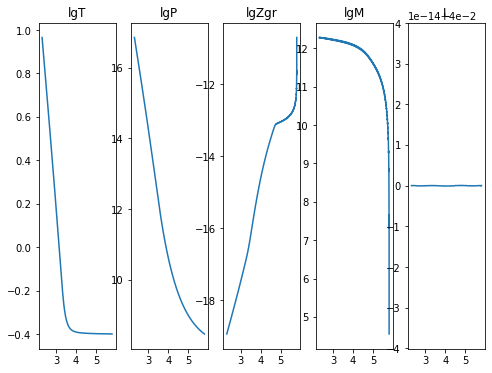

2020-11-16 04:24:52,824 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-11-16 04:24:54,198 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614686
2020-11-16 04:24:54,200 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234045
2020-11-16 04:24:54,201 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:24:54,201 __main__ 0/1 INFO :: lgM iterate: 12.306662613109241
2020-11-16 04:24:54,202 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063485
2020-11-16 04:24:54,203 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:24:54,204 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


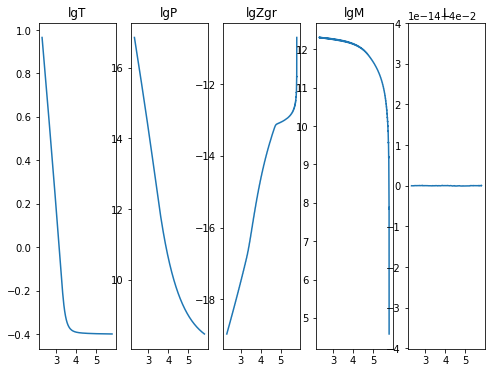

2020-11-16 04:24:58,250 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-11-16 04:24:59,671 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613094
2020-11-16 04:24:59,672 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-11-16 04:24:59,673 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-11-16 04:24:59,674 __main__ 0/1 INFO :: lgM iterate: 12.278414437712701
2020-11-16 04:24:59,675 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118334
2020-11-16 04:24:59,676 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:24:59,677 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


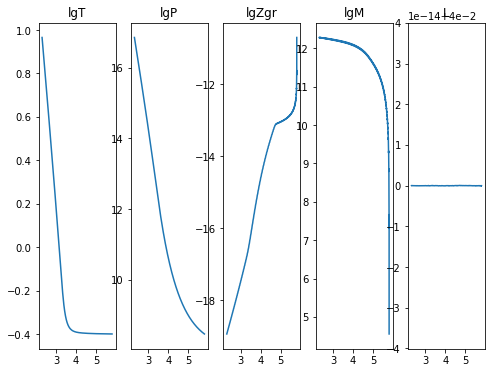

2020-11-16 04:25:03,813 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-11-16 04:25:05,636 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474611593
2020-11-16 04:25:05,638 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-11-16 04:25:05,640 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-11-16 04:25:05,642 __main__ 0/1 INFO :: lgM iterate: 12.306662613109056
2020-11-16 04:25:05,643 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063357
2020-11-16 04:25:05,645 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-11-16 04:25:05,647 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


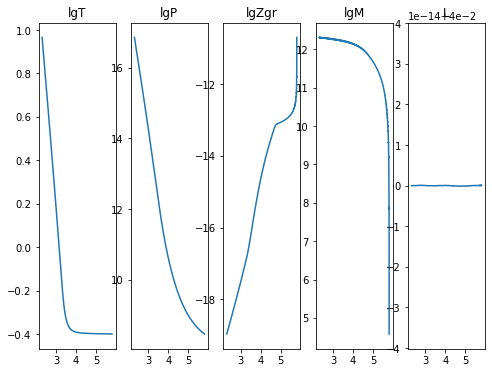

2020-11-16 04:25:11,577 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-11-16 04:25:13,115 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474610704
2020-11-16 04:25:13,123 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894994
2020-11-16 04:25:13,125 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-11-16 04:25:13,126 __main__ 0/1 INFO :: lgM iterate: 12.278414437712655
2020-11-16 04:25:13,126 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-11-16 04:25:13,128 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-11-16 04:25:13,129 __main__ 0/1 INFO :: L iterate: 0.04000000000000005


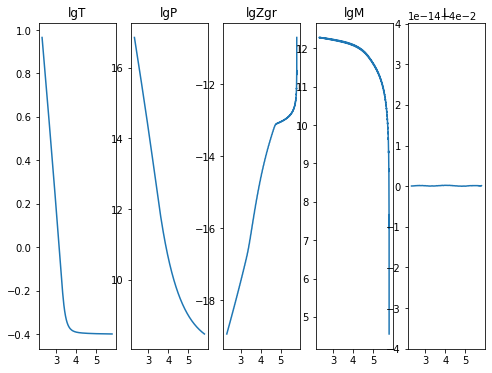

2020-11-16 04:25:18,559 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:25:20,034 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461183
2020-11-16 04:25:20,035 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234053
2020-11-16 04:25:20,036 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-11-16 04:25:20,037 __main__ 0/1 INFO :: lgM iterate: 12.30666261310919
2020-11-16 04:25:20,038 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-11-16 04:25:20,039 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-11-16 04:25:20,040 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


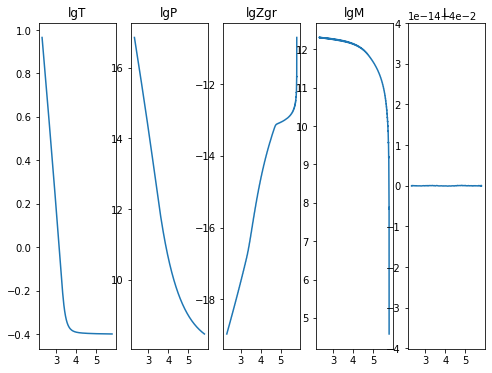

2020-11-16 04:25:25,259 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-11-16 04:25:26,692 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474612523
2020-11-16 04:25:26,694 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894945
2020-11-16 04:25:26,695 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-11-16 04:25:26,696 __main__ 0/1 INFO :: lgM iterate: 12.27841443771263
2020-11-16 04:25:26,697 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-11-16 04:25:26,698 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-11-16 04:25:26,699 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


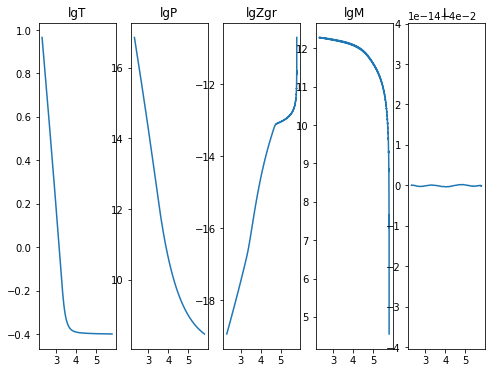

2020-11-16 04:25:31,022 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-11-16 04:25:32,456 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461358
2020-11-16 04:25:32,458 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-11-16 04:25:32,459 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-11-16 04:25:32,460 __main__ 0/1 INFO :: lgM iterate: 12.306662613109143
2020-11-16 04:25:32,461 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506342
2020-11-16 04:25:32,462 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-11-16 04:25:32,463 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


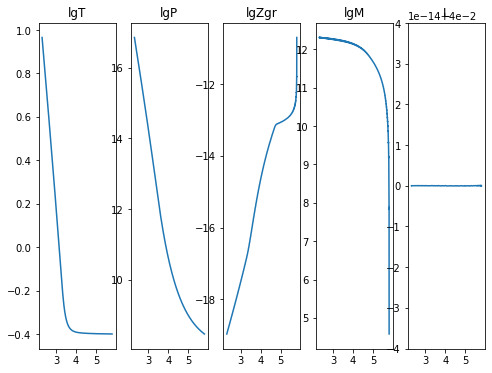

2020-11-16 04:25:36,505 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-11-16 04:25:37,617 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616975
2020-11-16 04:25:37,618 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894955
2020-11-16 04:25:37,619 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-11-16 04:25:37,620 __main__ 0/1 INFO :: lgM iterate: 12.278414437712637
2020-11-16 04:25:37,621 __main__ 0/1 INFO :: lgZgr iterate: -18.9447523311833
2020-11-16 04:25:37,622 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-11-16 04:25:37,623 __main__ 0/1 INFO :: L iterate: 0.04


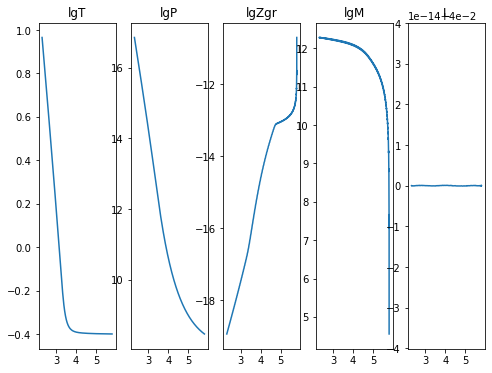

2020-11-16 04:25:41,624 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-11-16 04:25:43,081 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614926
2020-11-16 04:25:43,082 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-11-16 04:25:43,083 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-11-16 04:25:43,084 __main__ 0/1 INFO :: lgM iterate: 12.306662613109147
2020-11-16 04:25:43,085 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-11-16 04:25:43,086 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-11-16 04:25:43,087 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


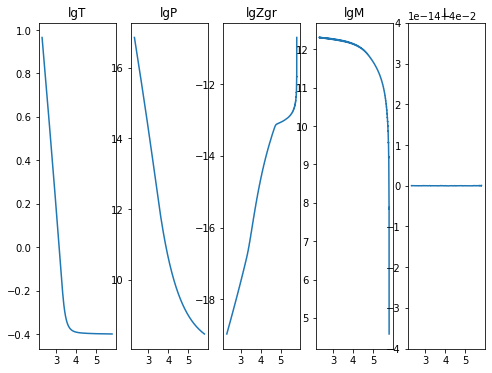

In [ ]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    L_list.append(np.copy(L1['g']))
    m_list.append(np.copy(m['g']))
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    logger.info('m iterate: {}'.format(m1['g'][0]))
    logger.info('L iterate: {}'.format(L1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,5,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,5,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,5,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,5,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.subplot(1,5,5)
    plt.plot(domain.grid(0), L1['g'])
    plt.title("L")
    plt.show()
    
end_time = time.time()

In [ ]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,5,1)
        plt.plot(R,lgT_list[i])
        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,5,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,5,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("Zgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,5,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))
        
#         plt.subplot(1,5,5)
#         plt.plot(R, m_list[i])
#         plt.title("m iteration: " + str(i))

        plt.subplot(1,5,5)
        plt.plot(R, L_list[i])
        plt.title("L iteration: " + str(i))
        
        

In [ ]:
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]
m['g'] = m_list[-1]
L['g'] = L_list[-1]

In [ ]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()

RCB = 0
epsilon = 0.0001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - Grad['g'][0]) >  epsilon:
        RCB = i
        break

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R, -Grad_rad['g'])
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

In [ ]:
TStop = Tstop.evaluate()
TStop.require_grid_space()
plt.plot(R, np.log10(TStop['g']))
plt.title('Tstop')

In [ ]:
Tgrow = 1/Tgrow_inv
TGrow = Tgrow.evaluate()
TGrow.require_grid_space()
plt.plot(R, np.log10(TGrow['g']))
plt.title('Tgrow')

# New analysis section (Jan 30)


In [ ]:
Bondi = r_Bondi # cm
# Bondi = 3.7e11 # cm
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))



In [ ]:
Bondi = 3.7e11 # cm
Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']


Tsettl = np.ones(len(R))


for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')
plt.title('Tsettl')

Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

In [ ]:
# Ormel profile
size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()


plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.plot(R, R/R*1e-4, 'b:', label='1 micron')
plt.yscale('log')
plt.ylim((1e-9, 1e2))
plt.legend()

In [ ]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgt = lgT_list[-1]


plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g'])**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0, 'r-', label='Temperature') 
plt.plot(R, np.exp(lgt)*T_0 *rho_gas['g'] , 'r--', label='Press=Rho*T')
plt.yscale('log')
plt.legend()

In [ ]:
plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3) , 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0 / Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()

In [ ]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

In [ ]:
dlgZgr = lgZgr.differentiate('r')
dlgP = lgP.differentiate('r')

# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr['g']/ dlgP['g'] 
grad_mu *= np.exp(lgZgr['g'])

#grad_mu.evaluate()
#grad_mu.require_grid_space()

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
#plt.plot(R, dlgZgr['g'] / dlgP['g'], label='Grad_mu')
plt.plot(R, grad_mu, label='Grad_mu')
plt.ylim(-0.5, 4)
plt.legend()

In [ ]:
lgMu = np.log(1+np.exp(lgZgr))
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
plt.plot(R, -Grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-4, 4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-4, 4))

In [ ]:
# Plot R_0 for fingering convection
R_0 = (Grad['g'] - grad_ad)/Grad_mu['g']

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(R_0), label='log10(R_0)')
plt.plot(R, 0*R , 'k-', label='Zero_line')
#plt.ylim(-1.0, 1000.0)
plt.legend()


In [ ]:
# Profile of nu and Xi for Prandtl number
c_gas=np.sqrt(8.32e7 * np.exp(lgt)*T_0 )
cross_sect_H2=2e-15 #cgs H2 cross section
lambda_mfp= 1./ (cross_sect_H2 * rho_gas['g'] / 2 / 1.67e-24)
nu_visc= lambda_mfp * c_gas

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(lambda_mfp), label='lambda_mfp')
plt.plot(R, np.log10(c_gas), label='c_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()       

In [ ]:
gas_gamma=7./5.
kappa_tot =  kappa.evaluate()
kappa_tot.require_grid_space()
#xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt['g'])*T_0)**4.  / rho_gas['g'] / np.exp(lgP['g']) 
xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt)*T_0)**4.  / rho_gas['g'] / kappa_tot['g']/ np.exp(lgP['g'])

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc), label='nu_visc')
plt.plot(R, np.log10(xi_rad), label='xi_rad')

plt.plot(R, np.log10(kappa_tot['g']), label='kappa_tot')

plt.plot(R, np.log10((np.exp(lgt)*T_0)**4.), label='T^4')
plt.plot(R, np.log10(rho_gas['g']), label='rho_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()

In [ ]:
# Profile of Prandtl number
plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc/xi_rad), label='Prandtl number')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()

In [ ]:
# Optical thickness to 'surface'
tau_opt= 10.**R * rho_gas['g'] *kappa_tot['g'] # Approximation to true integral of rho.dz

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(tau_opt), label='tau_opt')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'] - Grad_mu['g'] - grad_ad, label='Ledoux')
plt.plot(R, 0*R , label='Stability')
plt.ylim(-4, 1)
plt.legend()

In [ ]:


##### Tao

#lgMu = np.log(1+np.exp(lgZgr))
lgMu =np.exp(lgZgr)
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
#plt.plot(R, grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-0.3, 0.4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-0.1, 0.1))

In [ ]:
np.savetxt("NPressure_dep.txt", lgP_list[-1])
np.savetxt("NTemperature_dep.txt", lgT_list[-1])
np.savetxt("NZgr_dep.txt", lgZgr_list[-1])
np.savetxt("NM_dep.txt", lgM_list[-1])
np.savetxt("Nm_dep.txt",  m_list[-1])
np.savetxt("NL_dep.txt", L_list[-1])

In [ ]:
prefix = '02_1_'

np.savetxt('saved/'+prefix+'Ngrad.txt', Grad['g'])
np.savetxt('saved/'+prefix+'Ngrad_rad.txt', -Grad_rad['g'])
np.savetxt('saved/'+prefix+'NTstop.txt', np.log10(TStop['g']))
np.savetxt('saved/'+prefix+'NTgrow.txt', np.log10(TGrow['g']))
np.savetxt('saved/'+prefix+'NTsettl.txt', Tsettl) 
np.savetxt('saved/'+prefix+'NZgr.txt', np.exp(lgZgr['g'])) 
np.savetxt('saved/'+prefix+'Nkappa_gr.txt', kappa_gr['g']) 
np.savetxt('saved/'+prefix+'Nsize.txt', size['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_cbrt.txt', (rho_gas['g'])**(1/3))
np.savetxt('saved/'+prefix+'NTemperature.txt', np.exp(lgt)*T_0)
np.savetxt('saved/'+prefix+'NPress.txt', np.exp(lgt)*T_0 *rho_gas['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_norm.txt', (rho_gas['g']/rhodisk)**(1/3))
np.savetxt('saved/'+prefix+'NTemperature_norm.txt',np.exp(lgt)*T_0 / Tdisk)
np.savetxt('saved/'+prefix+'NEnv.txt', Env)
np.savetxt('saved/'+prefix+'Ngrad_mu.txt', Grad_mu['g'])
np.savetxt('saved/'+prefix+'Ngrad_ad.txt', grad_ad*np.ones(len(R)))
np.savetxt('saved/'+prefix+'Ngrad_diff.txt',  Grad_diff['g'])
np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))
np.savetxt('saved/'+prefix+'Nlambda_mfp.txt',  np.log10(lambda_mfp))
np.savetxt('saved/'+prefix+'Nc_gas.txt',  np.log10(c_gas))
np.savetxt('saved/'+prefix+'Nnu_visc.txt',  np.log10(nu_visc))
np.savetxt('saved/'+prefix+'Nxi_rad.txt',  np.log10(xi_rad))
np.savetxt('saved/'+prefix+'Nkappa_tot.txt',  np.log10(kappa_tot['g']))
np.savetxt('saved/'+prefix+'NTfourth.txt',  np.log10((np.exp(lgt)*T_0)**4.))
np.savetxt('saved/'+prefix+'Nrho_gas.txt',  np.log10(rho_gas['g']))
np.savetxt('saved/'+prefix+'NPrandtl_number.txt',  np.log10(nu_visc/xi_rad))
np.savetxt('saved/'+prefix+'Ntau_opt.txt',  np.log10(tau_opt))
np.savetxt('saved/'+prefix+'NLedoux.txt',  Grad['g'] - Grad_mu['g'] - grad_ad)
np.savetxt('saved/'+prefix+'NR.txt', R)
